# Uncertainty analysis

**Invert4Geom** uses a stochastic approach for quantifying uncertainties. Simply put, an inversion can be treated as a black box, which takes inputs and outputs a topography model. This inputs include gravity data, a starting model, and various parameters, such as amount of damping, density contrast, reference level, and parameters for estimating the regional gravity field. The concept of a stochastic uncertainty analysis is to see how changes to these *inputs* affects the *output* (inverted topography). 

For example, we can perform several inversions, changing the density contrast value used in each one, and compare the inverted topography for each of these. For this produced **ensemble** of inverted topography models, we can calculated the cell-wise mean and the cell-wise standard deviation. The grid of cell-wise means would be our stochastic topography model, and the grid of cell-wise standard deviations would be our estimate of the spatially-variable uncertainty of the model. This procedure is described in the below figure.

![uncertainty_workflow](uncertainty_workflow.png)

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import copy
import os
import pathlib
import pickle
import string

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import verde as vd
import xarray as xr
from polartoolkit import maps, profiles
from polartoolkit import utils as polar_utils

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Load previous inversion results
From the notebook [combining it all](08_combining_it_all.ipynb).

In [2]:
# load pickle files
params = []
with pathlib.Path("../tmp/08_combining_it_all_results.pickle").open("rb") as file:
    while True:
        try:
            params.append(pickle.load(file))
        except EOFError:
            break
(
    inv,
    regional_grav_kwargs,
    starting_topography_kwargs,
    true_topography,
    constraints_df,
) = params

In [3]:
print(f"Density contrast: {inv.model.density_contrast} kg/m3")
print(f"Reference level: {inv.model.zref} m")
print(f"Spacing: {inv.model.spacing} m")
print(f"Region: {inv.model.region}")
print(f"Solver damping: {inv.solver_damping}")

Density contrast: 2672 kg/m3
Reference level: 488.1811852647176 m
Spacing: 1000.0 m
Region: (0.0, 40000.0, 0.0, 30000.0)
Solver damping: 0.02248048120566656


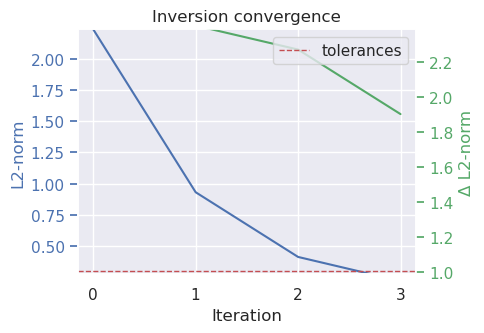

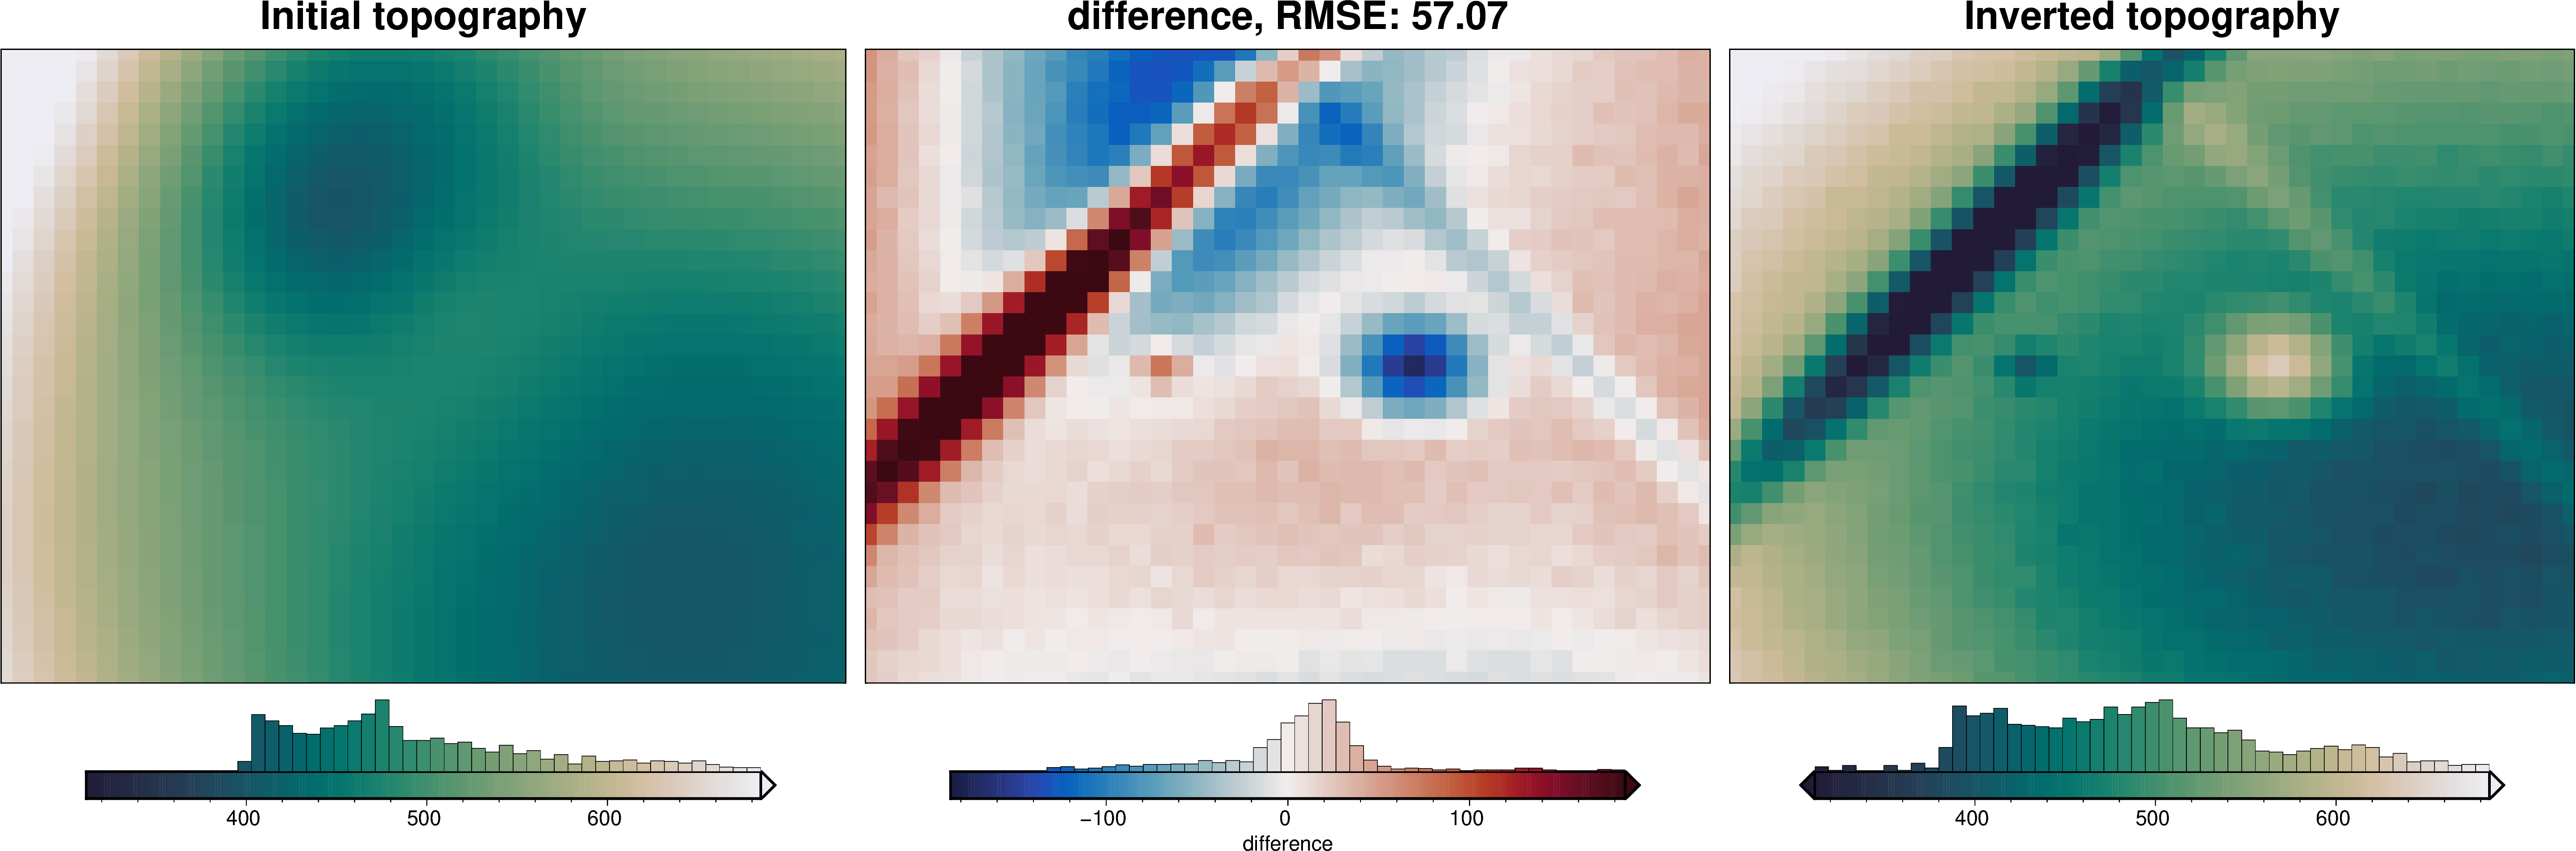

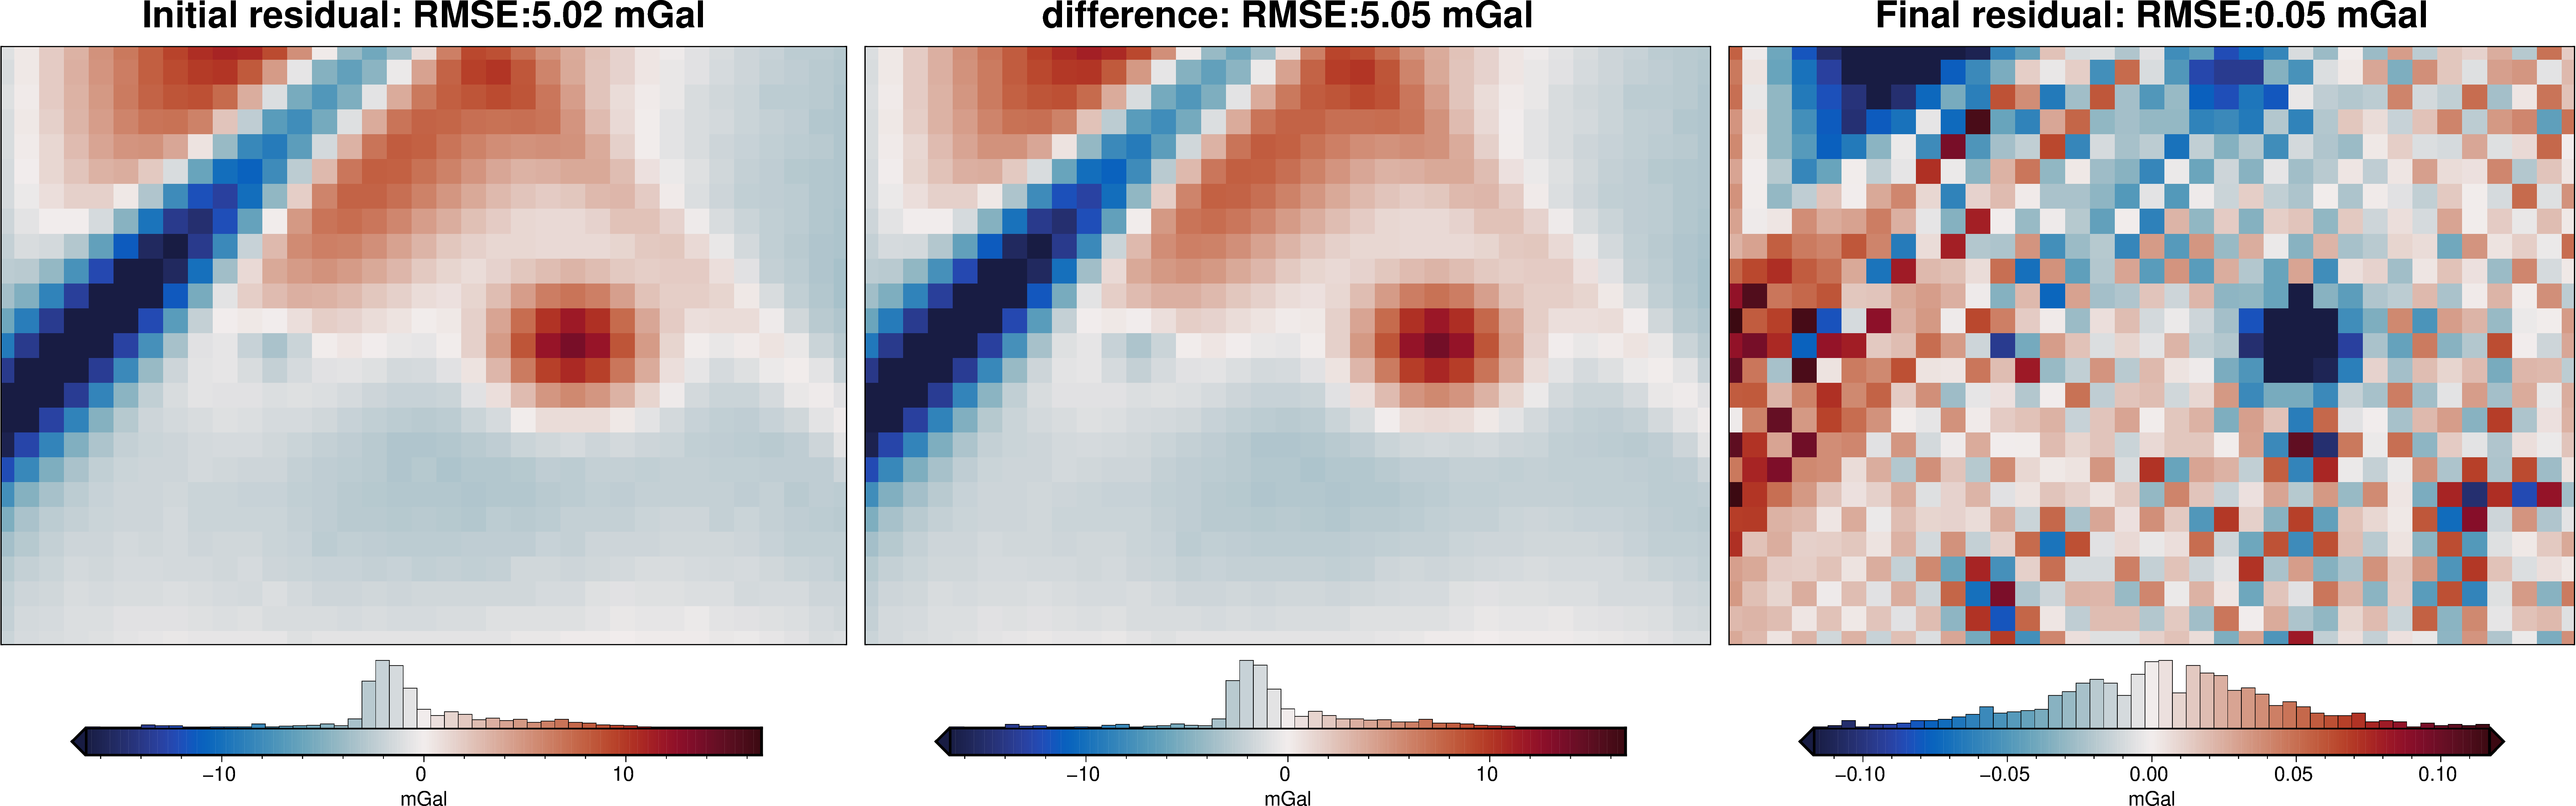

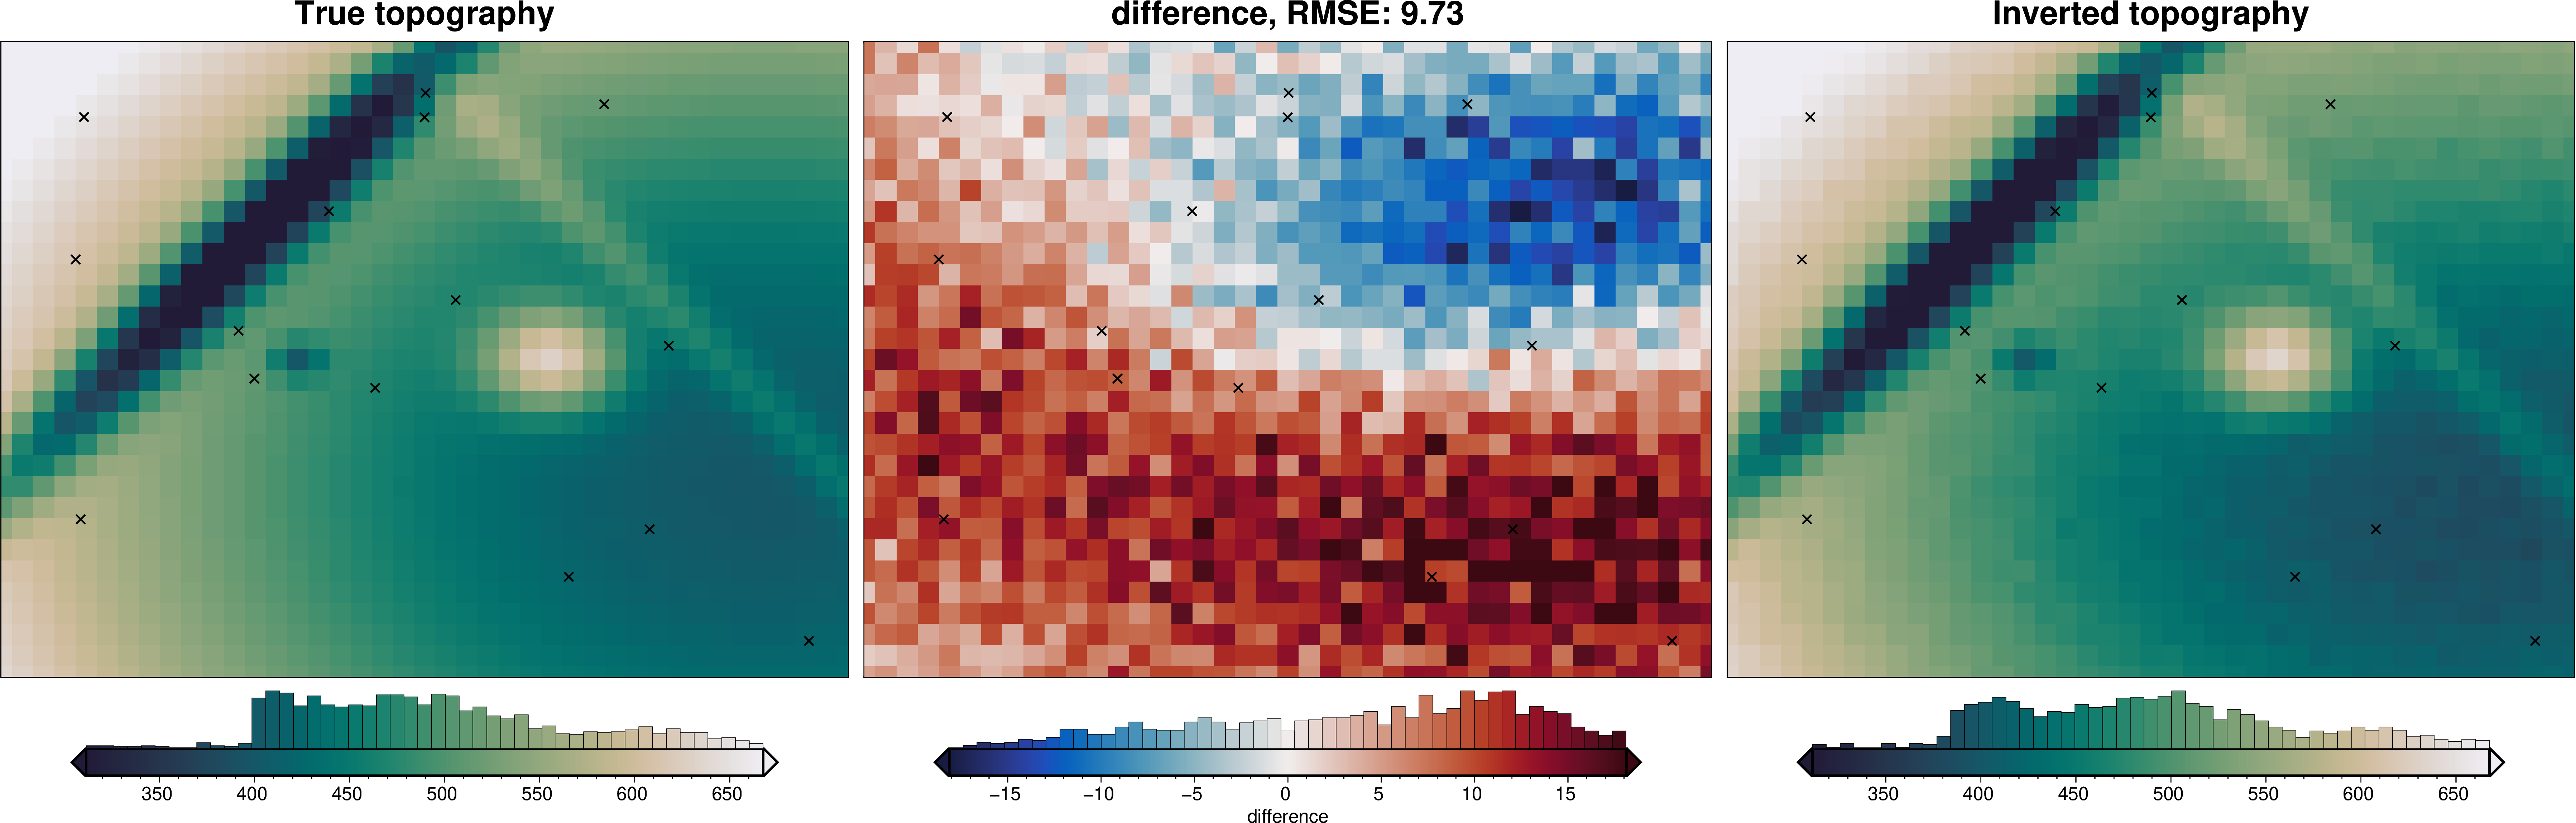

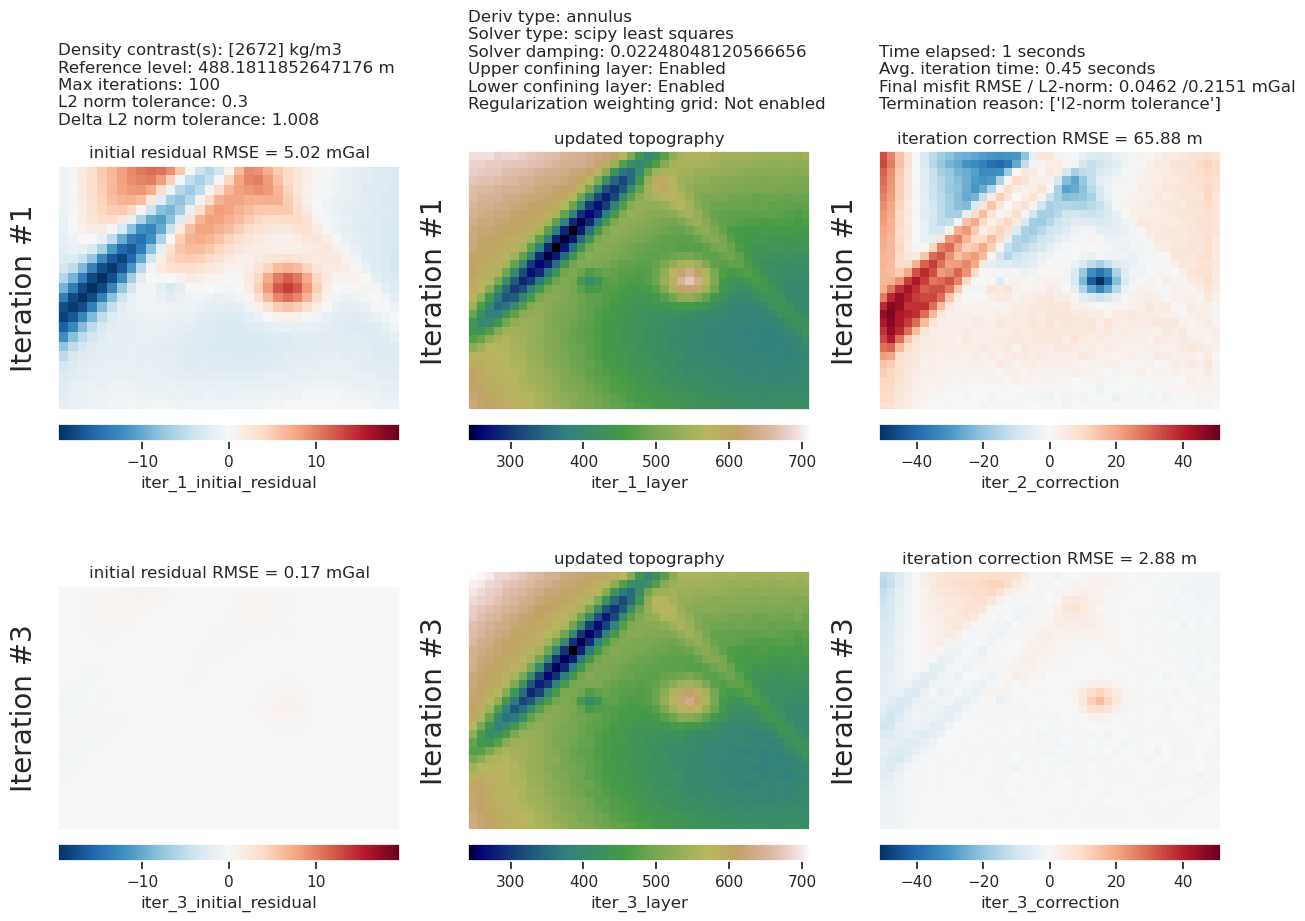

In [4]:
inv.plot_convergence()

inv.plot_inversion_results(iters_to_plot=2)

_ = polar_utils.grd_compare(
    true_topography,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraints_df,
    points_style="x.3c",
)

## Absolute value of inversion error

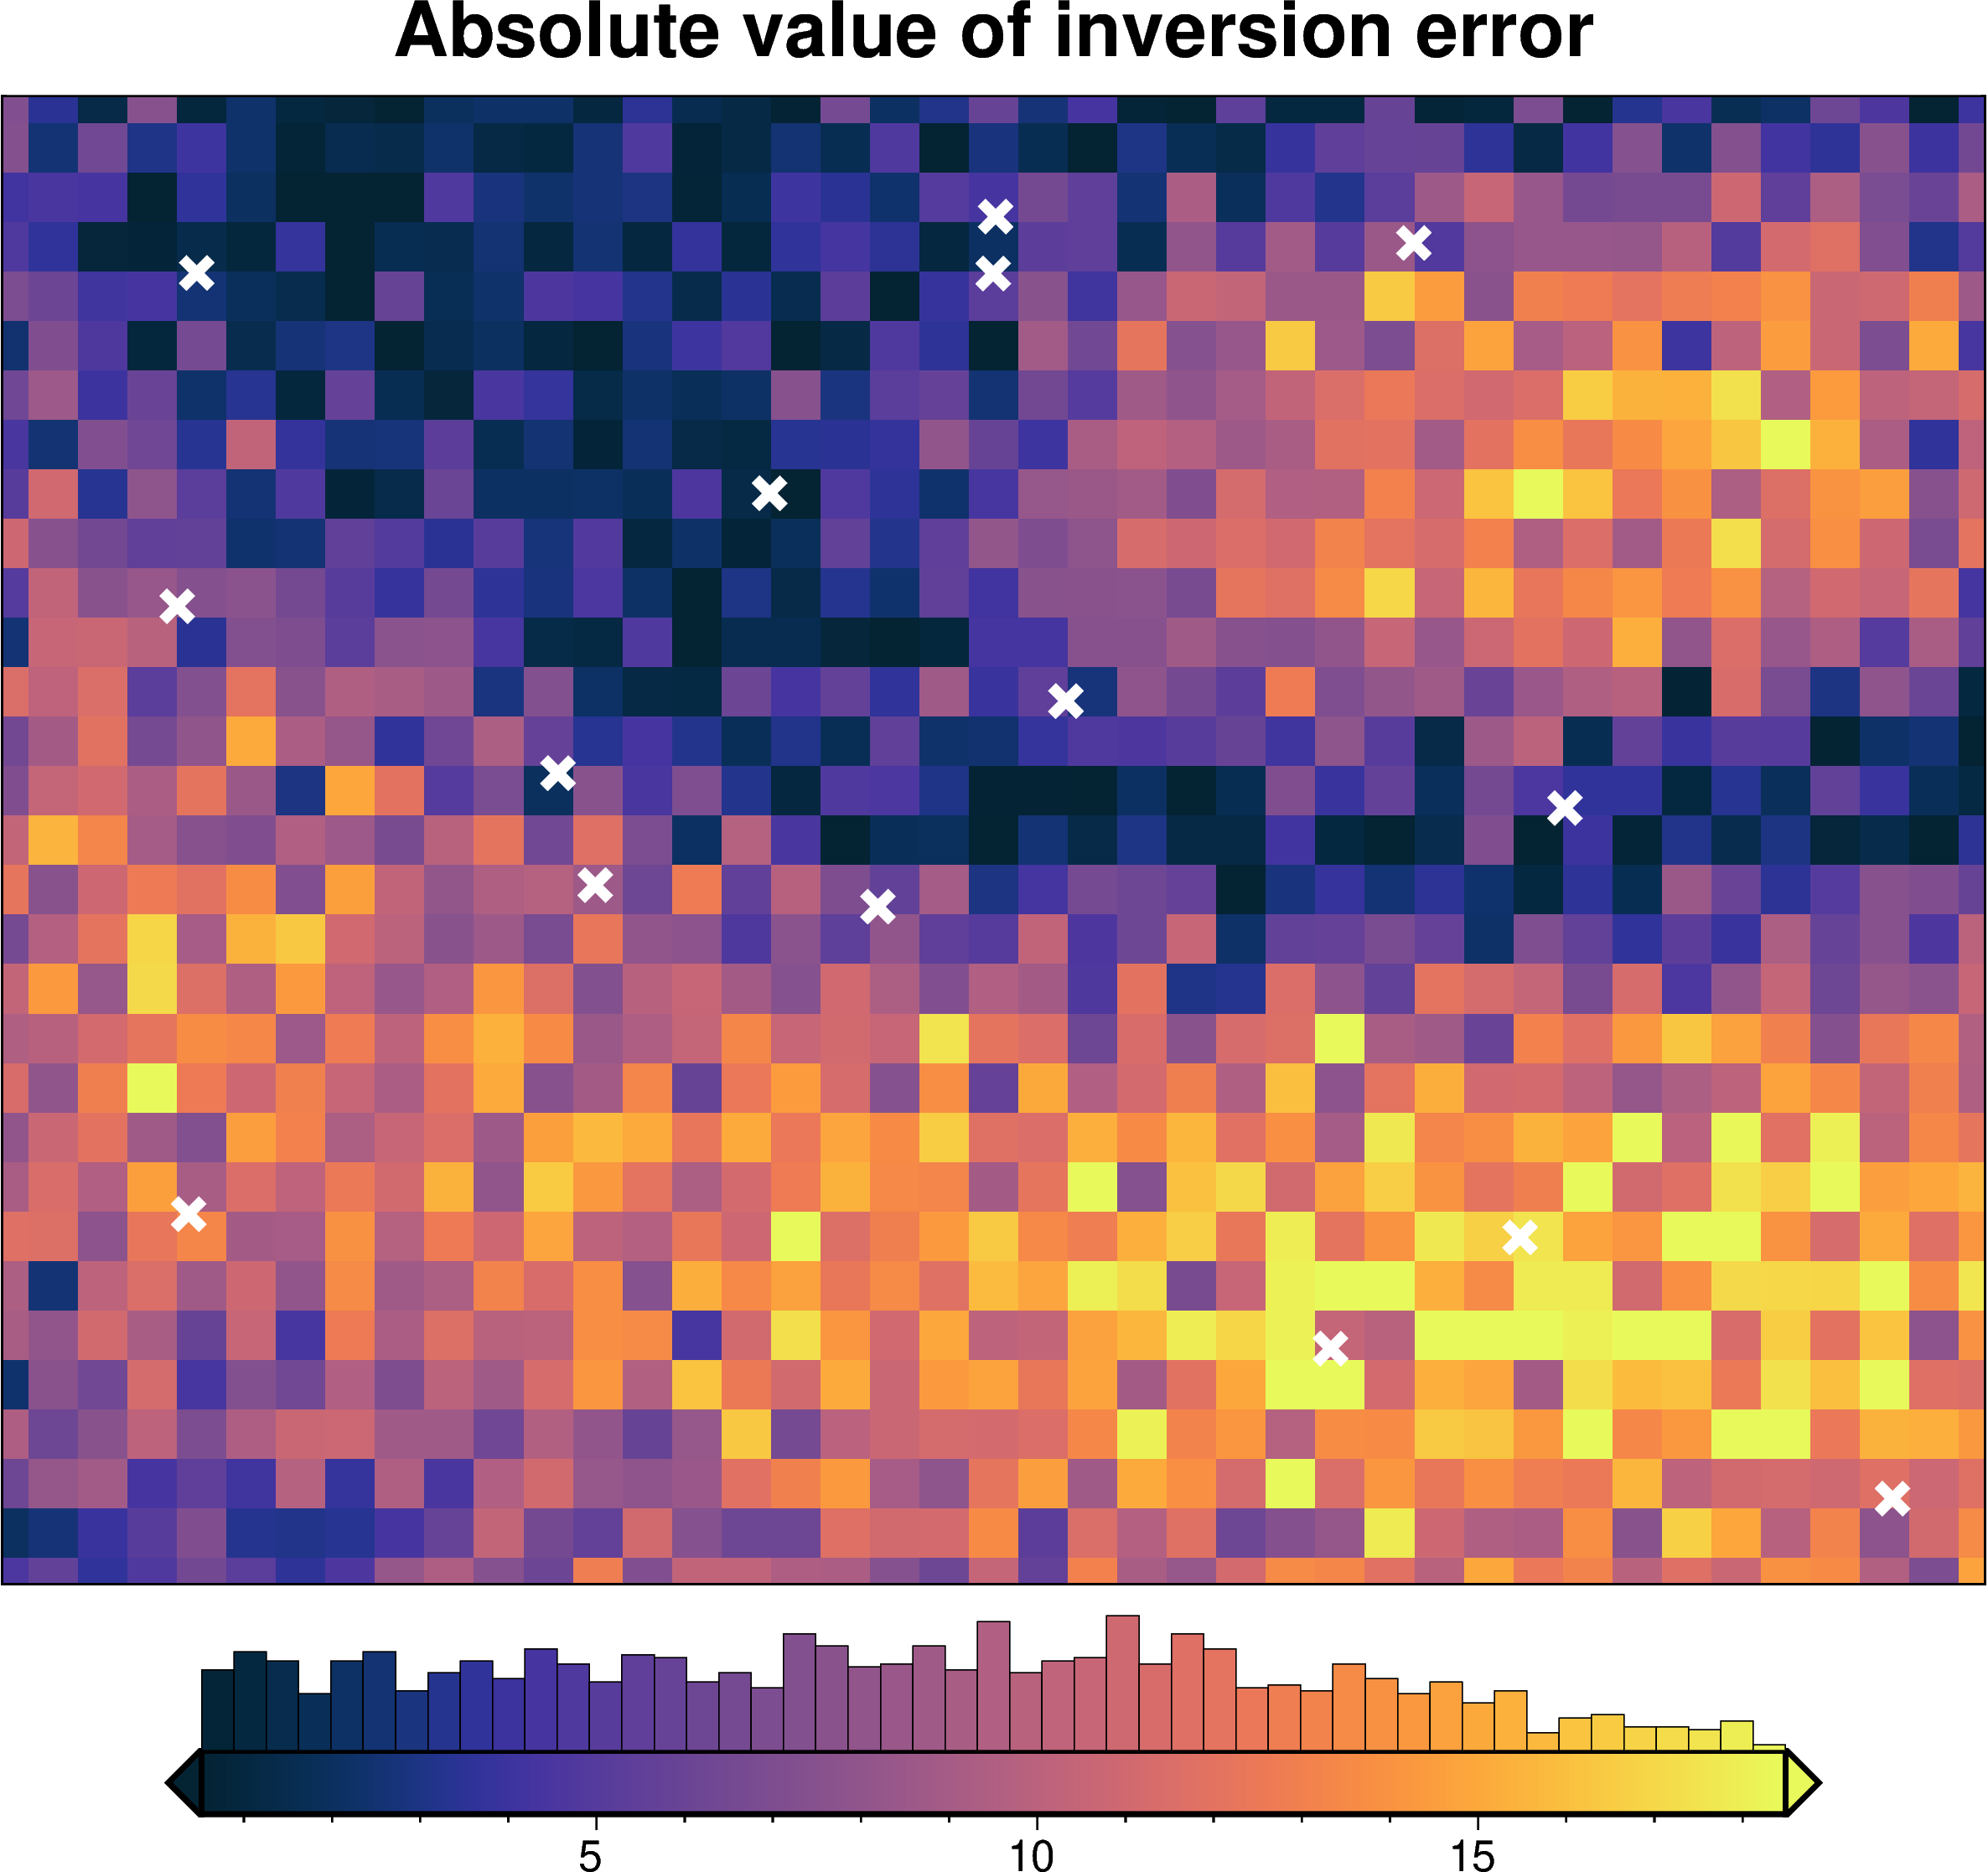

In [5]:
inversion_error = np.abs(true_topography - inv.model.topography)
fig = maps.plot_grd(
    inversion_error,
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
    points=constraints_df,
    points_style="x.4c",
    points_pen="3p",
    points_fill="white",
)
fig.show()

## Redo starting gravity and regional separation
use the optimal determined density contrast and zref values

In [6]:
inv.reinitialize_inversion()

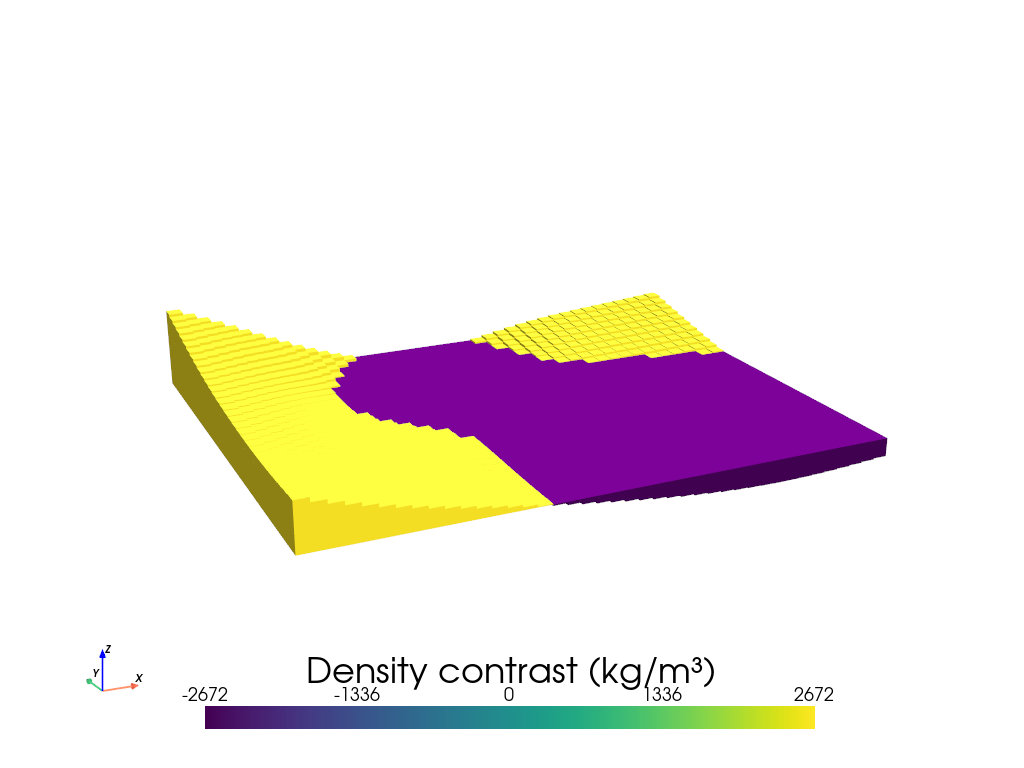

In [7]:
inv.data = invert4geom.create_data(inv.data)

inv.model = invert4geom.create_model(
    zref=inv.model.zref,
    density_contrast=inv.model.density_contrast,
    starting_topography=inv.model.starting_topography.to_dataset(name="upward"),
)
inv.model.inv.plot_model(
    color_by="density",
    zscale=20,
)

In [8]:
inv.data.inv.forward_gravity(inv.model)

# regional separation
temp_reg_kwargs = copy.deepcopy(regional_grav_kwargs)

# temporarily set some kwargs
# temp_reg_kwargs["cv_kwargs"]["plot"]=True
temp_reg_kwargs["cv_kwargs"]["progressbar"] = True

inv.data.inv.regional_separation(
    **temp_reg_kwargs,
)

inv.data.inv.df.describe()

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

northing      easting  upward  upper_surface_grav  \
count   1271.000000   1271.00000  1271.0         1271.000000   
mean   15000.000000  20000.00000  1001.0           -0.129619   
std     8947.792584  11836.81698     0.0            7.147140   
min        0.000000      0.00000  1001.0          -17.180401   
25%     7000.000000  10000.00000  1001.0           -5.537833   
50%    15000.000000  20000.00000  1001.0           -1.136301   
75%    23000.000000  30000.00000  1001.0            3.743994   
max    30000.000000  40000.00000  1001.0           19.581120   

       lower_surface_grav  gravity_anomaly_no_noise  gravity_anomaly  uncert  \
count         1271.000000               1271.000000      1271.000000  1271.0   
mean             0.004659                 -0.124959        -0.124959     0.1   
std              0.830306                  7.314752         7.313577     0.0   
min             -1.201774                -16.908339       -17.061563     0.1   
25%             -0.699901                 -5.826630        -5.827131     0.1   
50%             -0.177953                 -0.557795        -0.572175     0.1   
75%              0.629891                  4.171648         4.139840     0.1   
max              1.860259                 19.774399        19.944613     0.1   

       forward_gravity     true_res       misfit          reg          res  \
count      1271.000000  1271.000000  1271.000000  1271.000000  1271.000000   
mean          0.780936    -1.209548    -0.905895    -0.623714    -0.282181   
std           7.062011     4.456801     4.752772     1.105418     4.453787   
min          -8.812735   -19.046854   -19.676486    -2.504314   -18.164593   
25%          -4.602419    -2.622186    -2.509690    -1.511368    -2.057457   
50%          -1.205655    -1.088926    -1.293072    -0.671674    -0.118048   
75%           4.797950     0.332004     0.746161     0.294665     1.680282   
max          23.352858    12.693226    13.662658     1.379307    13.769065   

       starting_forward_gravity  starting_misfit  starting_reg  starting_res  
count               1271.000000      1271.000000   1271.000000   1271.000000  
mean                   0.780936        -0.905895     -0.623714     -0.282181  
std                    7.062011         4.752772      1.105418      4.453787  
min                   -8.812735       -19.676486     -2.504314    -18.164593  
25%                   -4.602419        -2.509690     -1.511368     -2.057457  
50%                   -1.205655        -1.293072     -0.671674     -0.118048  
75%                    4.797950         0.746161      0.294665      1.680282  
max                   23.352858        13.662658      1.379307     13.769065

In [9]:
# plotting functions for uncertainty results
def uncert_plots(
    results,
    inversion_region,
    spacing,
    true_topography,
    constraints_df=None,
    weight_by=None,
):
    if (weight_by == "constraints") & (constraints_df is None):
        msg = "must provide constraints_df if weighting by constraints"
        raise ValueError(msg)

    stats_ds = invert4geom.merged_stats(
        results=results,
        plot=True,
        constraints_df=constraints_df,
        weight_by=weight_by,
        region=inversion_region,
    )

    try:
        mean = stats_ds.weighted_mean
        stdev = stats_ds.weighted_stdev
    except AttributeError:
        mean = stats_ds.z_mean
        stdev = stats_ds.z_stdev

    _ = polar_utils.grd_compare(
        true_topography,
        mean,
        region=vd.pad_region(inversion_region, -spacing),
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        title="difference",
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
        points=constraints_df,
        points_style="x.3c",
    )
    _ = polar_utils.grd_compare(
        np.abs(true_topography - mean),
        stdev,
        region=vd.pad_region(inversion_region, -spacing),
        grid1_name="True error",
        grid2_name="Stochastic uncertainty",
        cmap="thermal",
        robust=True,
        hist=True,
        inset=False,
        title="difference",
        grounding_line=False,
        points=constraints_df,
        points_style="x.3c",
        points_fill="white",
    )
    return stats_ds

## Uncertainty analysis

In [10]:
# get mean spacing between nearest constraints
mean_spacing = np.mean(
    vd.median_distance(
        (constraints_df.easting, constraints_df.northing),
        k_nearest=1,
    )
)
mean_spacing

np.float64(5599.156508868462)

In [11]:
# use optimal eq source parameters for regional separation in uncertainty analysis
# re-load the study from the saved pickle file
with pathlib.Path(f"{regional_grav_kwargs.get('cv_kwargs').get('fname')}.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)
reg_eq_damping = min(study.best_trials, key=lambda t: t.values[0]).params["damping"]

reg_eq_depth = 4.5 * mean_spacing

new_regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraints_df,
    damping=reg_eq_damping,
    depth=reg_eq_depth,
    block_size=None,
)
reg_eq_damping, reg_eq_depth

(0.048090793172362284, np.float64(25196.204289908077))

### Solver damping component
To estimate the uncertainty of the choice of solver damping value, we will load the damping cross validation and calculate the standard deviation of the trials (excluding outliers)

In [12]:
# load study
with pathlib.Path("../tmp/08_combining_it_all_damping_CV_study.pickle").open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe()
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

# pick damping standard deviation based on optimization
stdev = np.log10(study_df2.params_damping).std()
print(f"calculated stdev: {stdev}")
# stdev = .1
print(f"using stdev: {stdev}")

calculated stdev: 0.6612590008069328
using stdev: 0.6612590008069328


best: 0.02248048120566656 
std: 0.6612590008069328 
+1std: 0.10305394083844288 
-1std: 0.00490395642443792


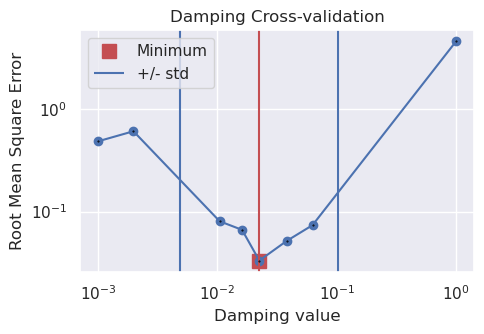

In [13]:
fig = invert4geom.plot_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)
ax = fig.axes[0]

best = float(study_df2.params_damping.iloc[0])
upper = float(10 ** (np.log10(best) + stdev))
lower = float(10 ** (np.log10(best) - stdev))

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

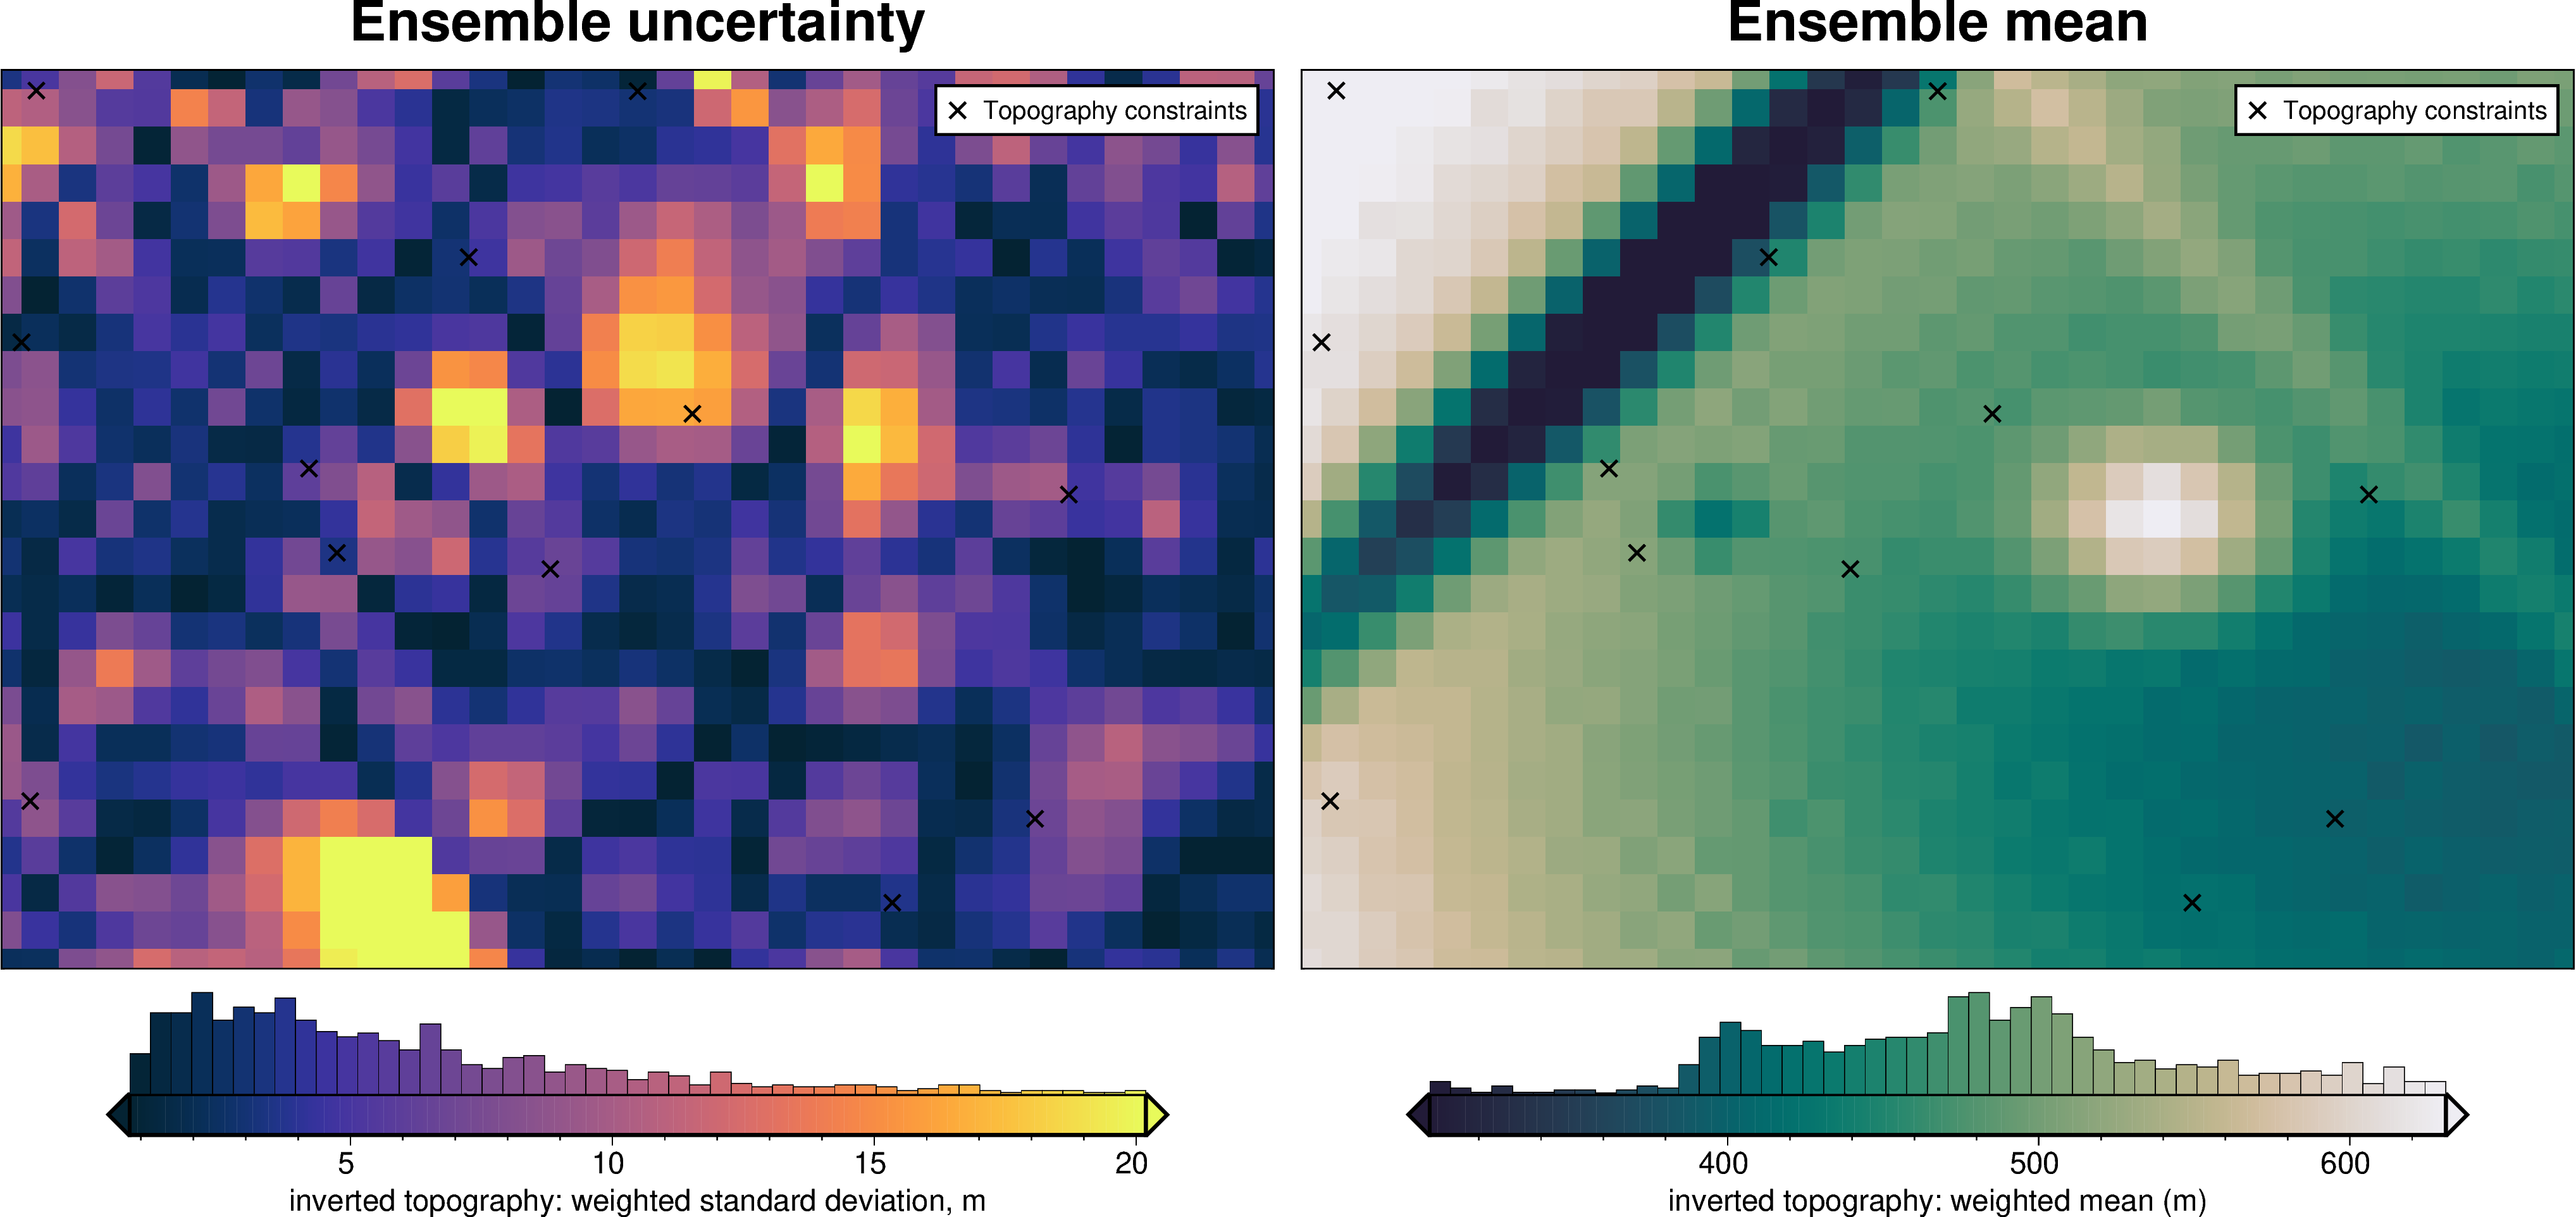

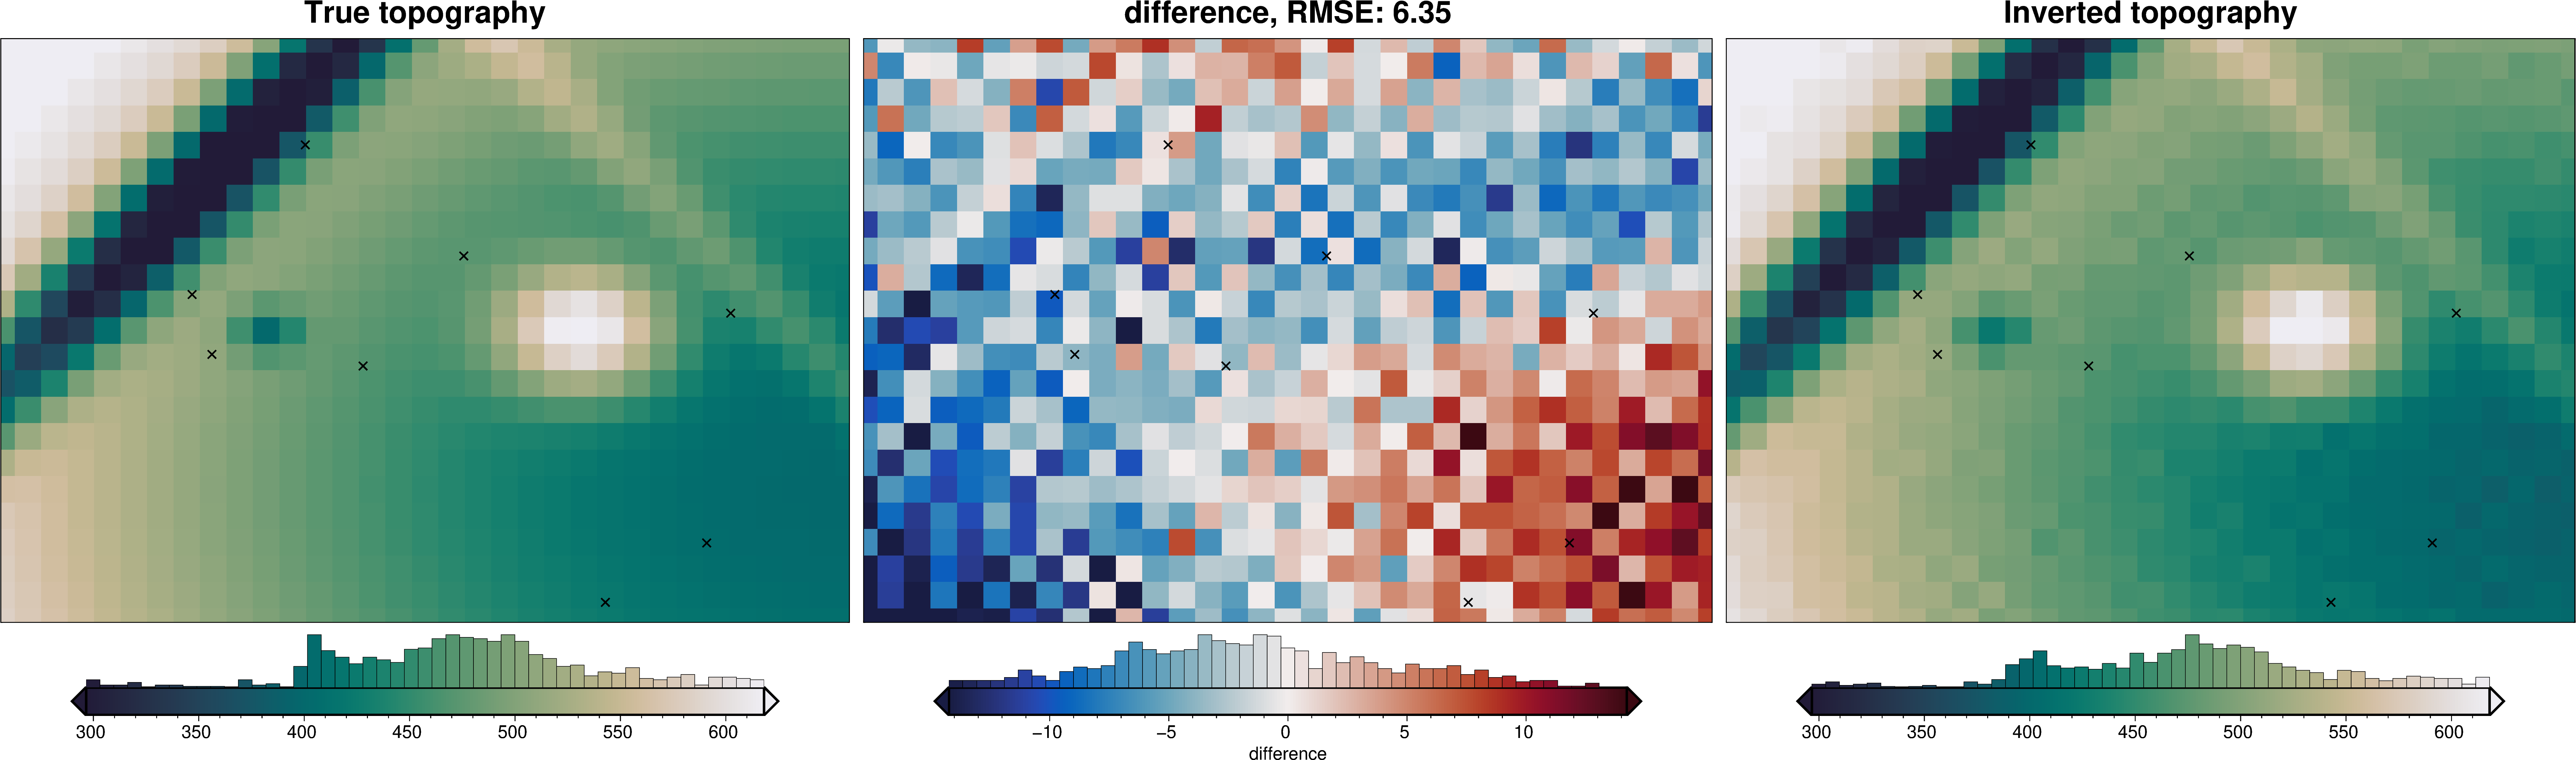

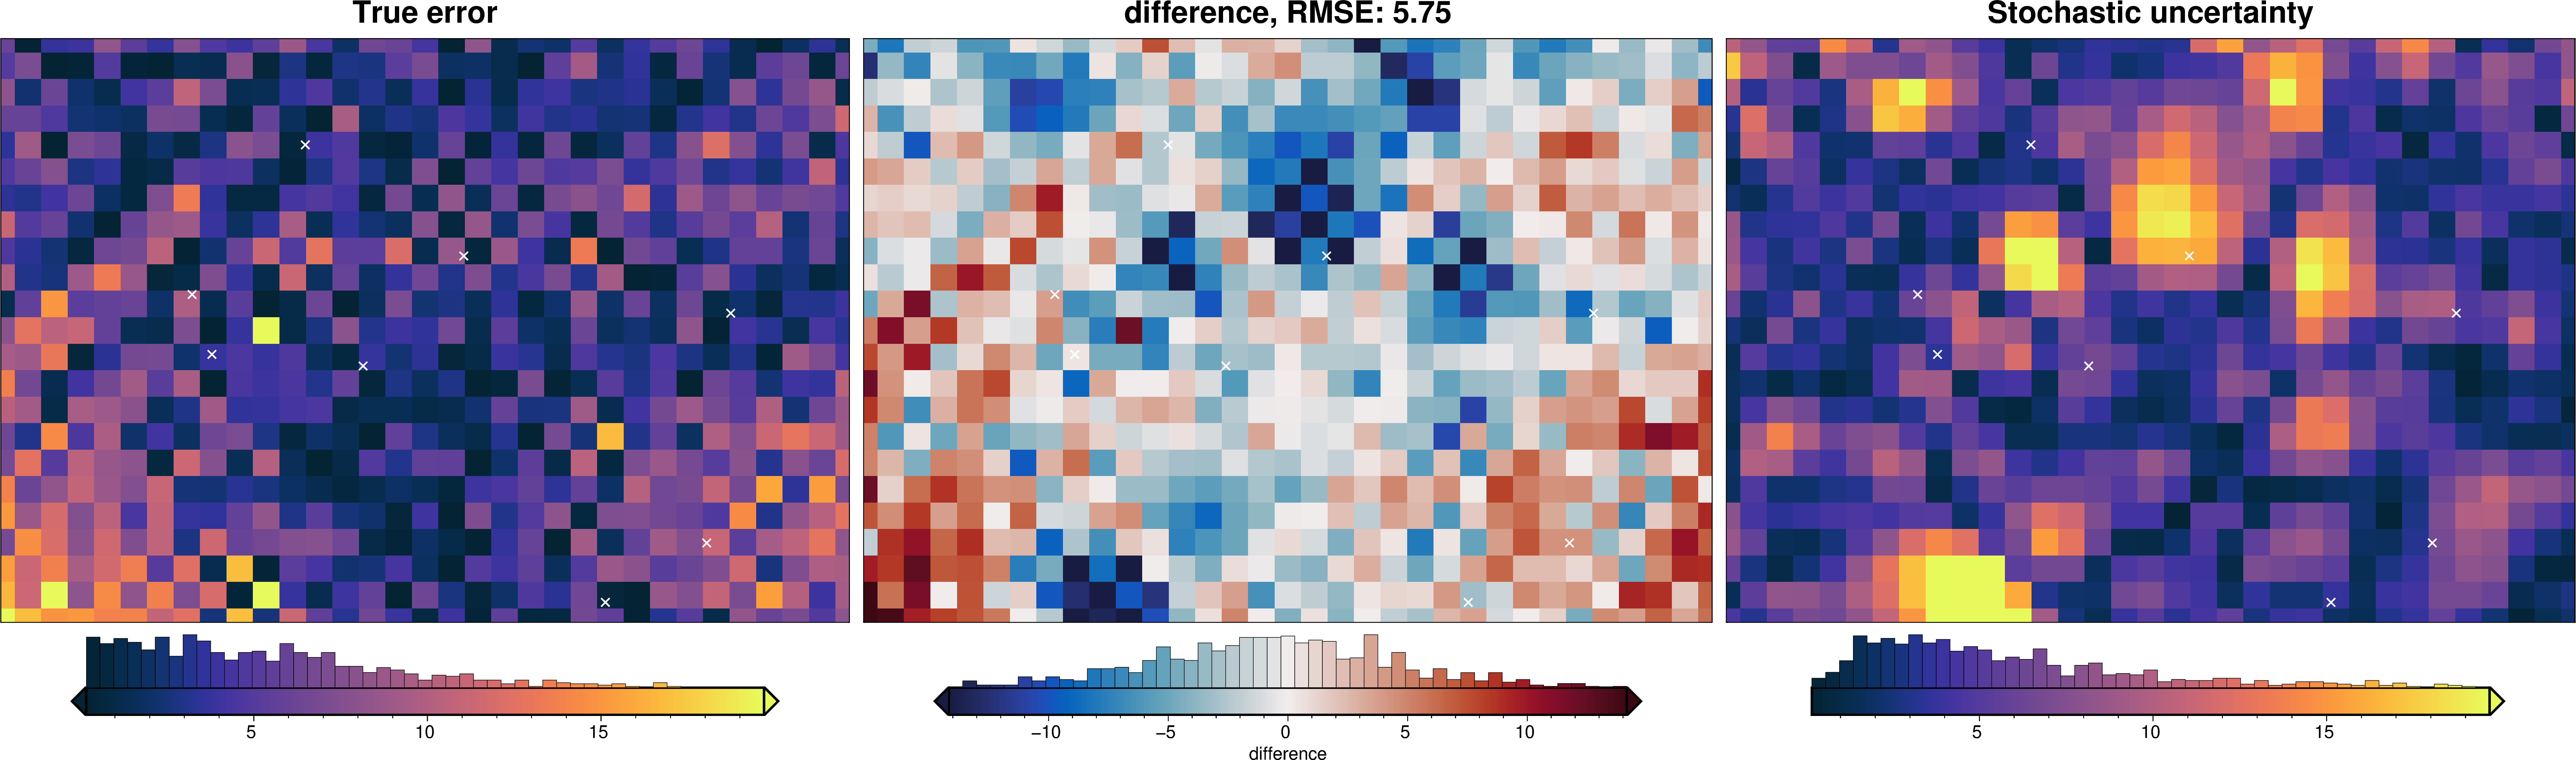

In [14]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(inv.solver_damping),  # mean of base 10 exponent
        "scale": stdev,  # standard deviation of base 10 exponent
        "log": True,
        # "distribution": "uniform",
        # "loc": -3,  # lower limit of exponent range
        # "scale": 2,  # value added to loc to get upper range of exponent
        # "log": True,
    },
}
fname = "../tmp/10_uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = invert4geom.full_workflow_uncertainty_loop(
    inv,
    fname=fname,
    runs=10,
    parameter_dict=solver_dict,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

stats_ds = uncert_plots(
    uncert_damping_results,
    inv.data.inner_region,
    inv.data.spacing,
    true_topography,
    constraints_df=constraints_df,
    weight_by="constraints",
)

### Z-ref and density components
To estimate the uncertainty of the choice of Z-ref and density value, we will sample the values from random distributions.

best: 488.1811852647176 
std: 75 
+1std: 563.1811852647177 
-1std: 413.1811852647176
best: 2672 
std: 150 
+1std: 2822 
-1std: 2522


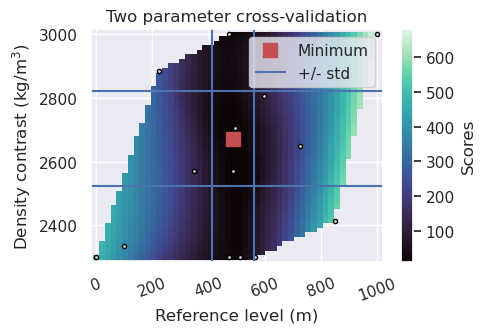

In [15]:
# choose standard deviations for the density contrast and zref
density_stdev = 150
zref_stdev = 75

# to re-load the study from the saved pickle file
with pathlib.Path(
    "../tmp/08_combining_it_all_density_and_zref_optimization_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

invert4geom.plot_2_parameter_scores_uneven(
    study,
    param_names=(
        "params_zref",
        "params_density_contrast",
    ),
    plot_param_names=(
        "Reference level (m)",
        "Density contrast (kg/m$^3$)",
    ),
)

ax = plt.gca()

# plot zref stdev
upper = inv.model.zref + zref_stdev
lower = inv.model.zref - zref_stdev
y_lims = ax.get_ylim()
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])
x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
print(
    "best:", inv.model.zref, "\nstd:", zref_stdev, "\n+1std:", upper, "\n-1std:", lower
)

# plot density contrast stdev
upper = inv.model.density_contrast + density_stdev
lower = inv.model.density_contrast - density_stdev
x_lims = ax.get_xlim()
ax.hlines(upper, xmin=x_lims[0], xmax=x_lims[1])
ax.hlines(lower, xmin=x_lims[0], xmax=x_lims[1])
y_lims = ax.get_ylim()
ax.set_ylim(
    min(y_lims[0], lower),
    max(y_lims[1], upper),
)
ax.legend()
print(
    "best:",
    inv.model.density_contrast,
    "\nstd:",
    density_stdev,
    "\n+1std:",
    upper,
    "\n-1std:",
    lower,
)

stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

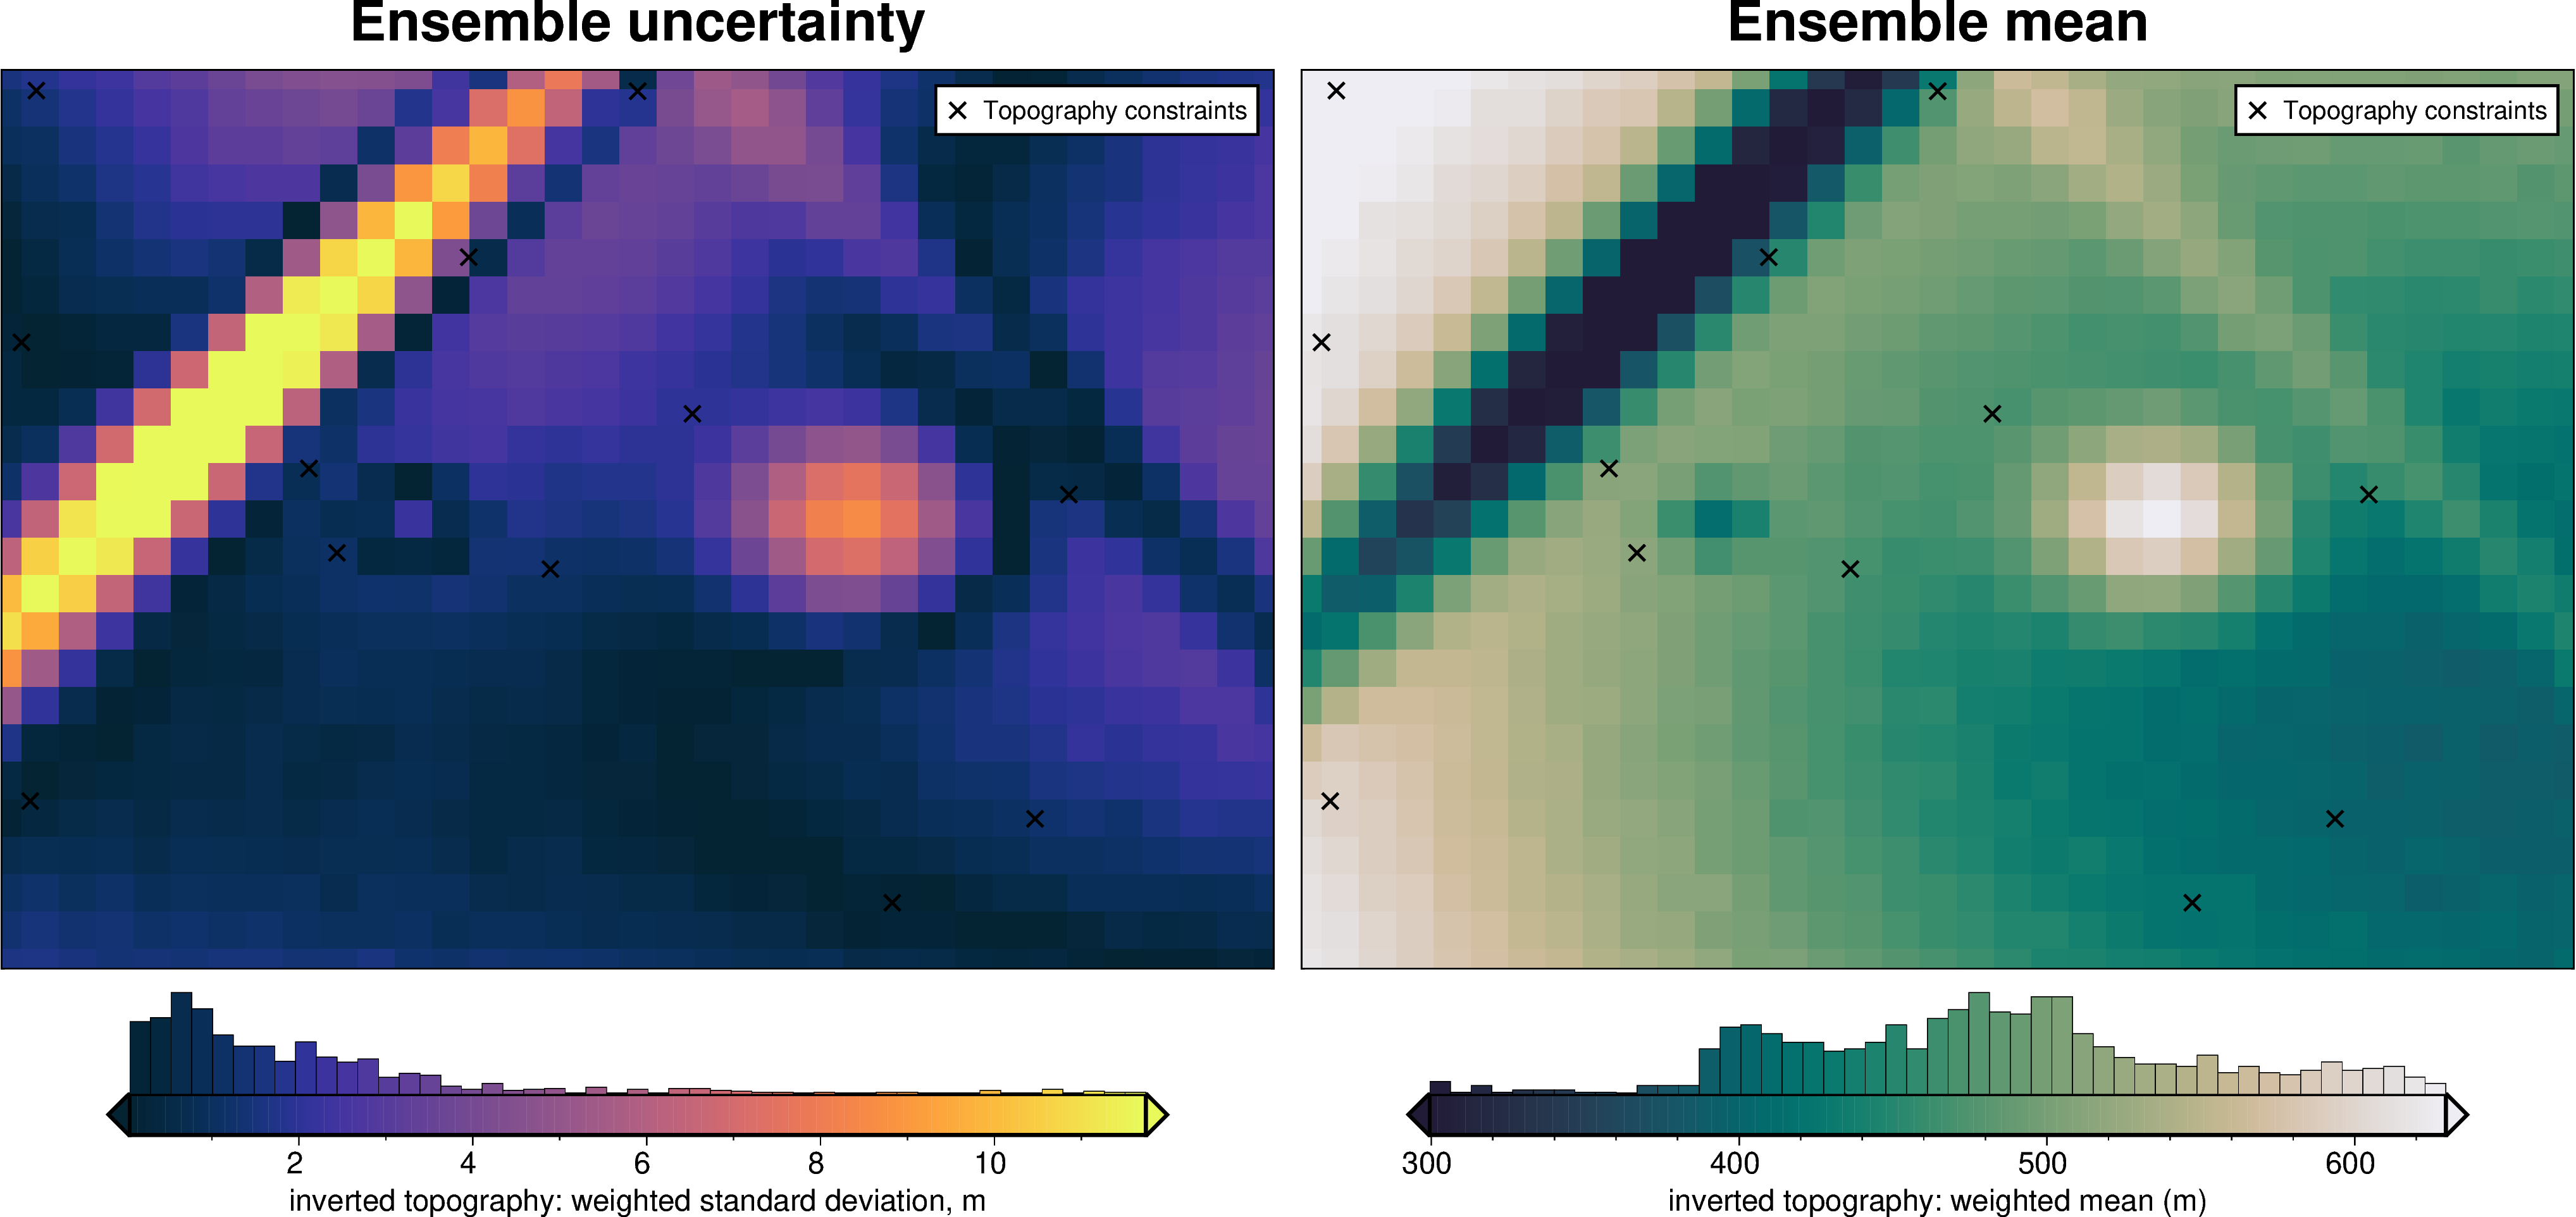

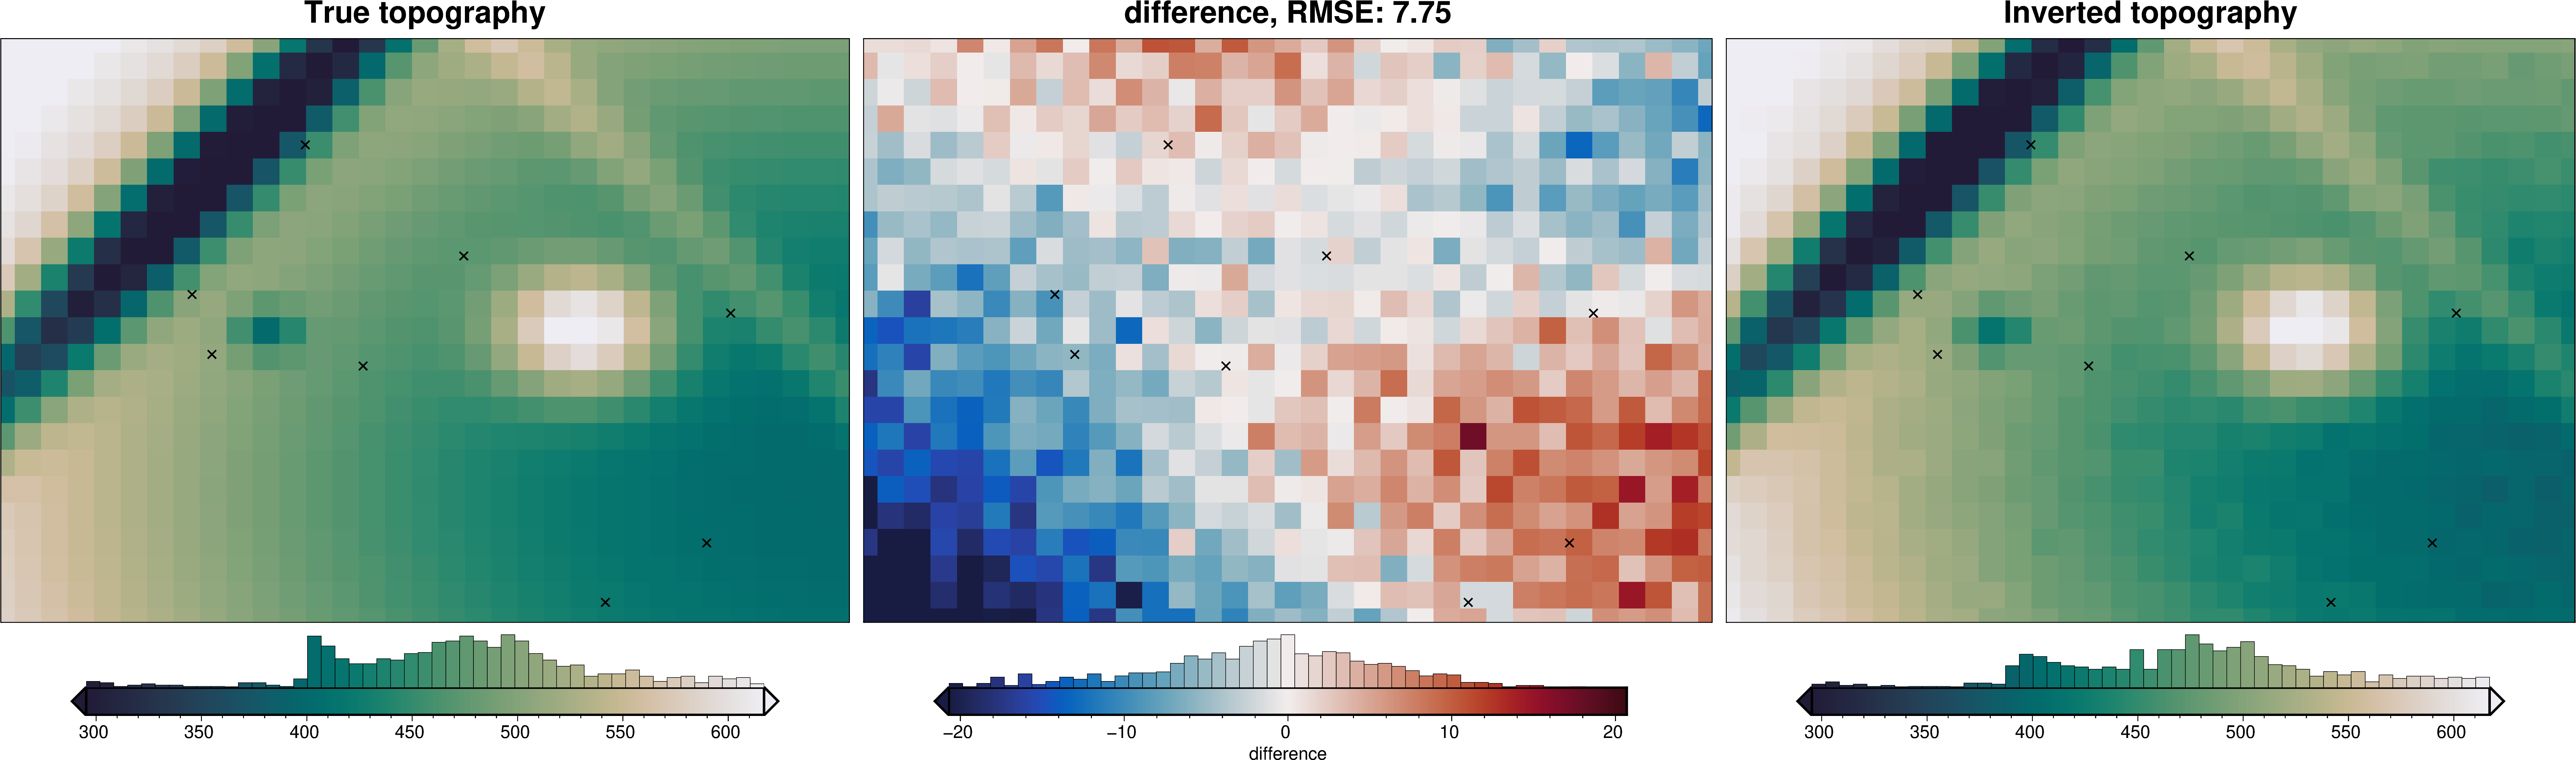

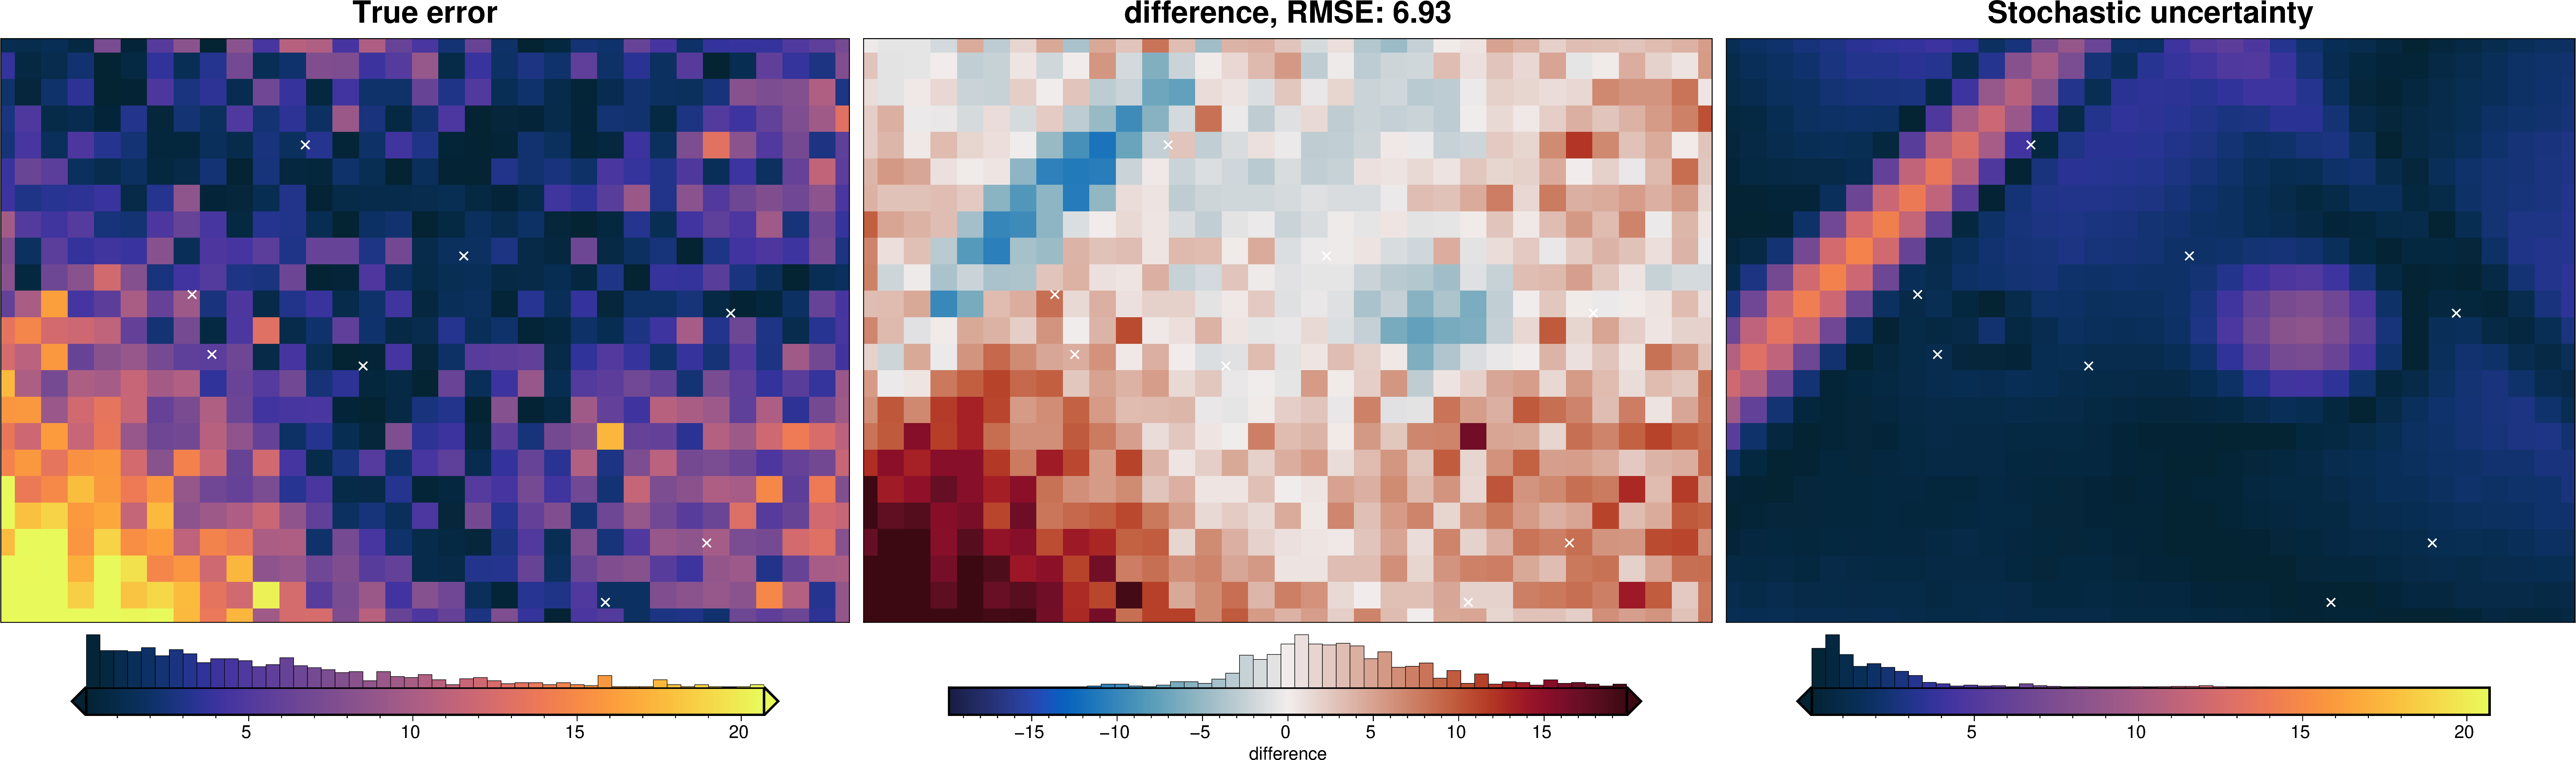

In [16]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": inv.model.density_contrast,
        "scale": density_stdev,
    },
}
fname = "../tmp/10_uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = invert4geom.full_workflow_uncertainty_loop(
    inv,
    fname=fname,
    runs=10,
    parameter_dict=density_dict,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

stats_ds = uncert_plots(
    uncert_density_results,
    inv.data.inner_region,
    inv.data.spacing,
    true_topography,
    constraints_df=constraints_df,
    weight_by="constraints",
)

stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

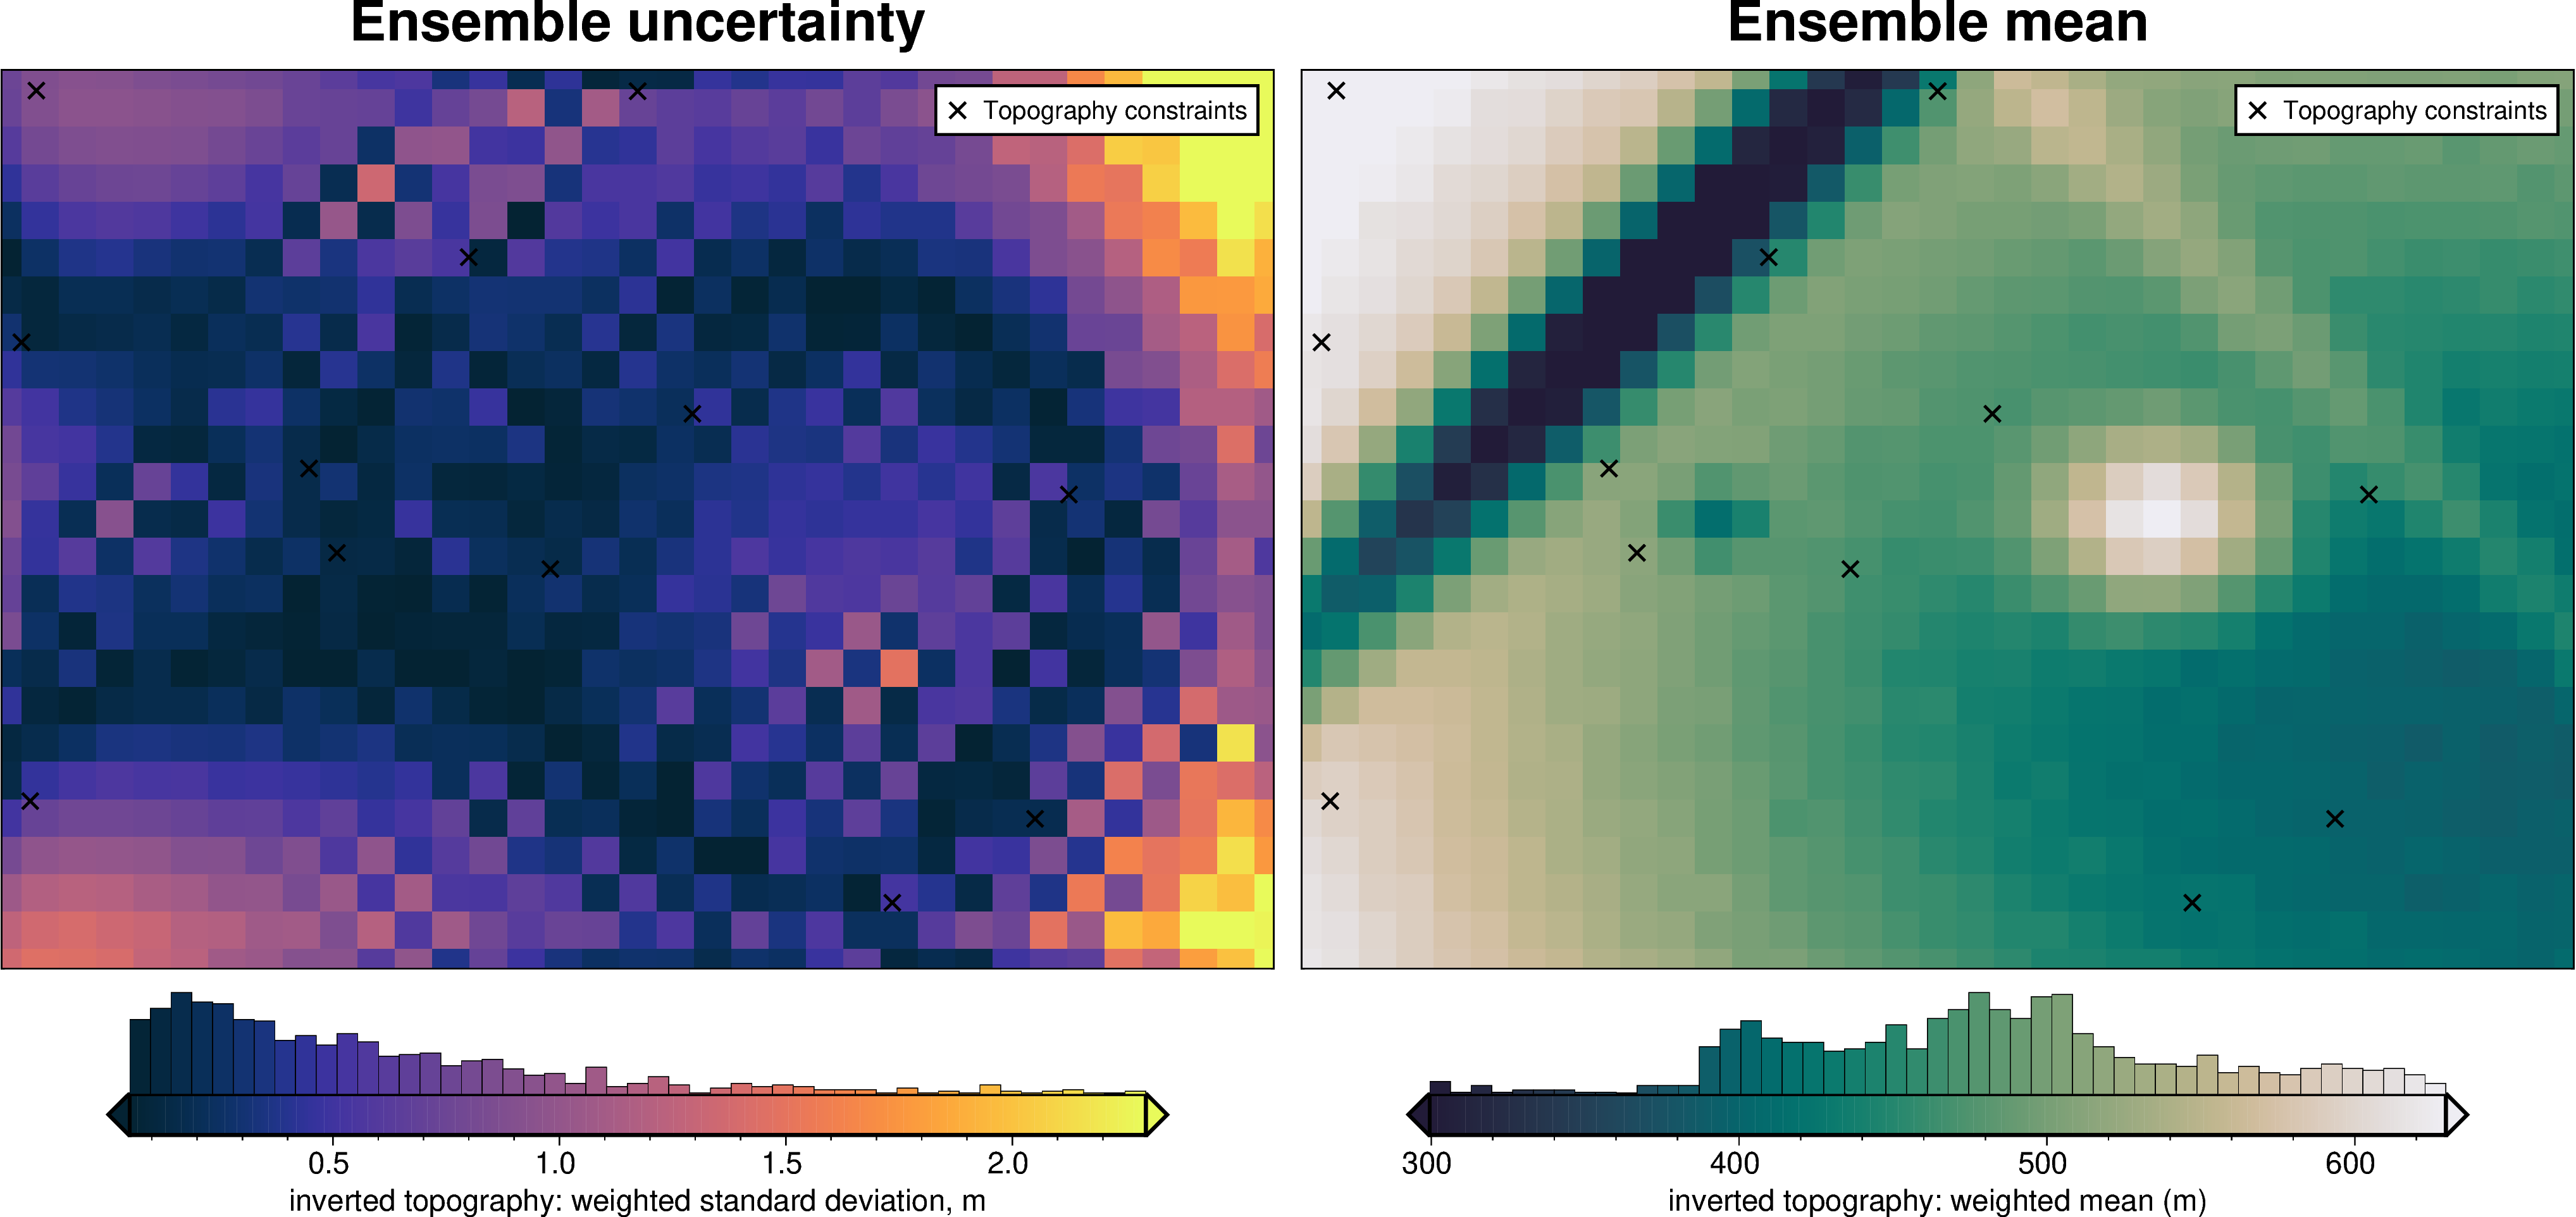

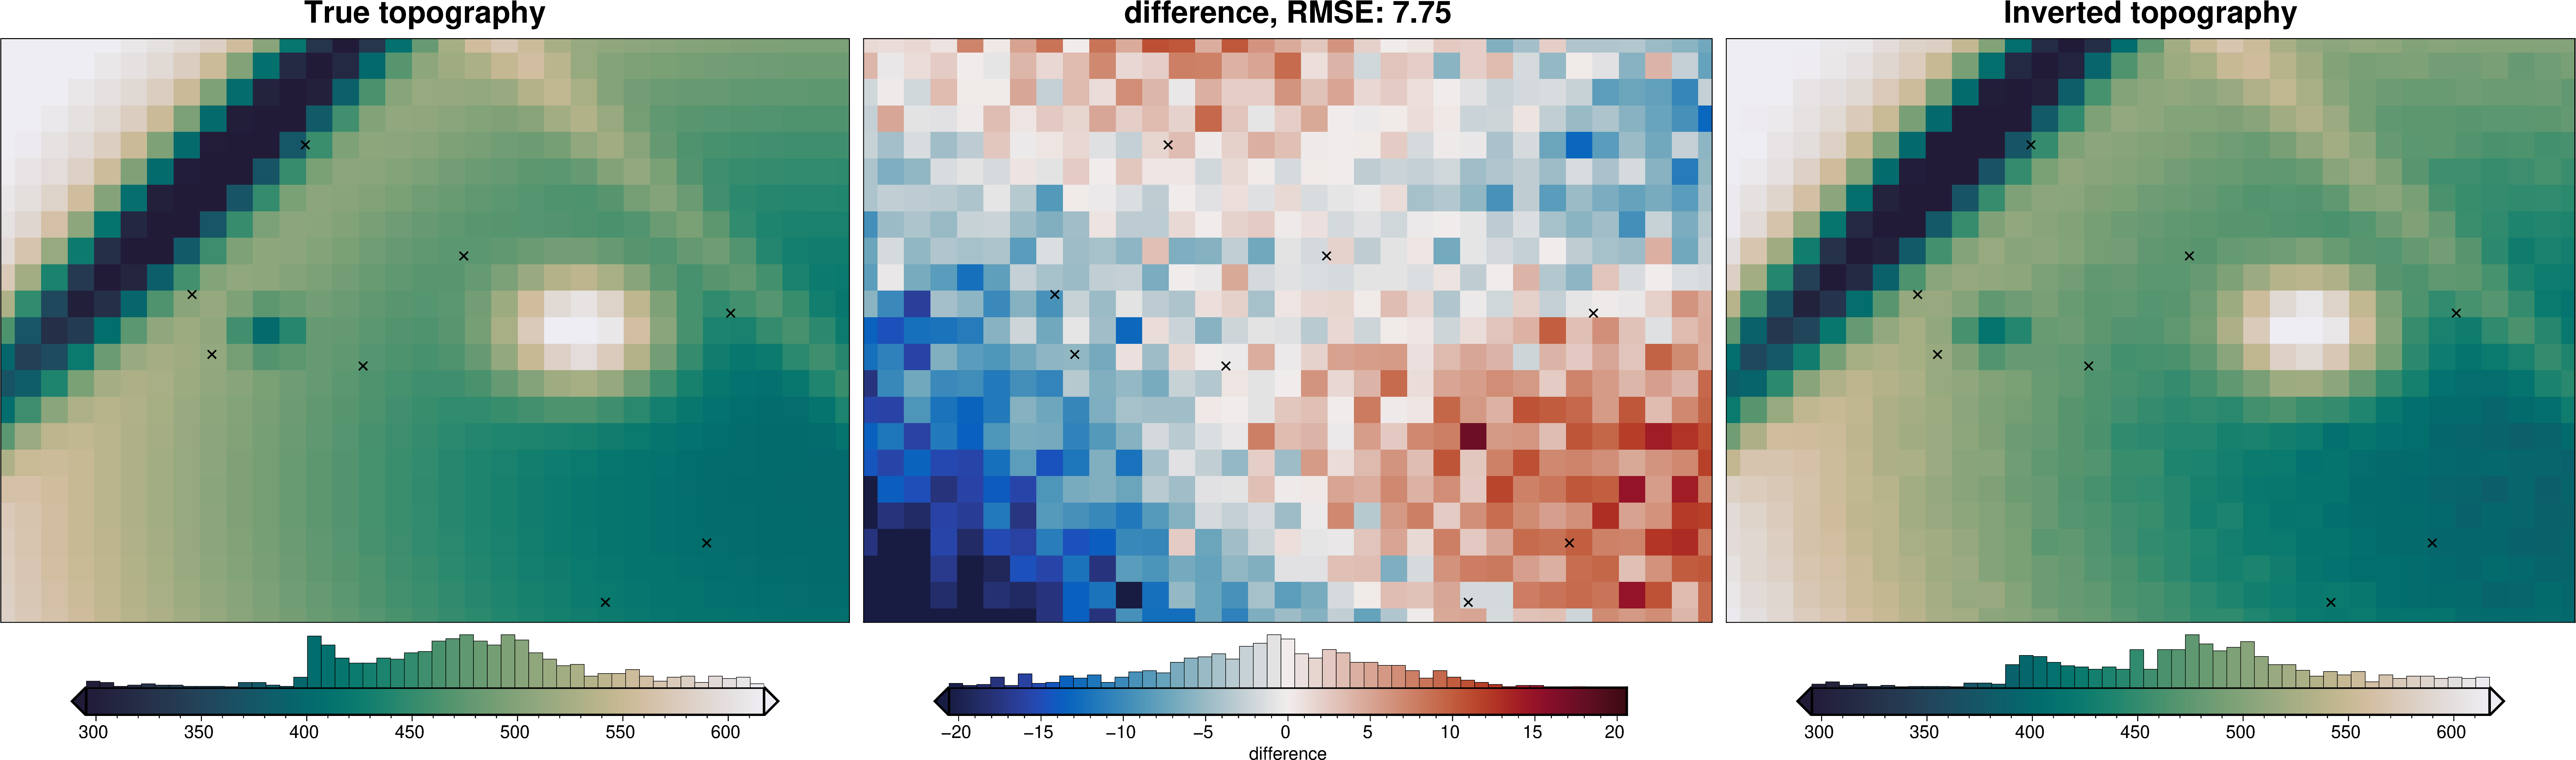

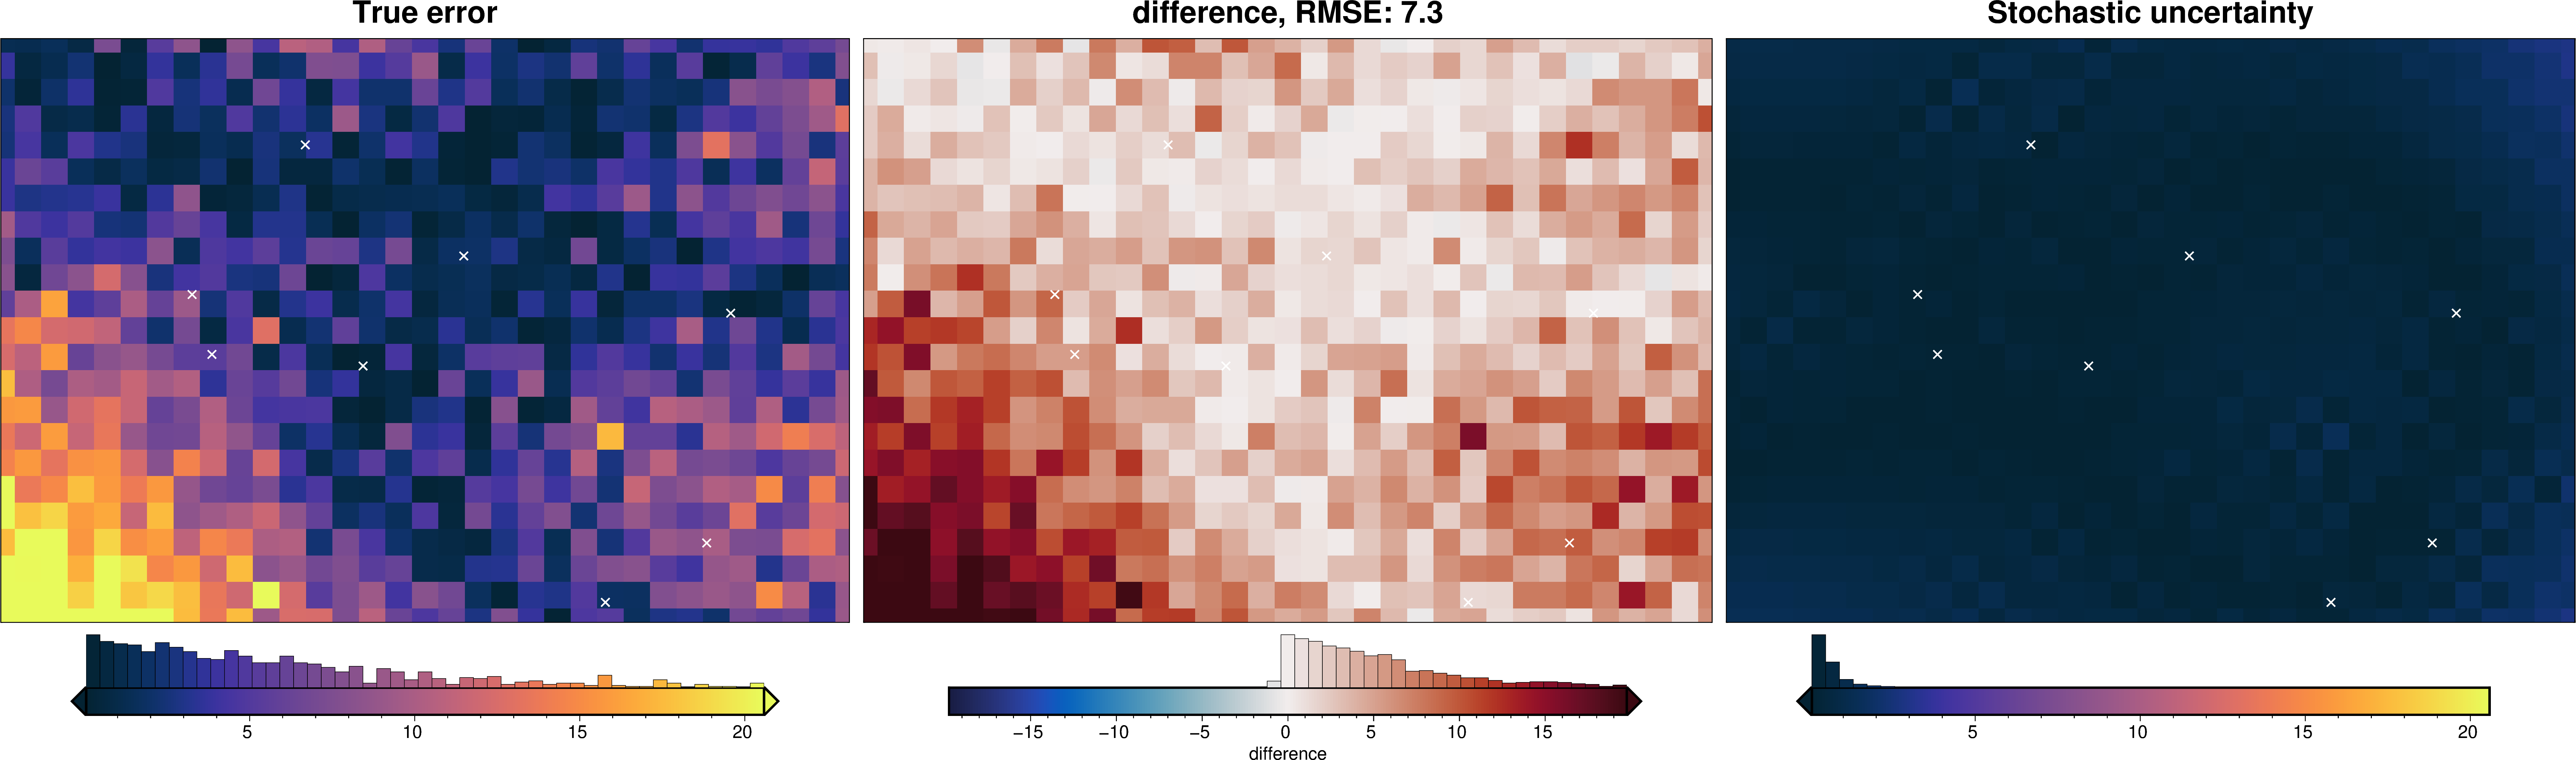

In [17]:
zref_dict = {
    "zref": {
        "distribution": "normal",
        "loc": inv.model.zref,
        "scale": zref_stdev,
    },
}
fname = "../tmp/10_uncertainty_zref"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_zref_results = invert4geom.full_workflow_uncertainty_loop(
    inv,
    fname=fname,
    runs=10,
    parameter_dict=zref_dict,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

stats_ds = uncert_plots(
    uncert_zref_results,
    inv.data.inner_region,
    inv.data.spacing,
    true_topography,
    constraints_df=constraints_df,
    weight_by="constraints",
)

### Constraints component

stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

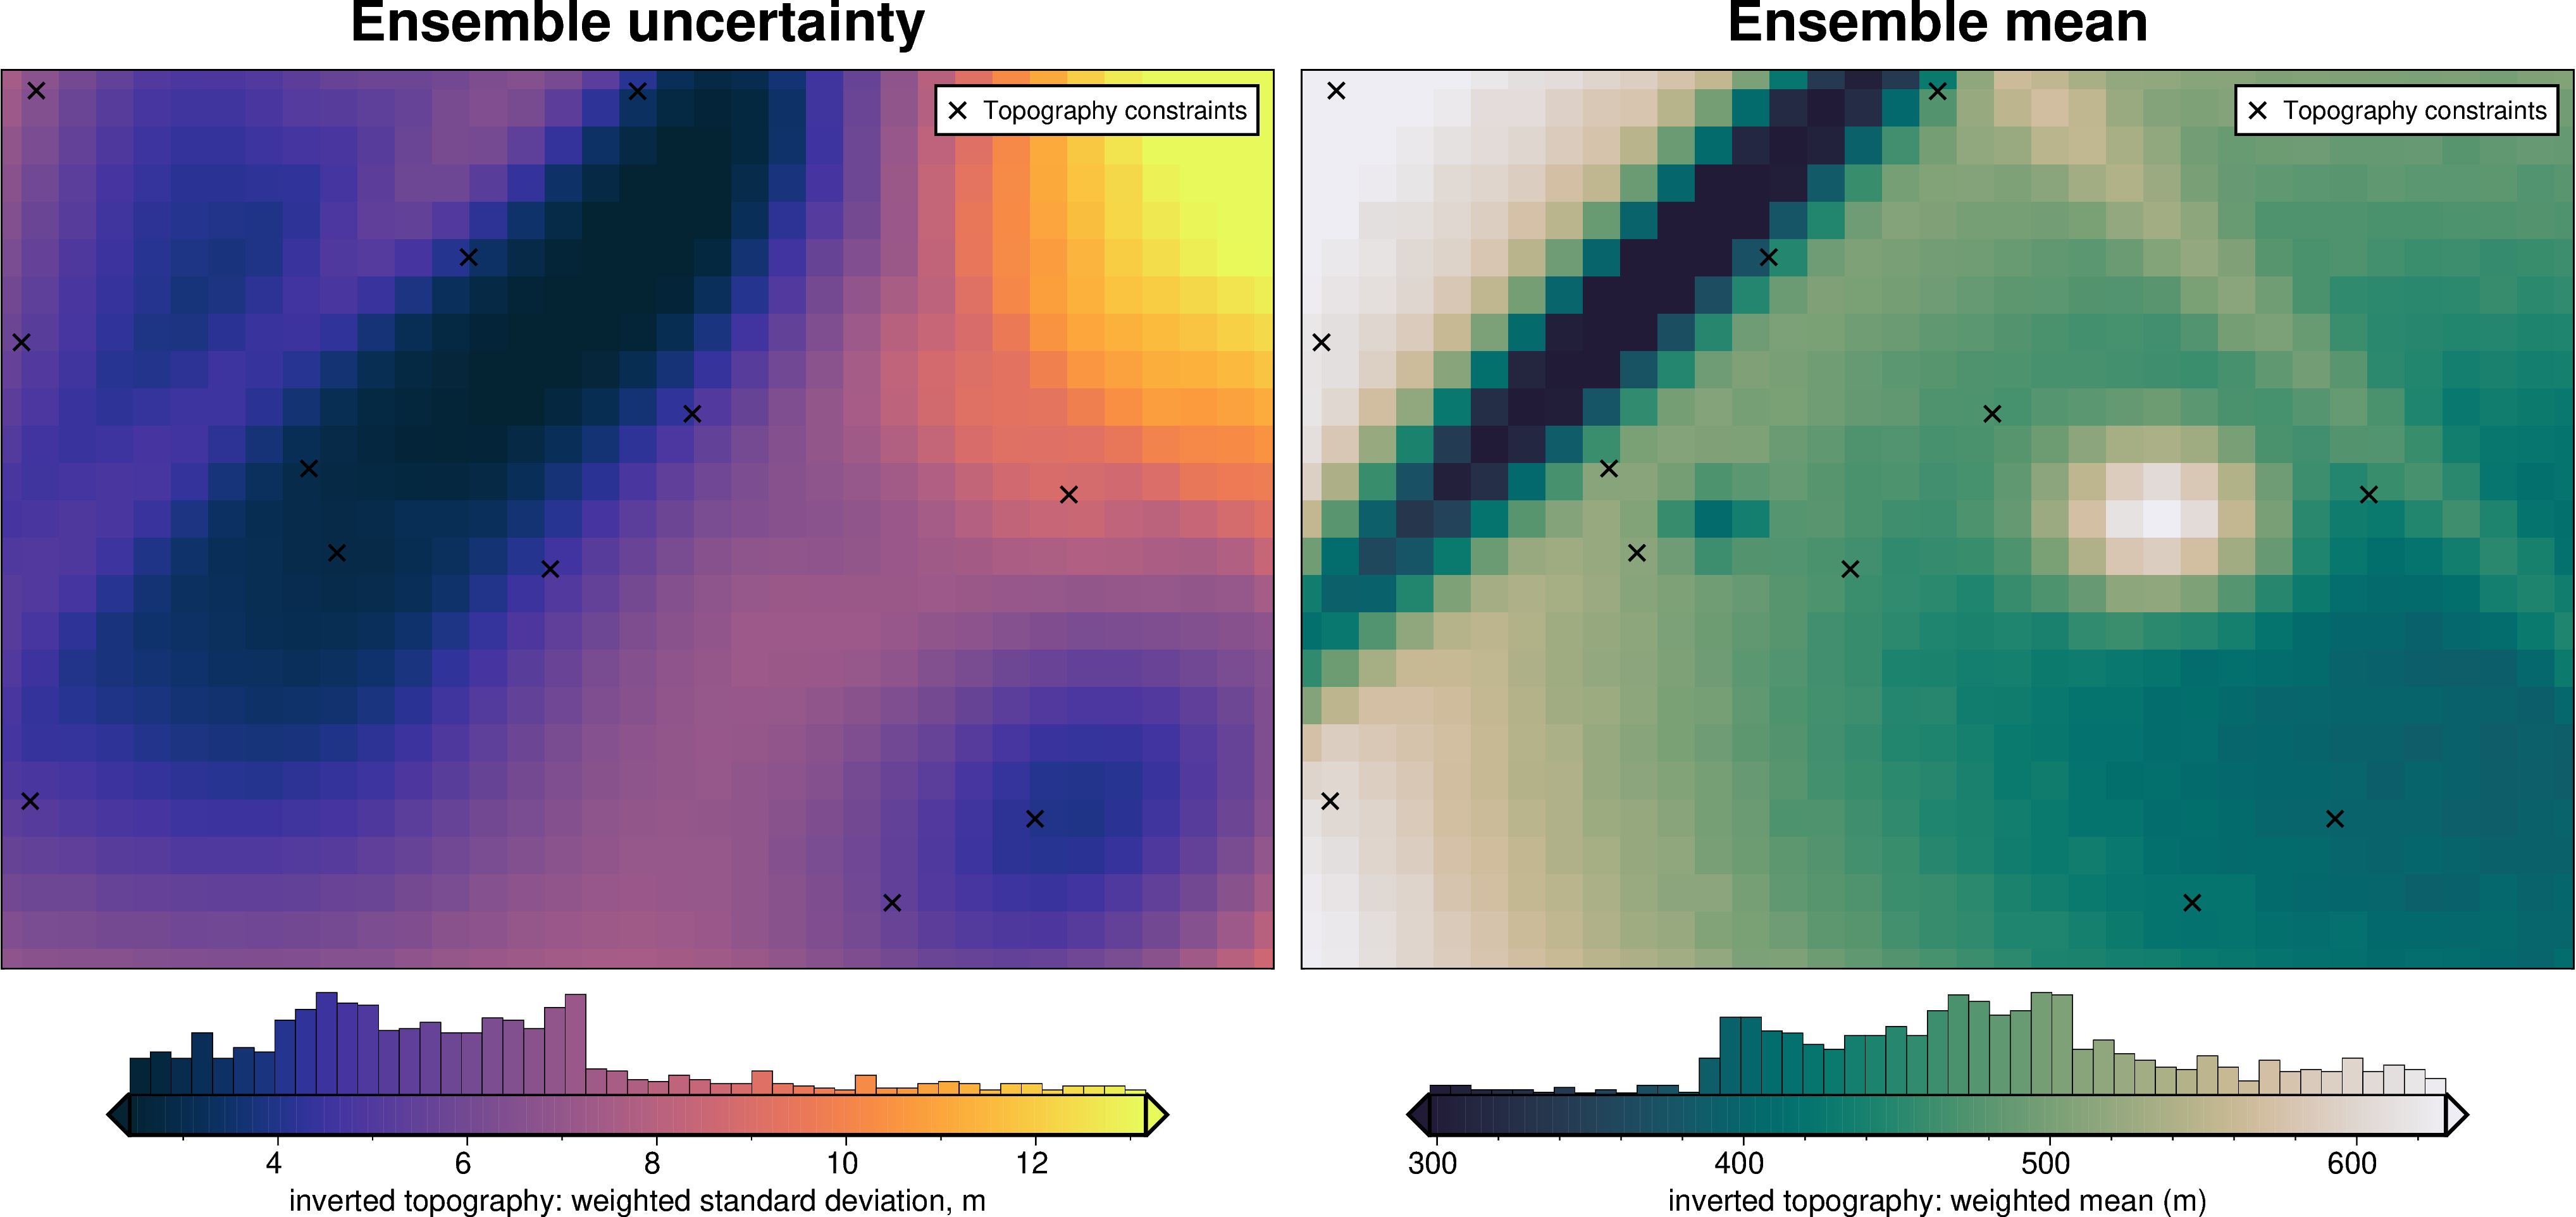

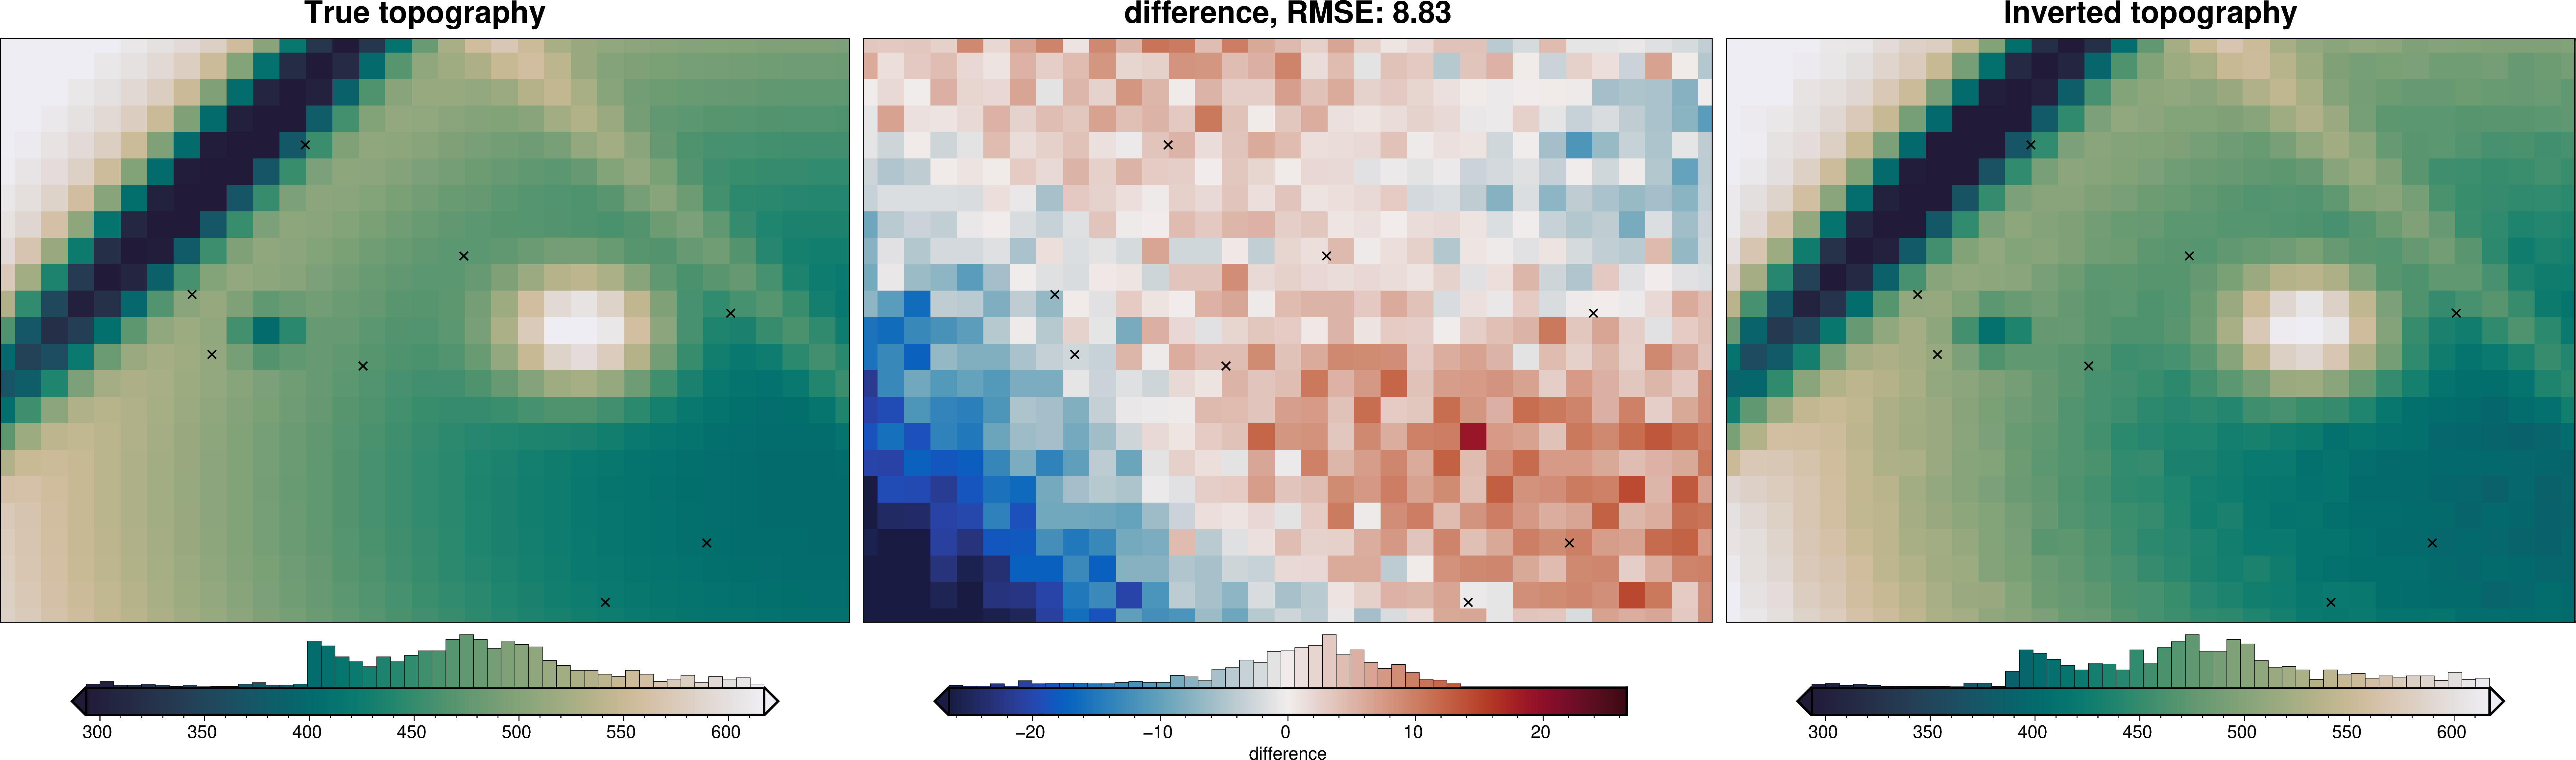

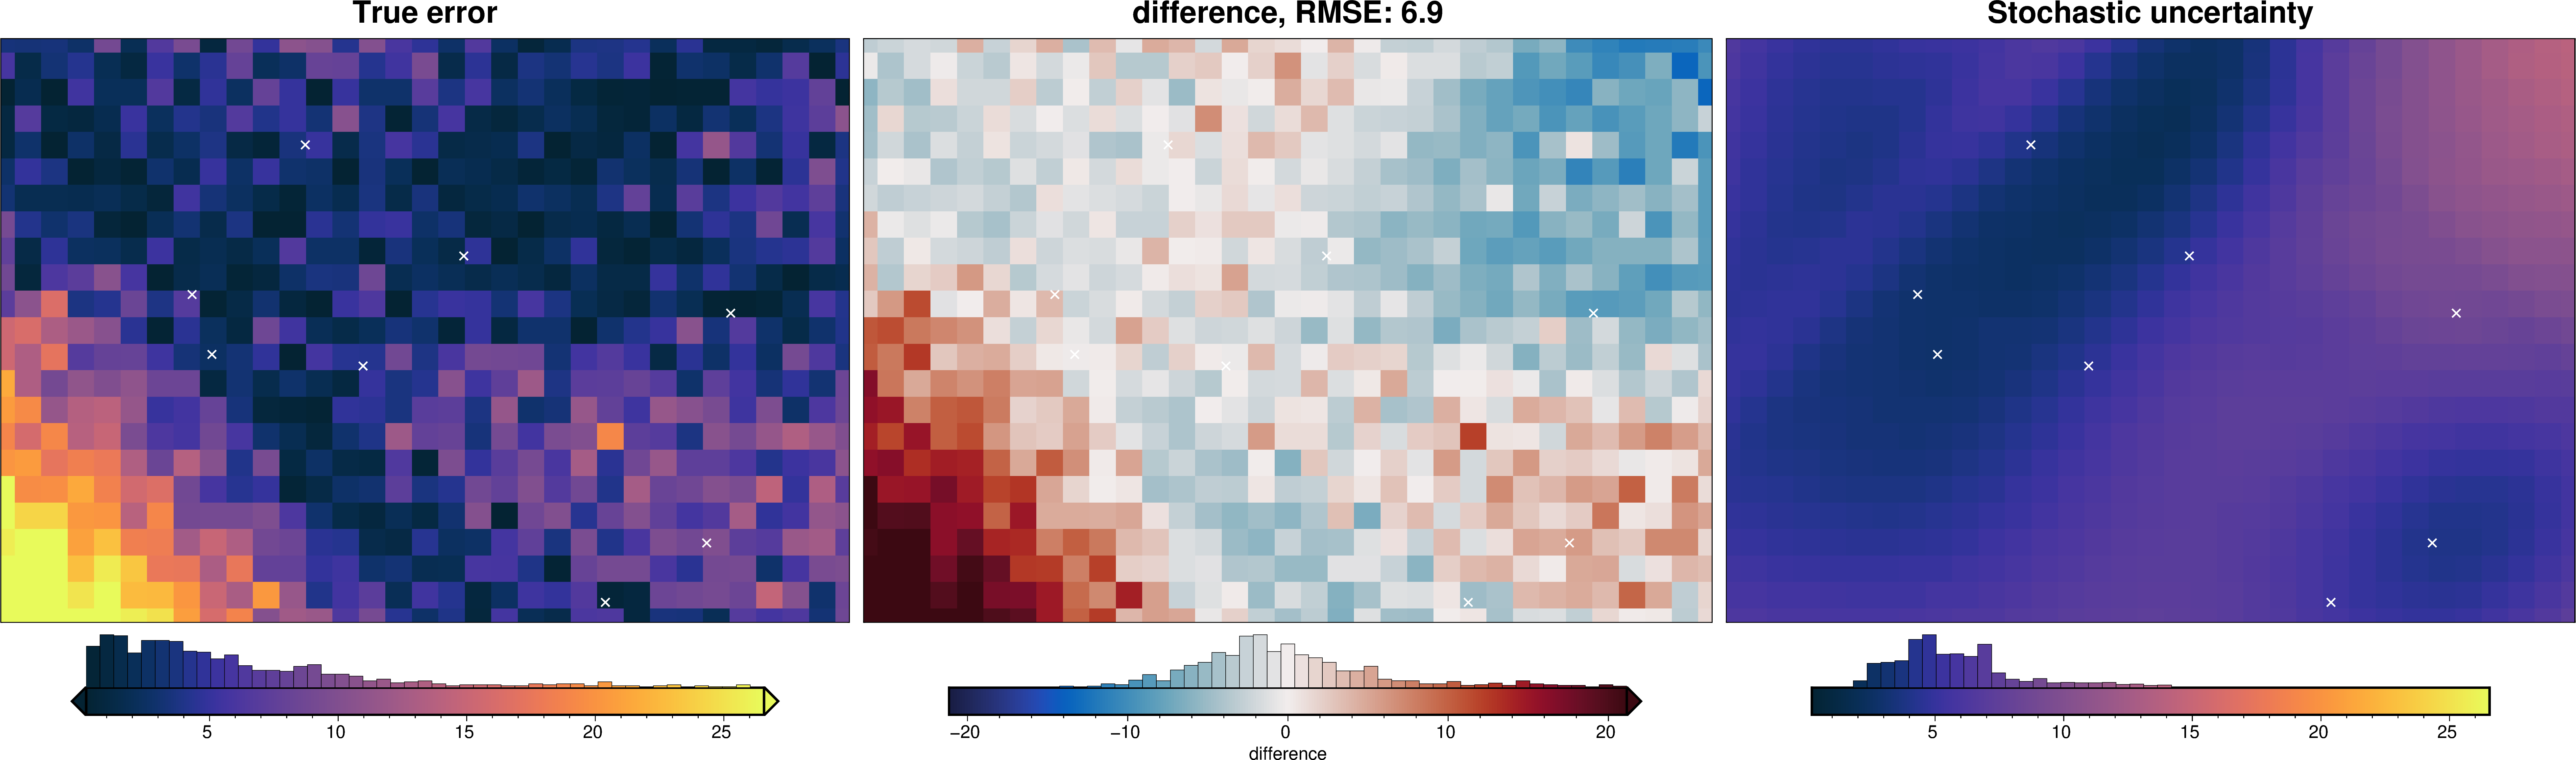

In [18]:
fname = "../tmp/10_uncertainty_constraints"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_constraints_results = invert4geom.full_workflow_uncertainty_loop(
    inv,
    fname=fname,
    sample_constraints=True,
    constraints_df=constraints_df,
    runs=10,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

stats_ds = uncert_plots(
    uncert_constraints_results,
    inv.data.inner_region,
    inv.data.spacing,
    true_topography,
    constraints_df=constraints_df,
    weight_by="constraints",
)

### Gravity component

stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

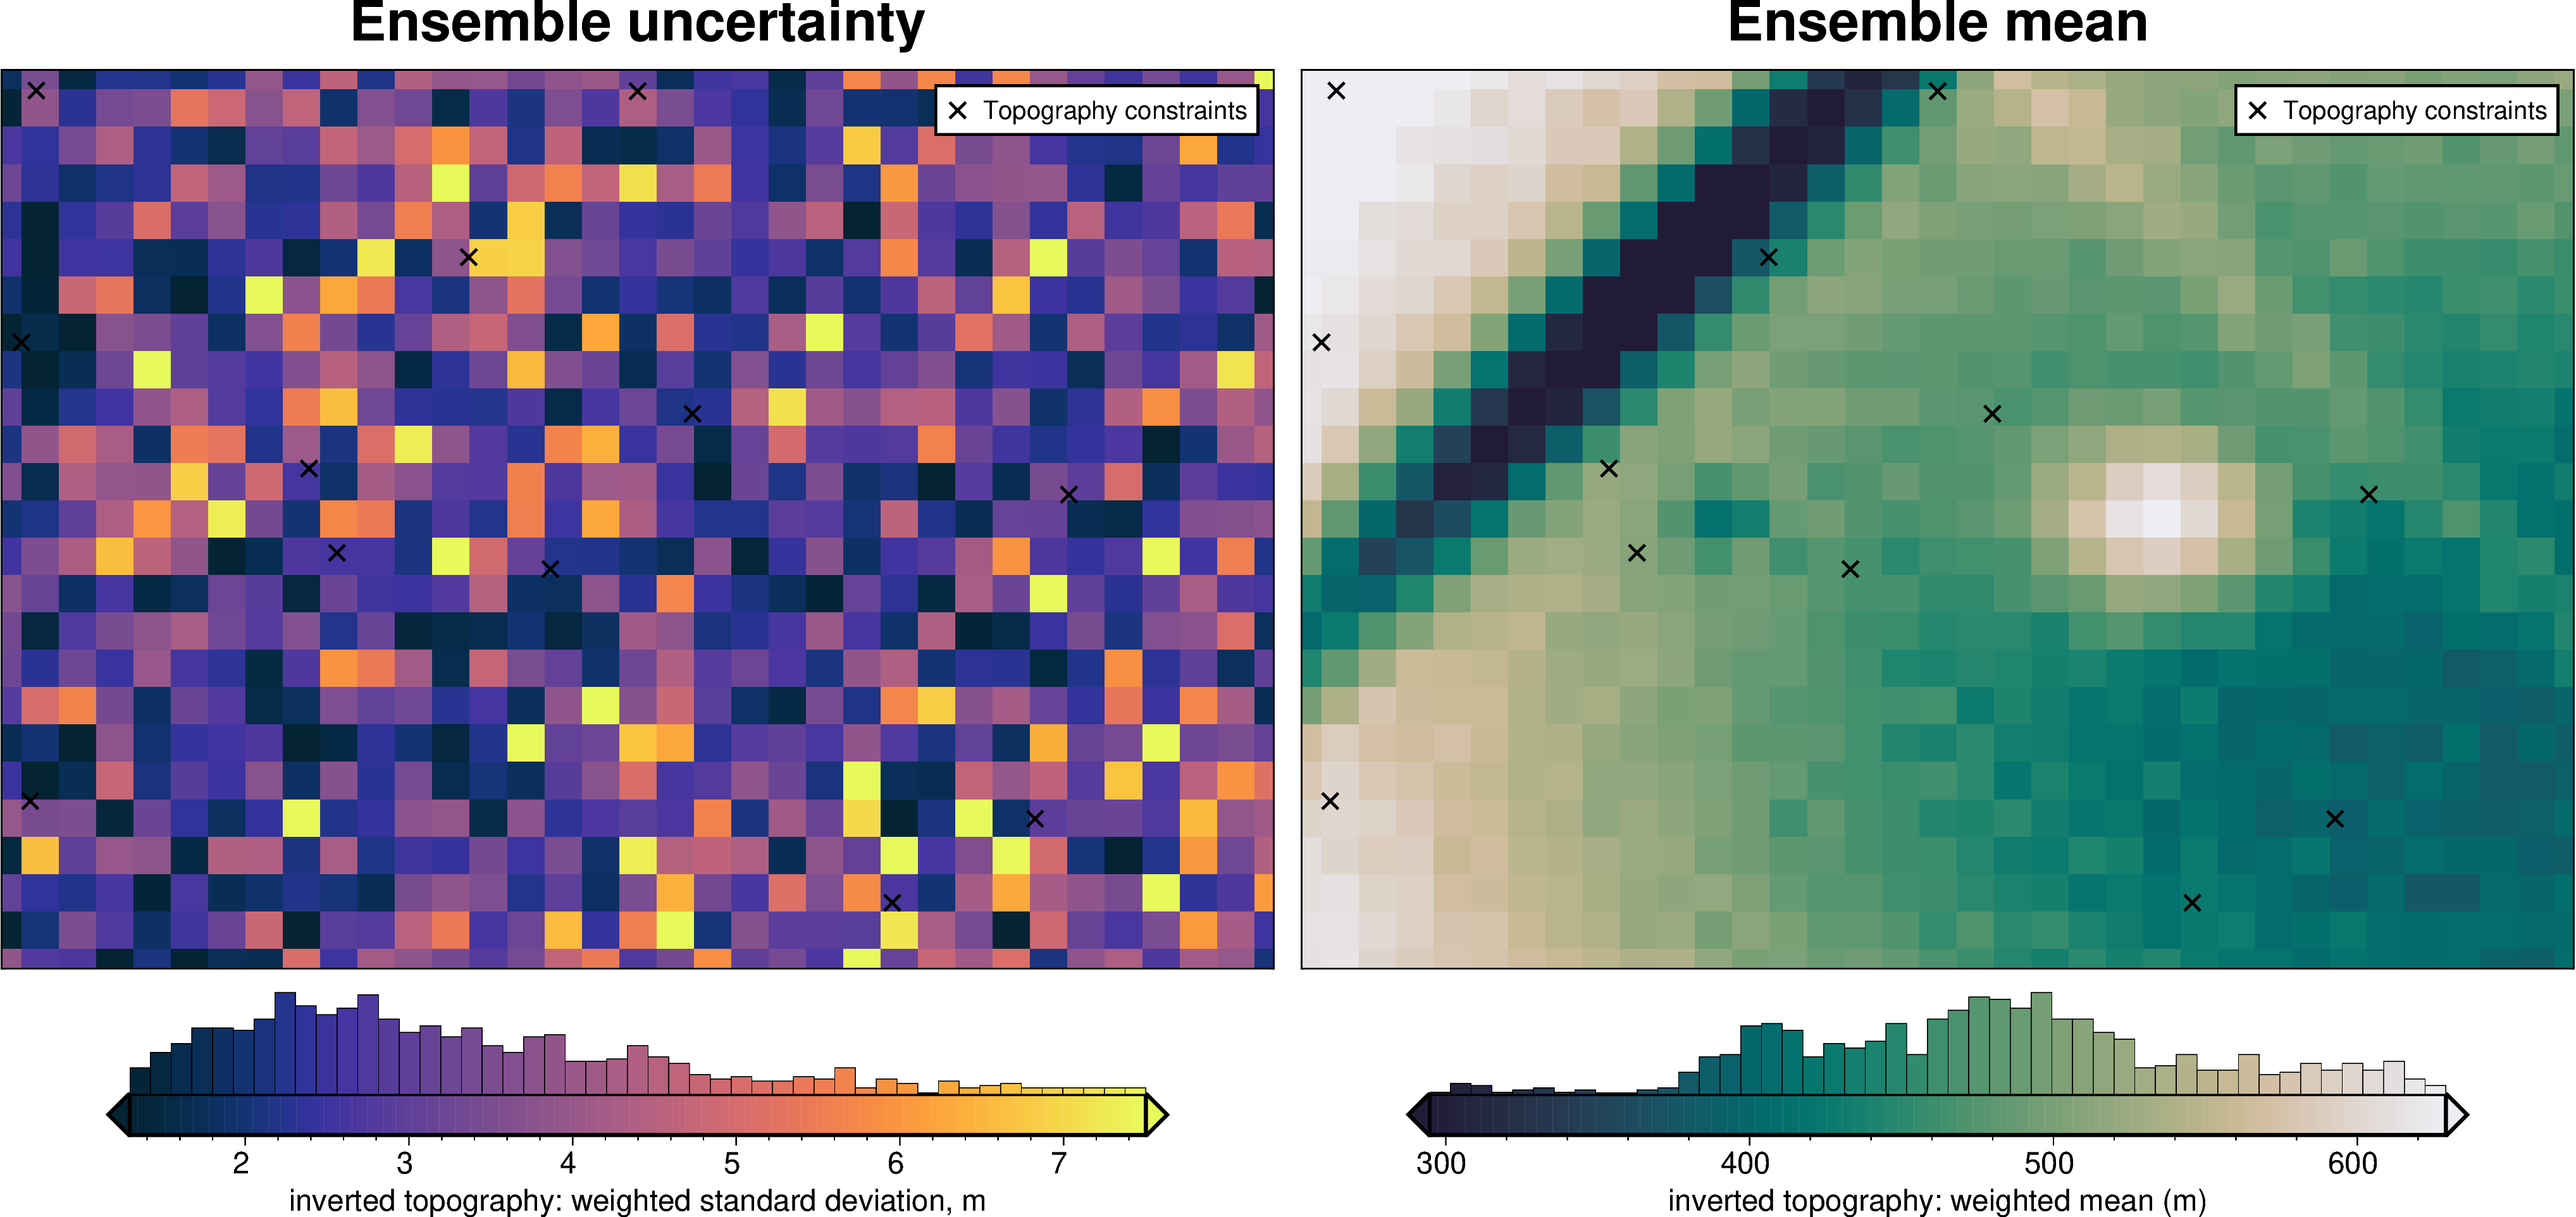

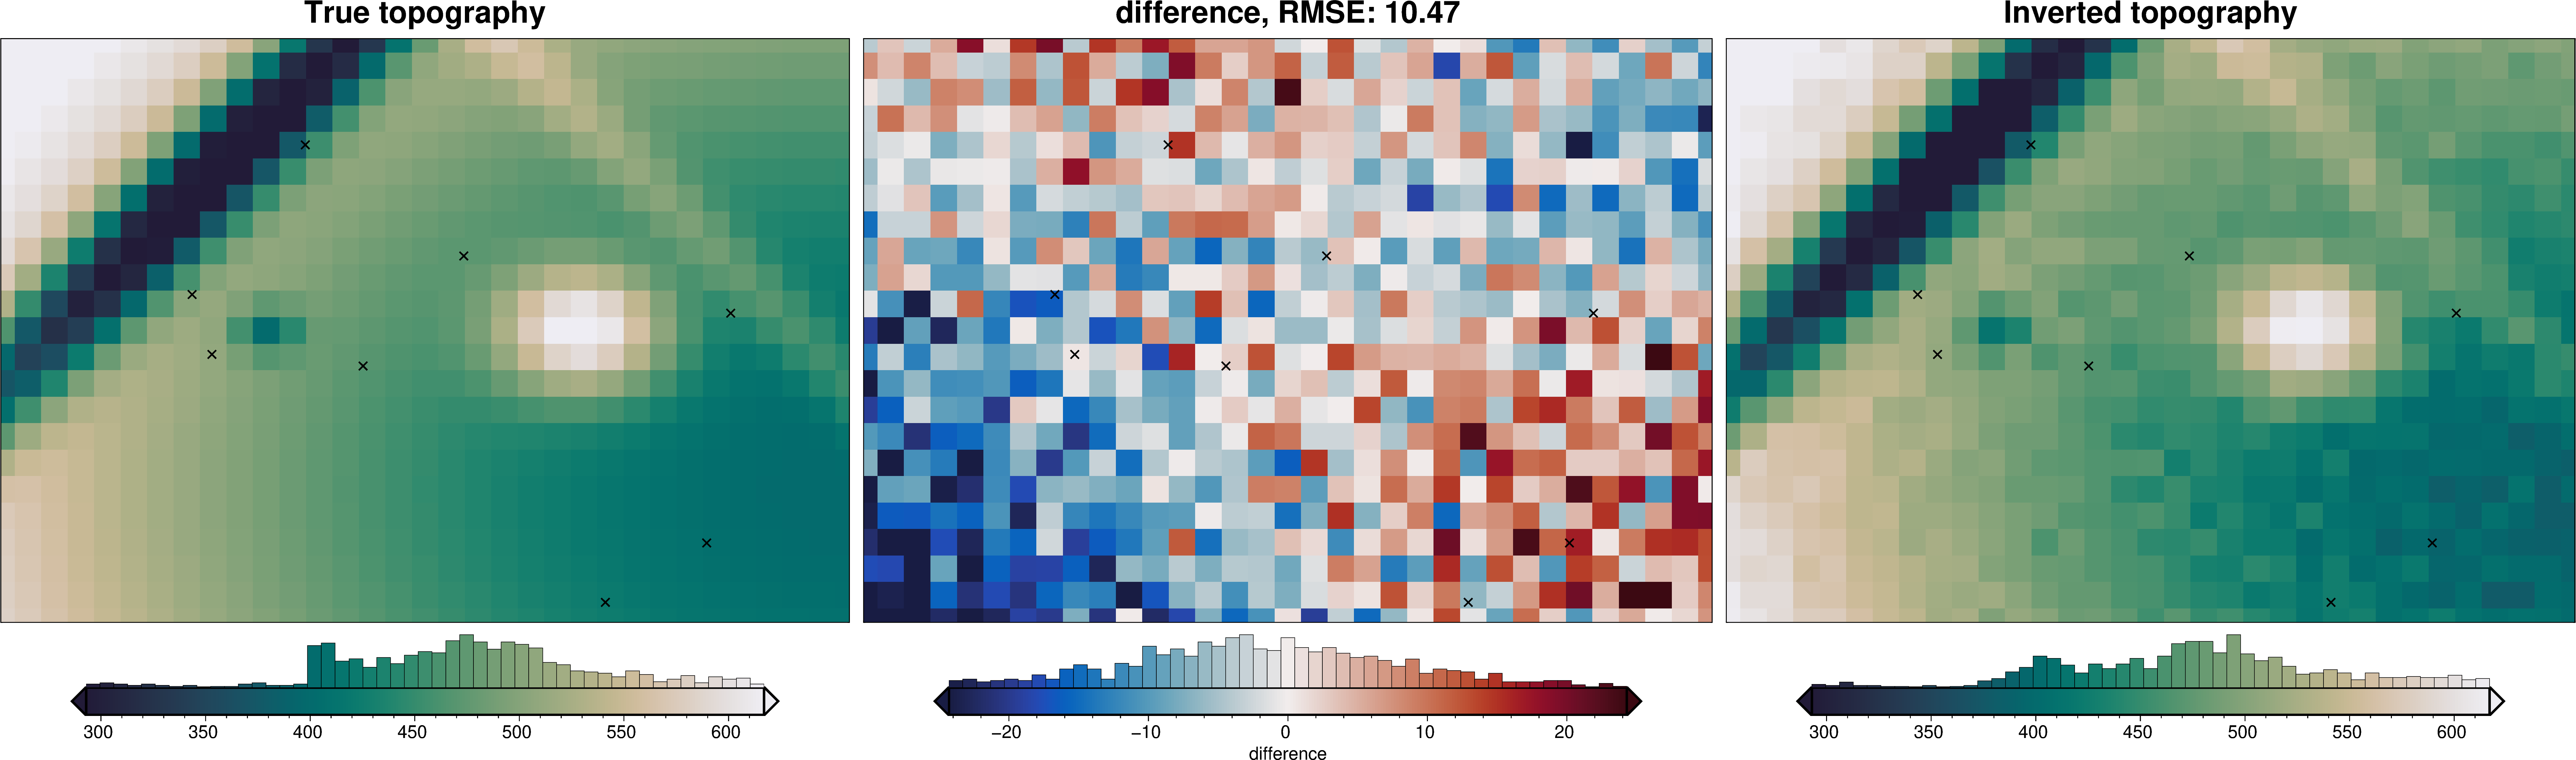

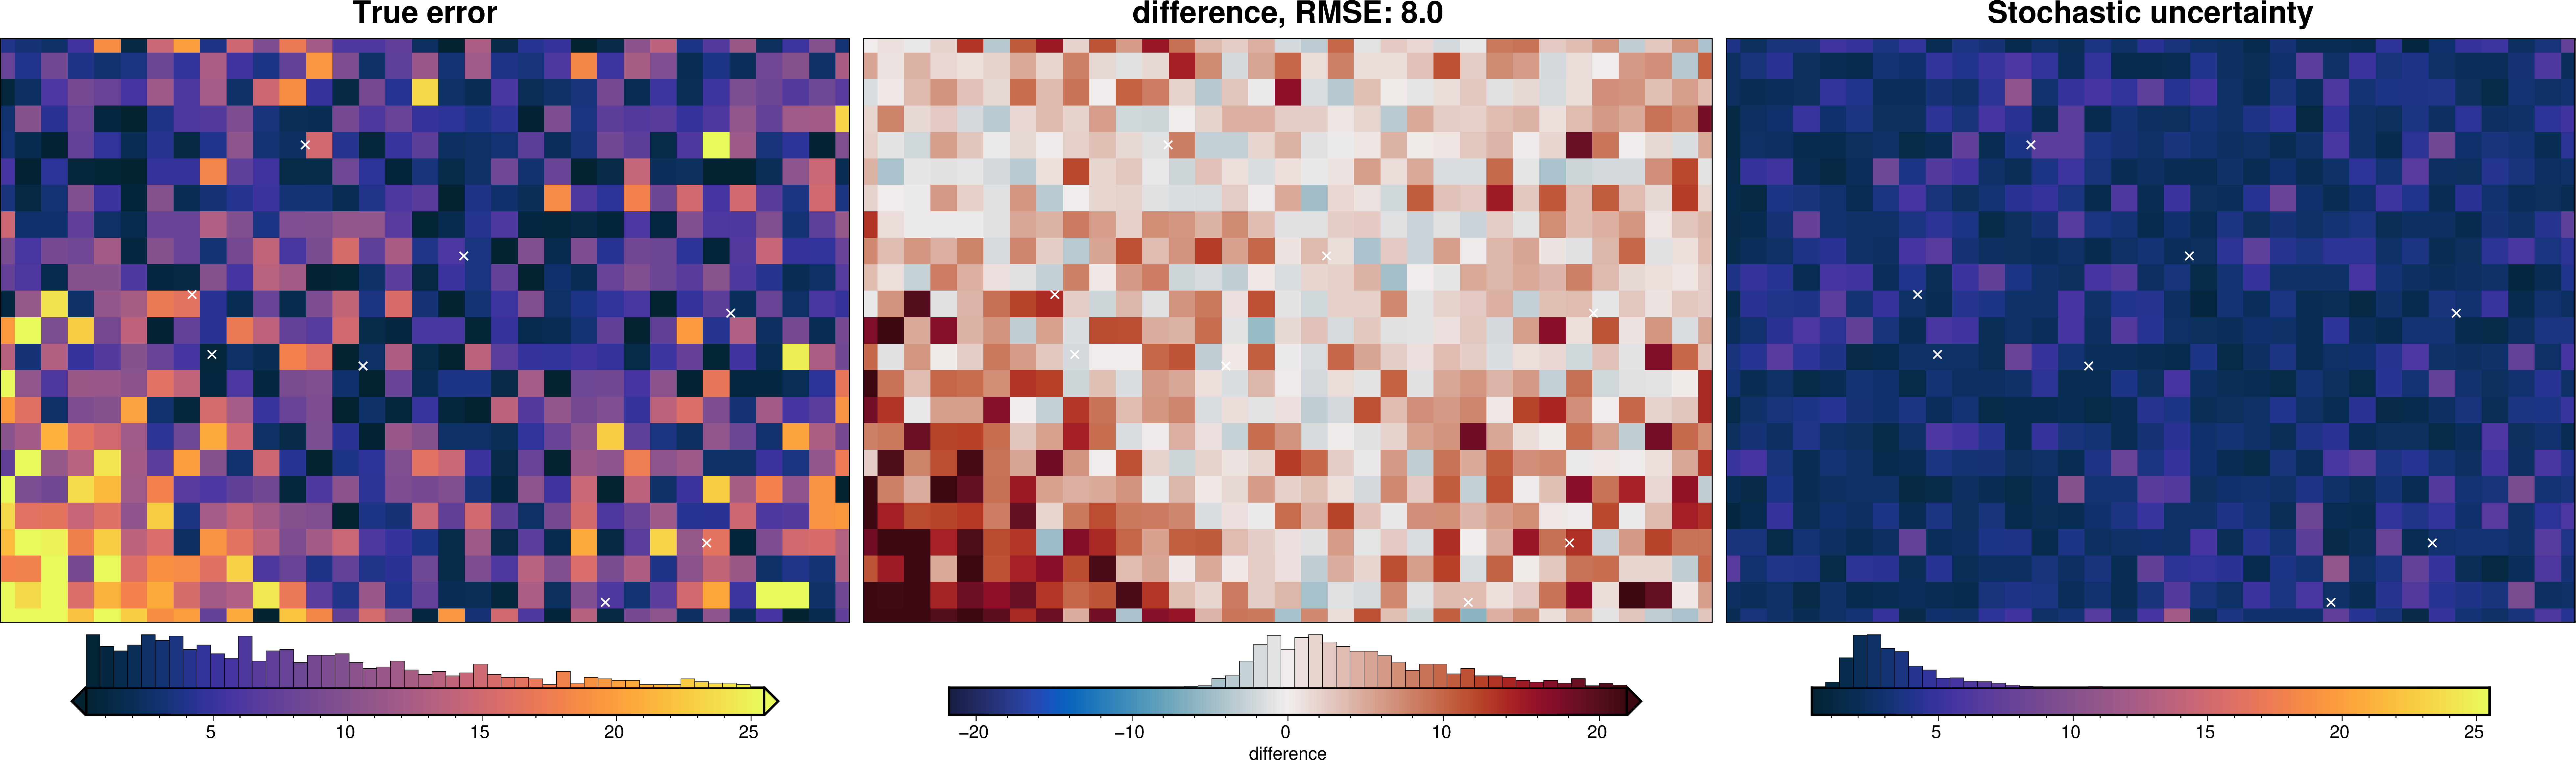

In [19]:
fname = "../tmp/10_uncertainty_grav"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_grav_results = invert4geom.full_workflow_uncertainty_loop(
    inv,
    fname=fname,
    runs=10,
    sample_gravity=True,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

stats_ds = uncert_plots(
    uncert_grav_results,
    inv.data.inner_region,
    inv.data.spacing,
    true_topography,
    constraints_df=constraints_df,
    weight_by="constraints",
)

### Regional gravity component

In [20]:
reg_eq_depth, reg_eq_damping

(np.float64(25196.204289908077), 0.048090793172362284)

In [21]:
np.abs(np.log10(reg_eq_damping))

np.float64(1.3179380599497026)

starting regional ensemble:   0%|          | 0/100 [00:00<?, ?it/s]

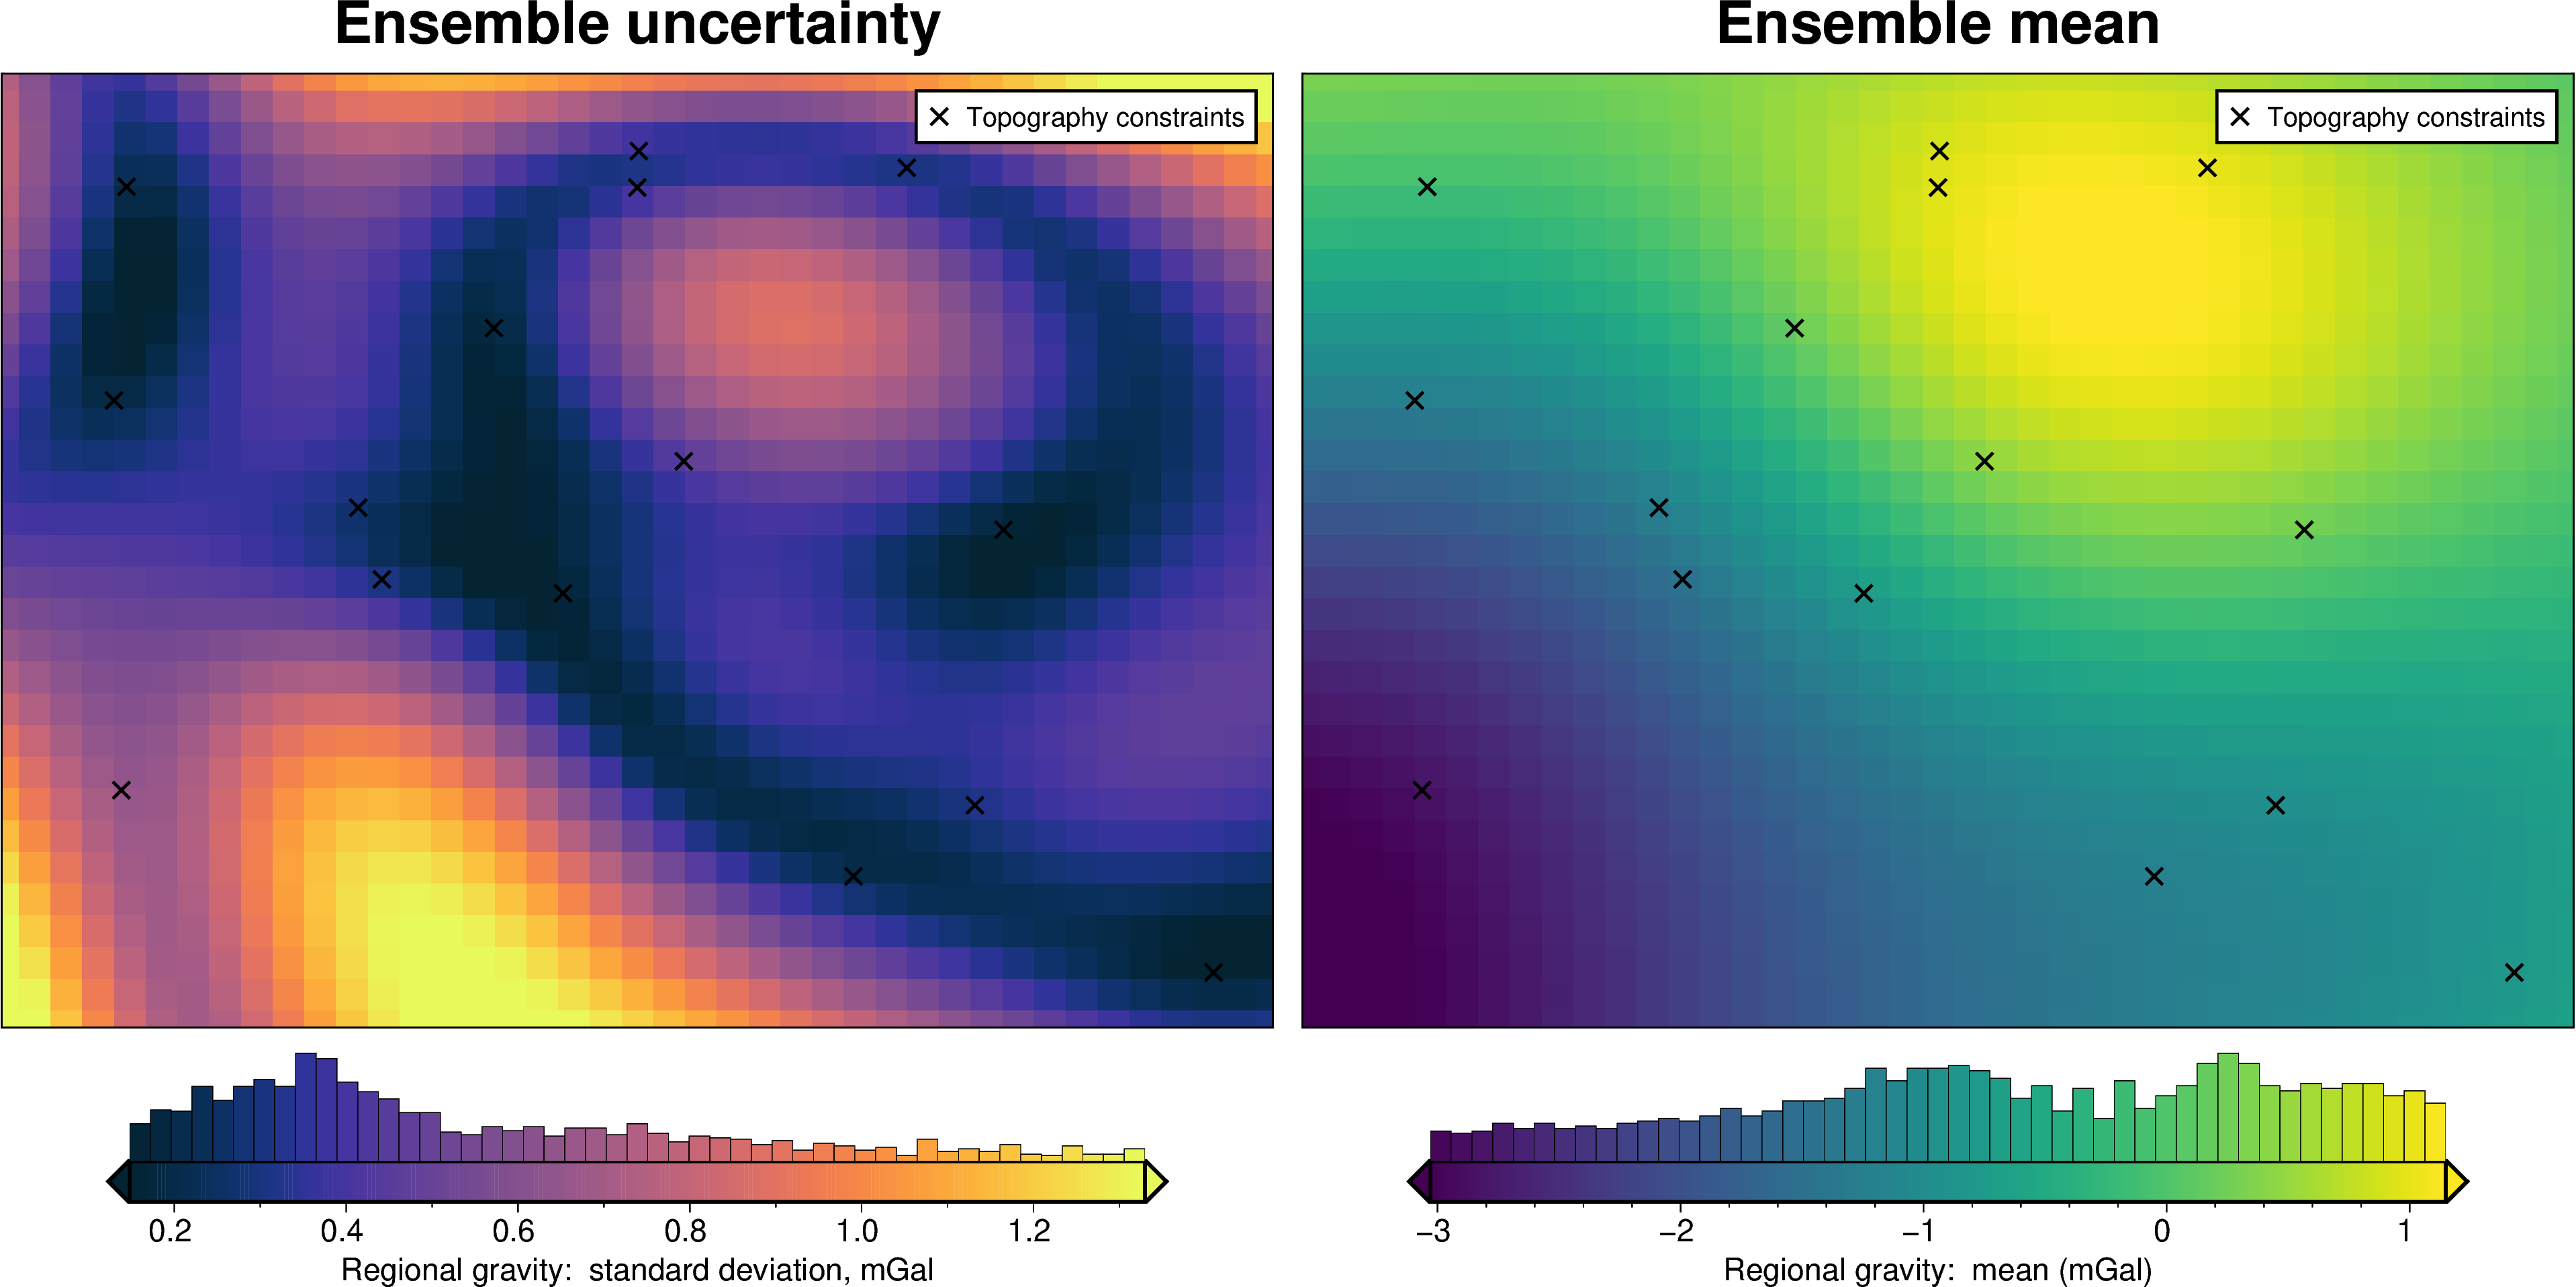

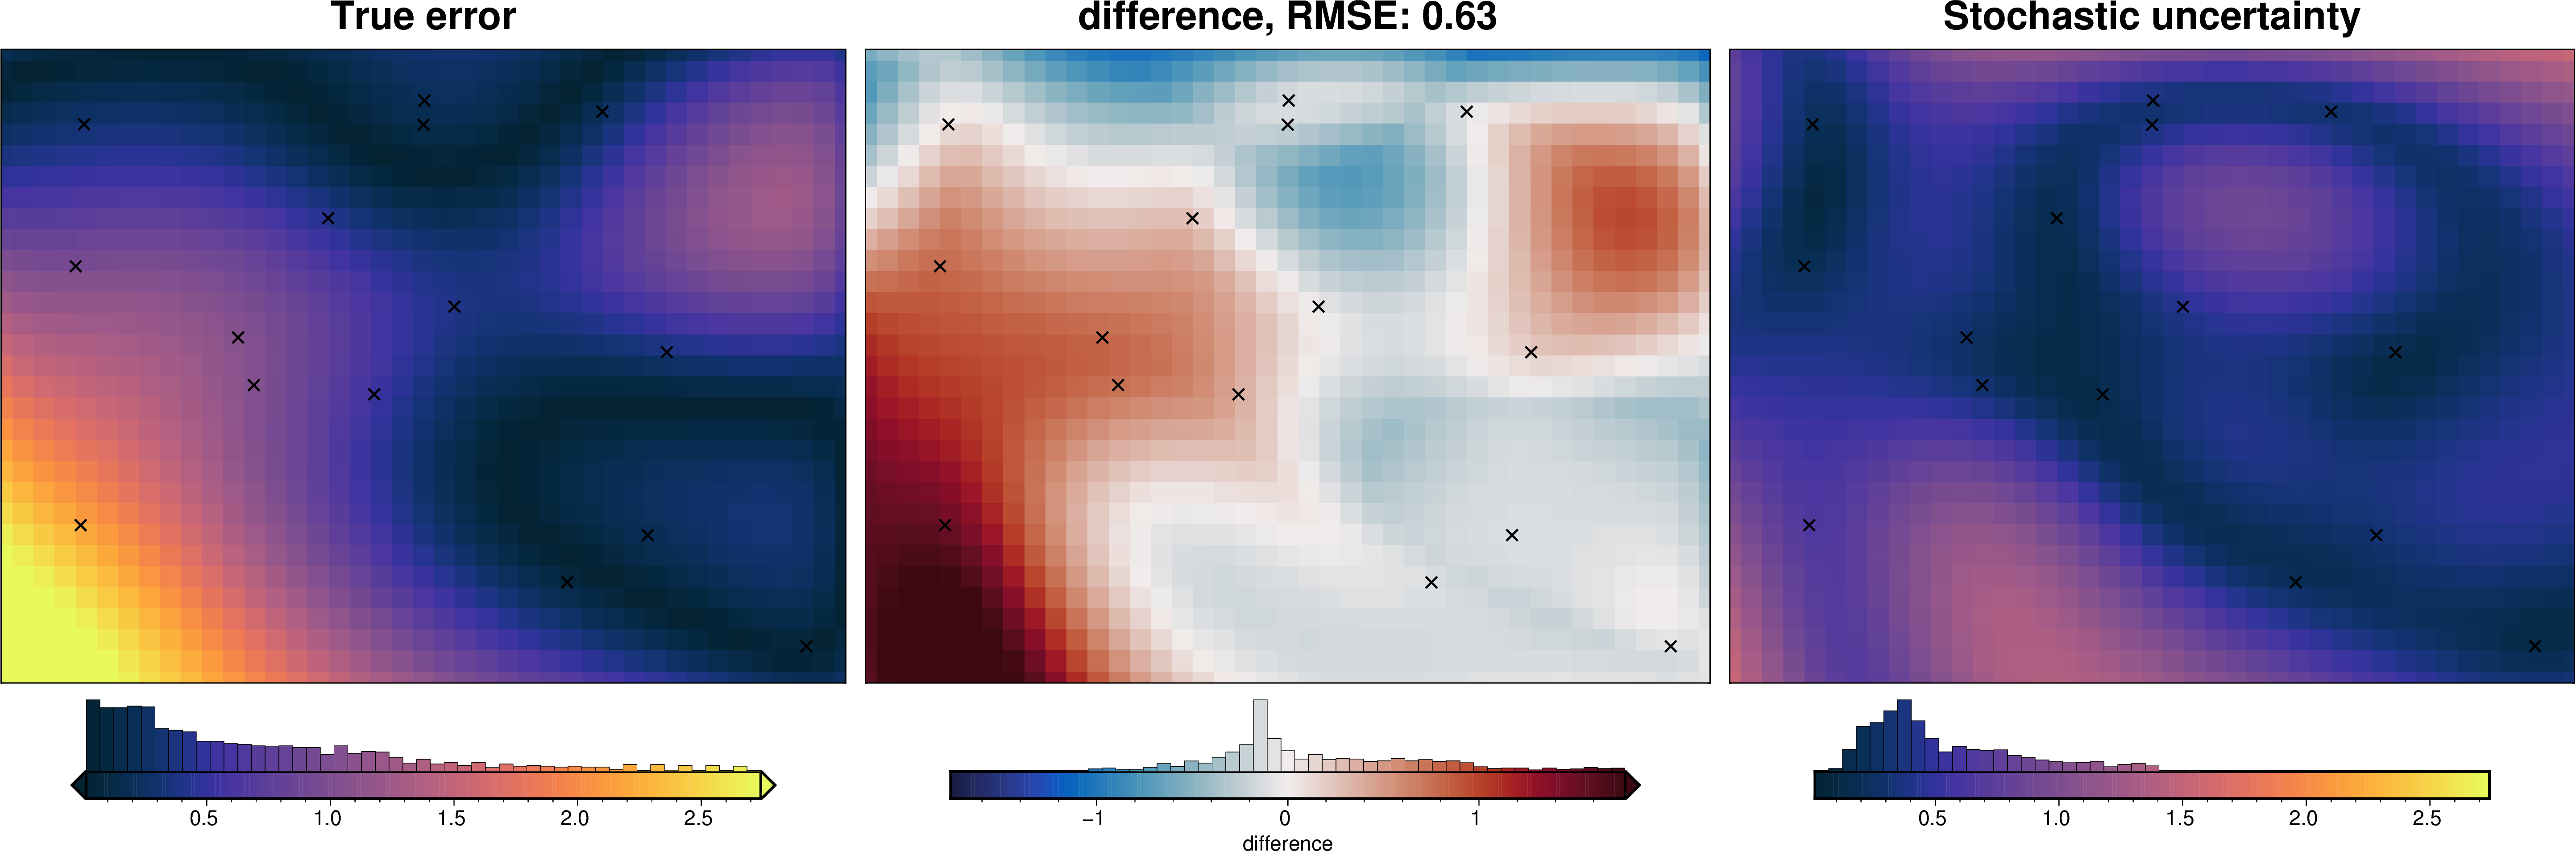

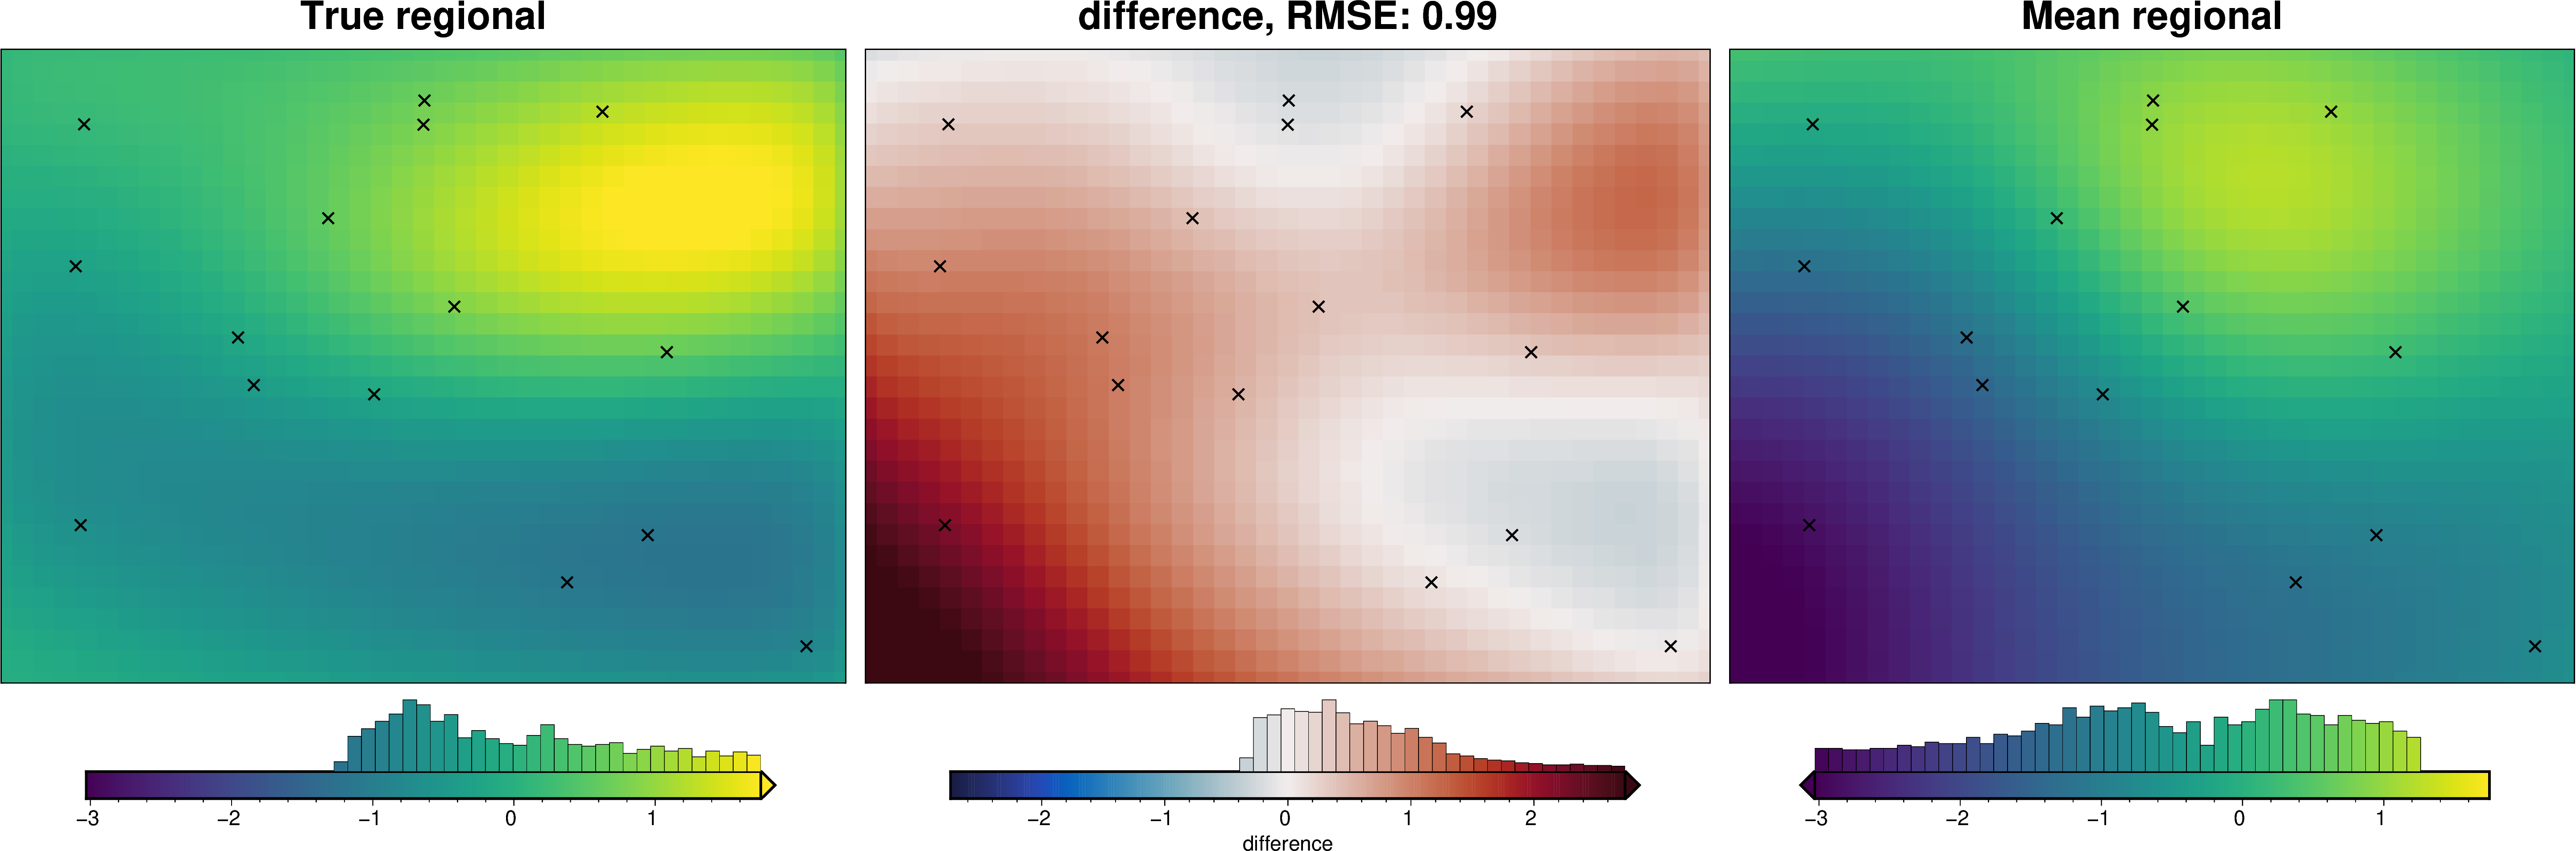

In [22]:
regional_misfit_parameter_dict = {
    "depth": {
        "distribution": "normal",
        "loc": reg_eq_depth,  # mean
        "scale": reg_eq_depth / 10,  # standard deviation
    },
    "damping": {
        "distribution": "normal",
        "loc": np.log10(reg_eq_damping),  # mean base 10 exponent
        # "scale": np.abs(np.log10(reg_eq_damping)),  # standard deviation of exponent
        "scale": 2,
        "log": True,
    },
}

regional_misfit_stats, _ = invert4geom.regional_misfit_uncertainty(
    runs=100,
    parameter_dict=regional_misfit_parameter_dict,
    true_regional=inv.data.lower_surface_grav,
    # weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
    grav_ds=inv.data,
    **new_regional_grav_kwargs,
)

In [23]:
# update grav dataset
inv.data["reg_uncert"] = regional_misfit_stats.z_stdev

stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

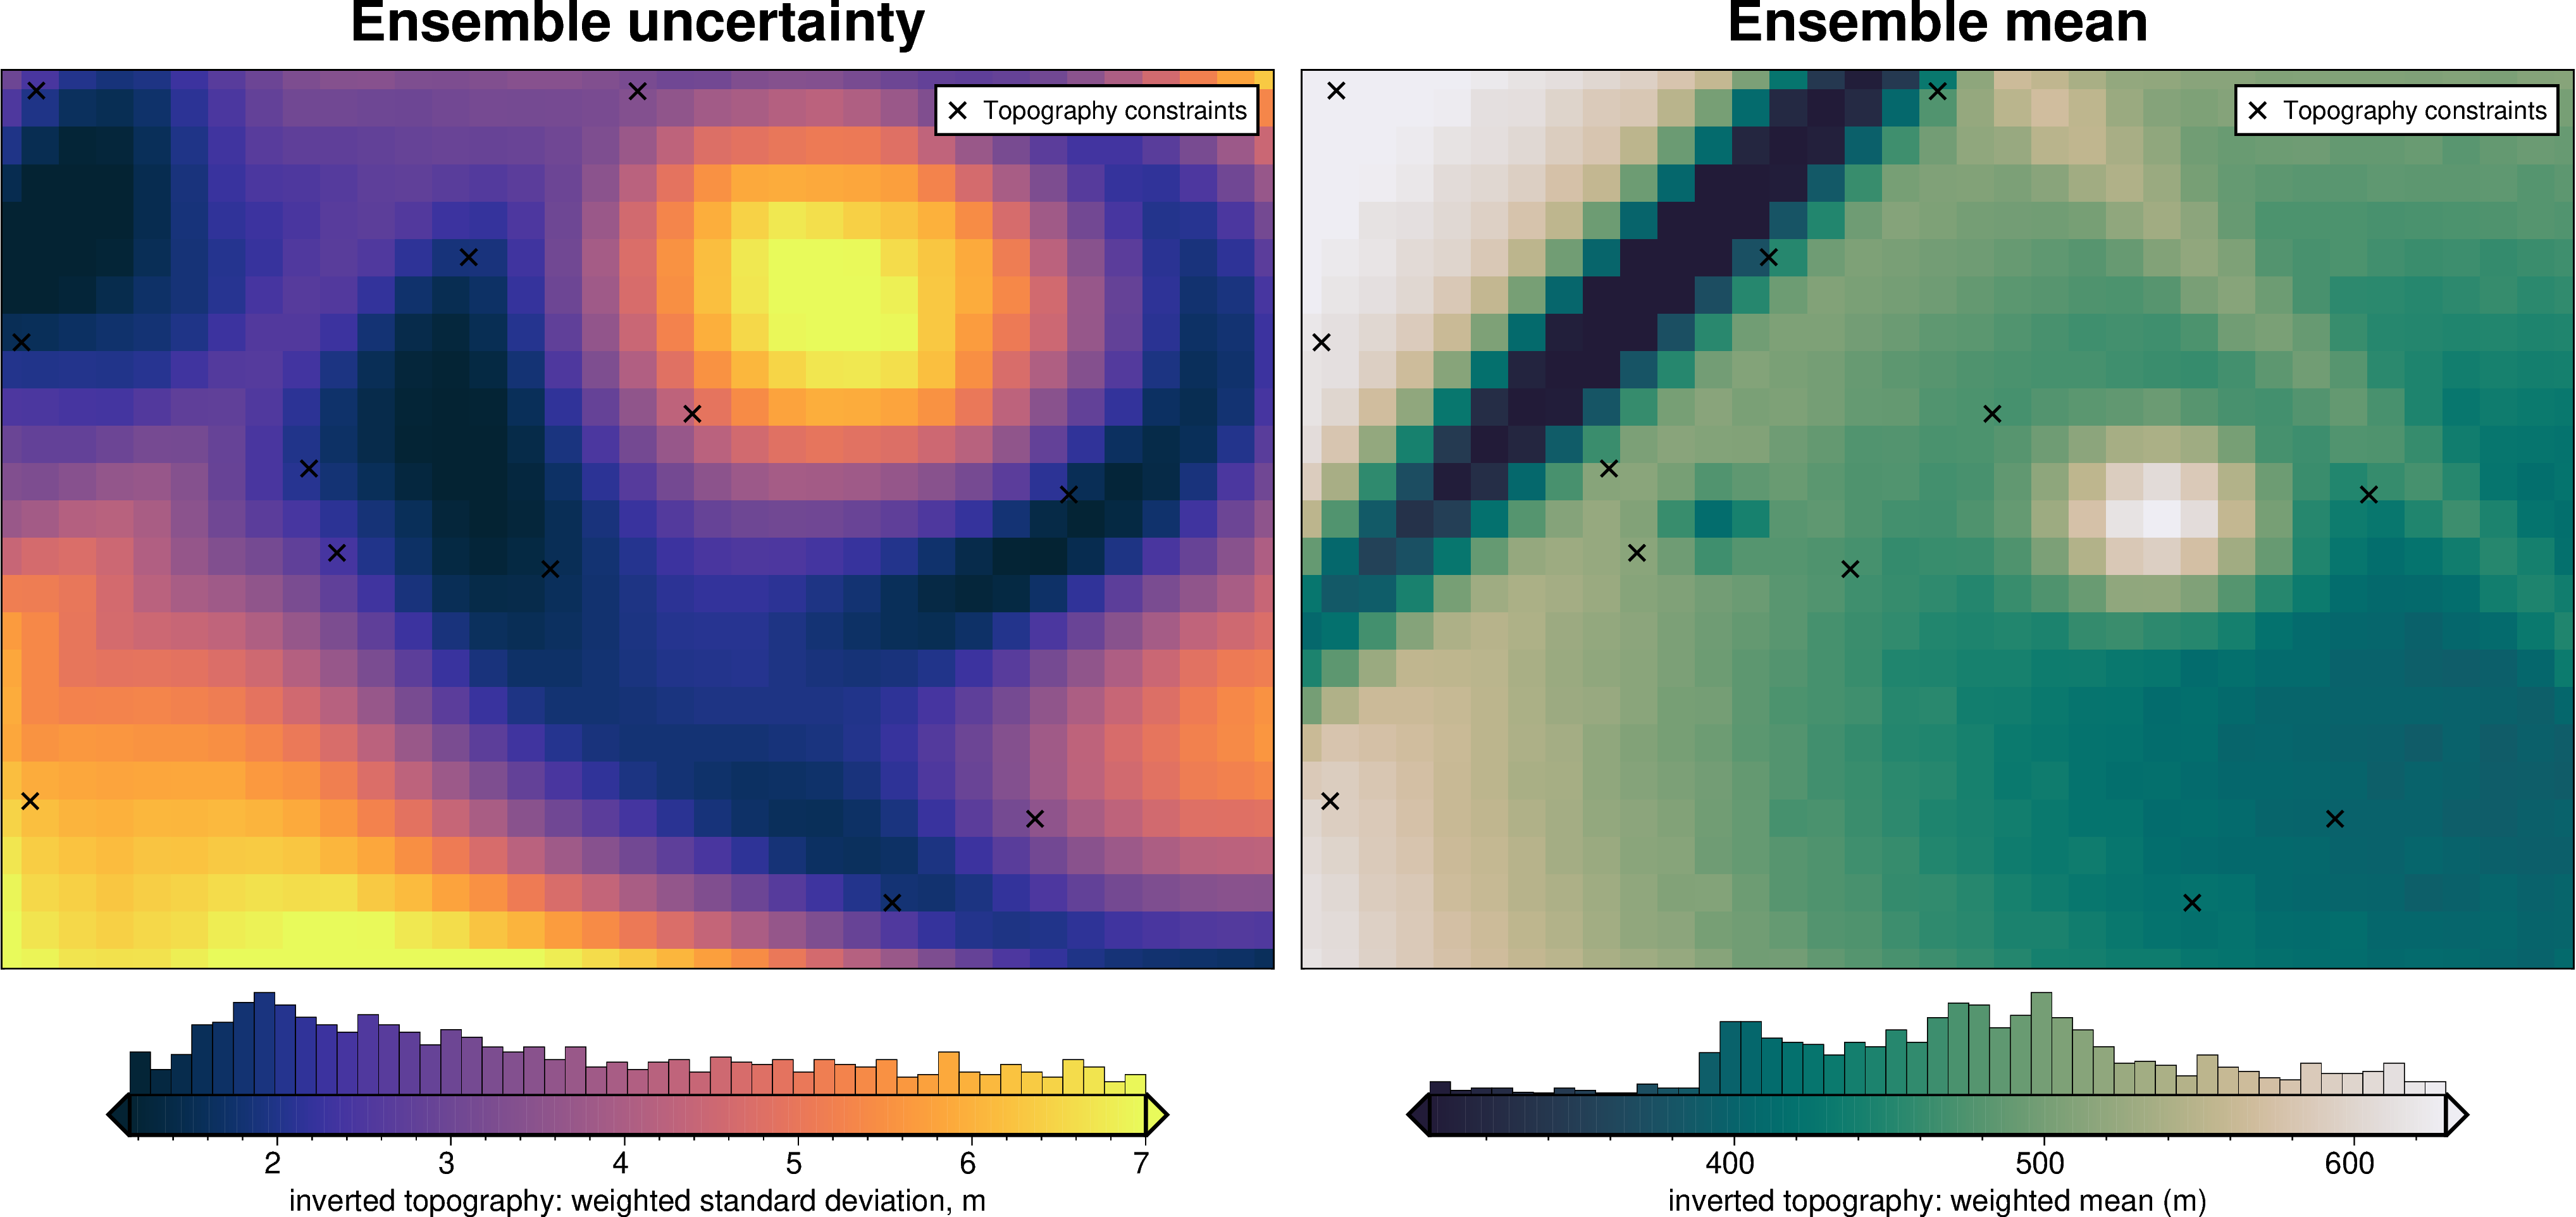

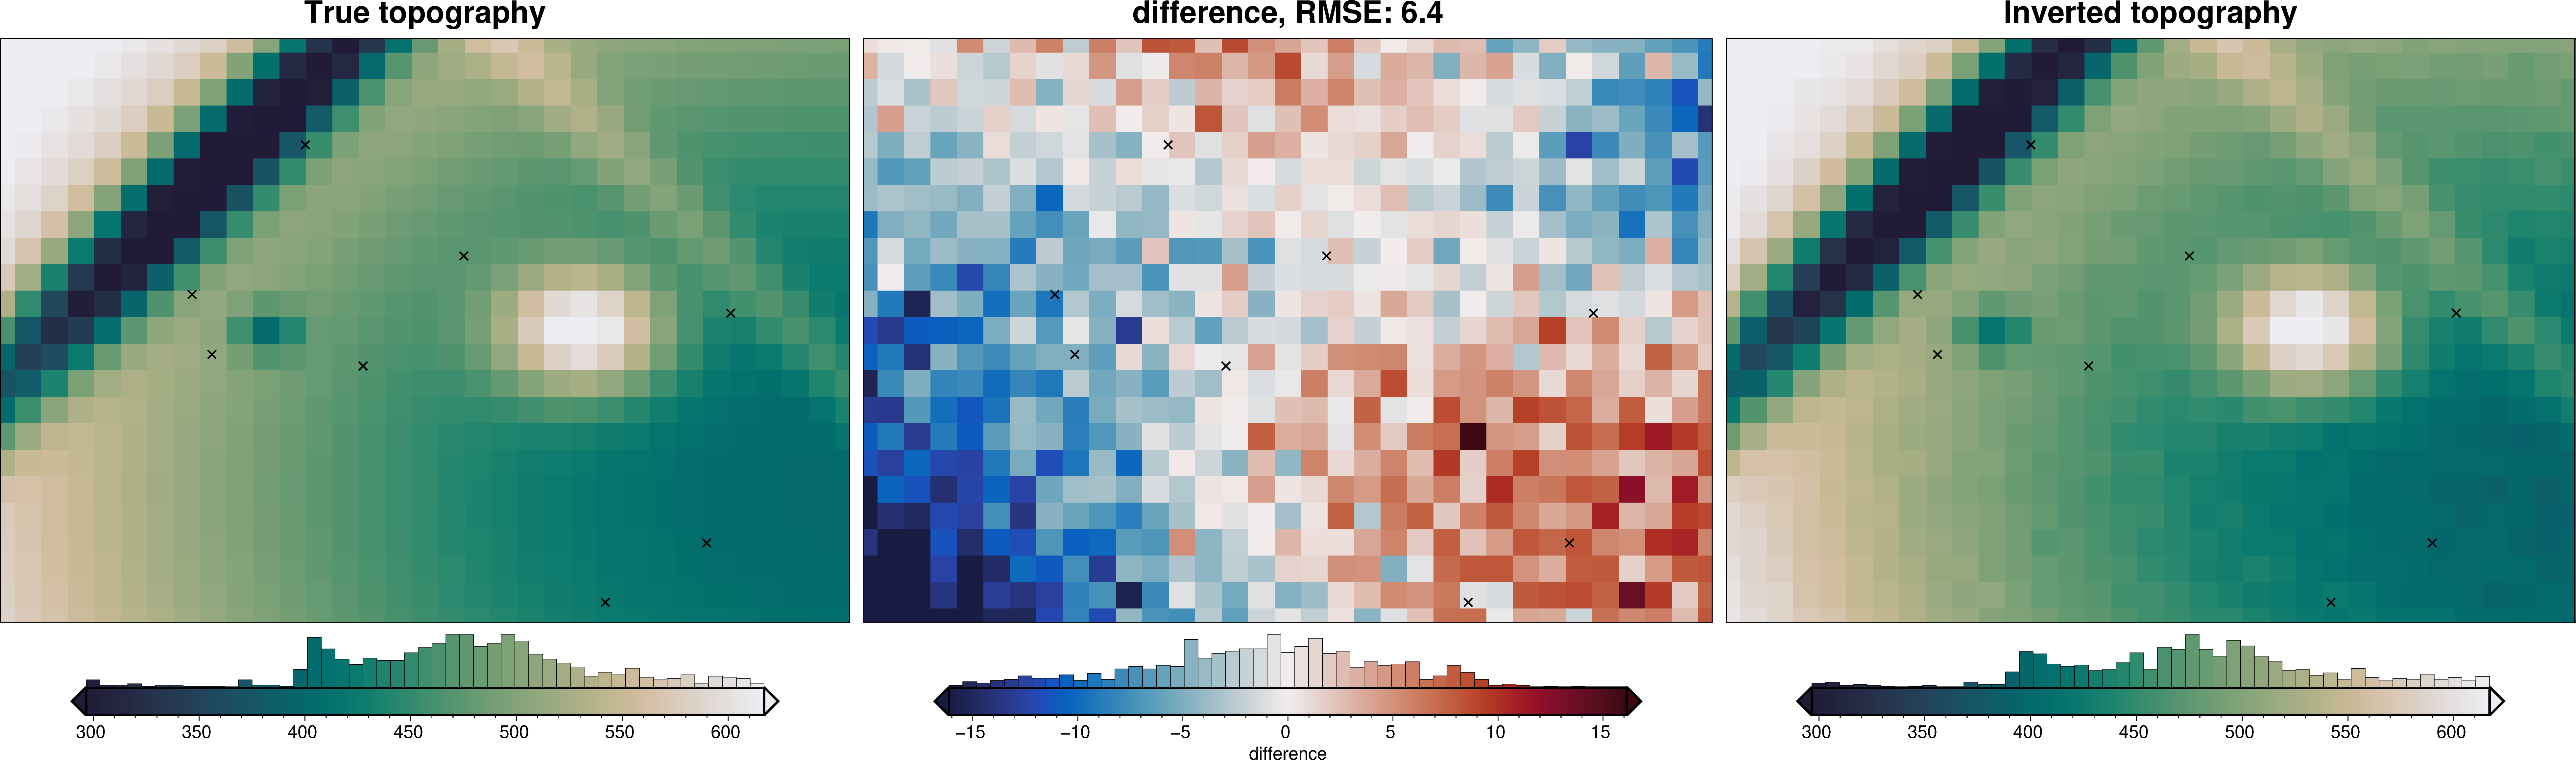

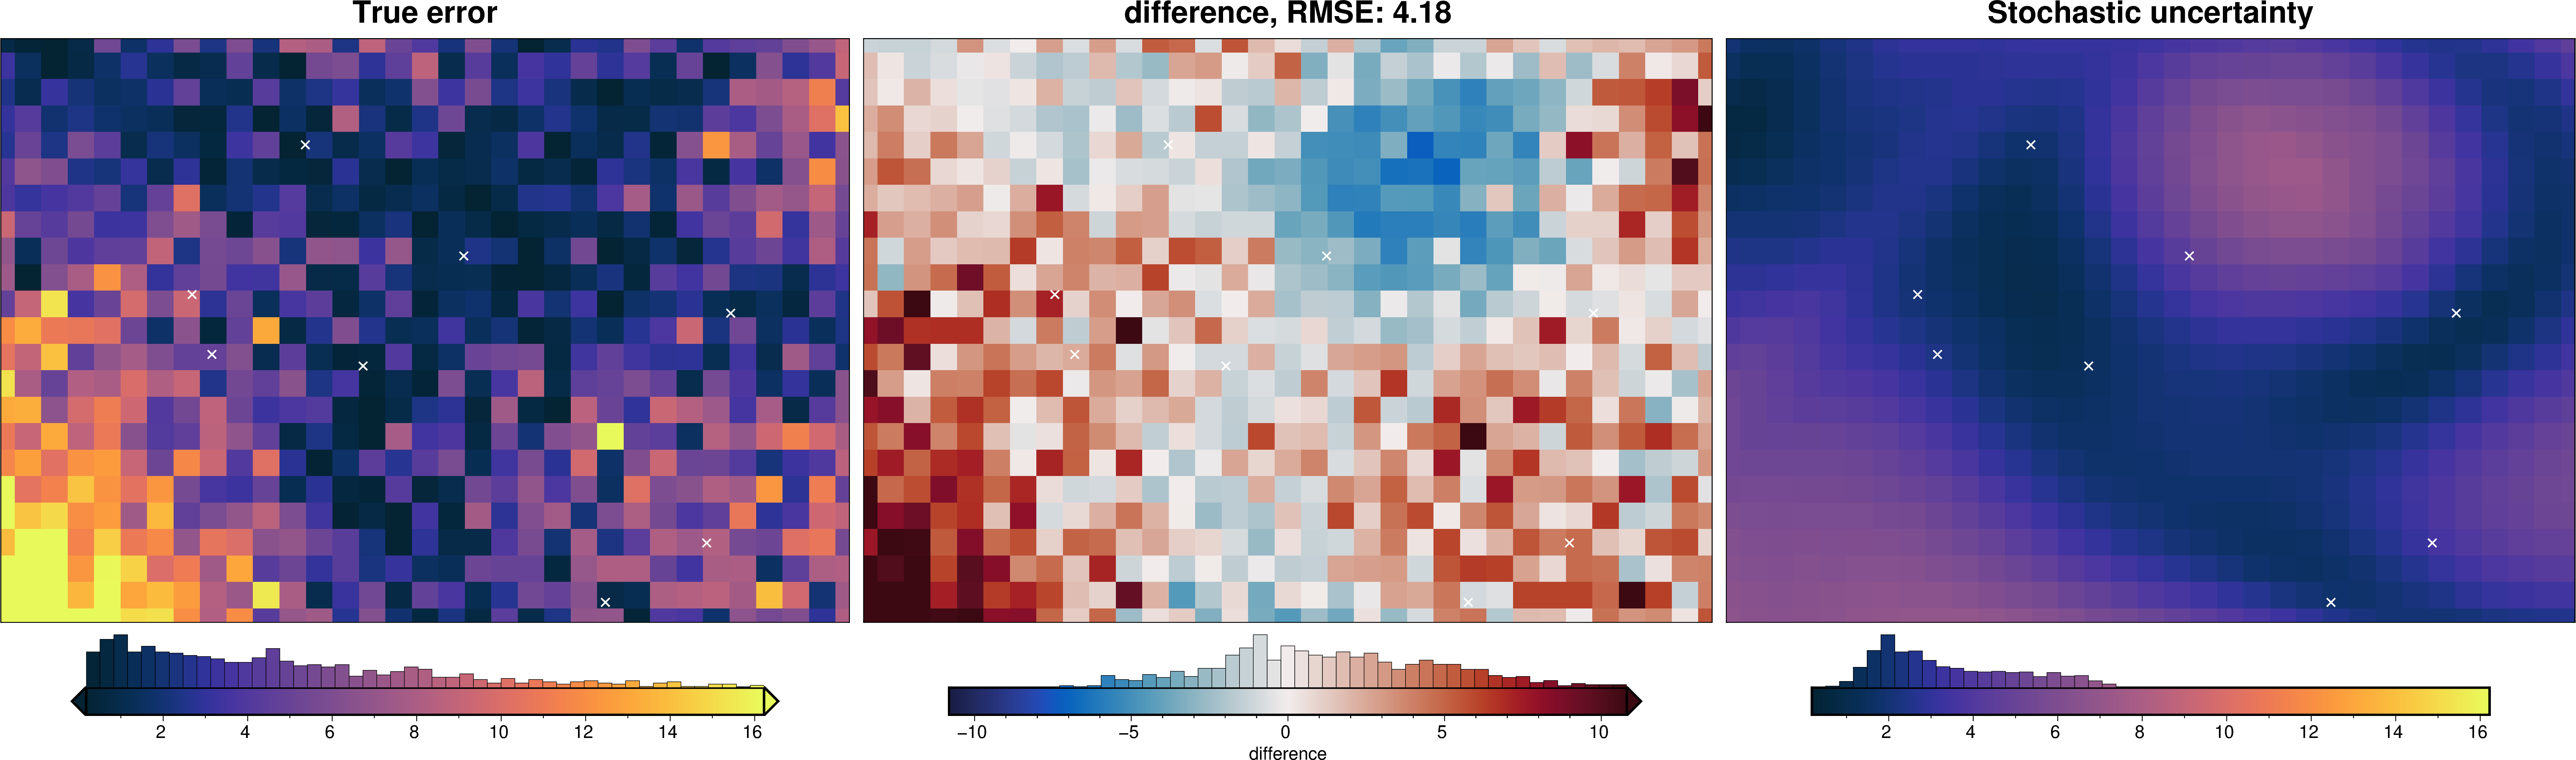

In [24]:
fname = "../tmp/10_uncertainty_regional"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_regional_results = invert4geom.full_workflow_uncertainty_loop(
    inv,
    fname=fname,
    runs=10,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

stats_ds = uncert_plots(
    uncert_regional_results,
    inv.data.inner_region,
    inv.data.spacing,
    true_topography,
    constraints_df=constraints_df,
    weight_by="constraints",
)

### Total uncertainty

stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

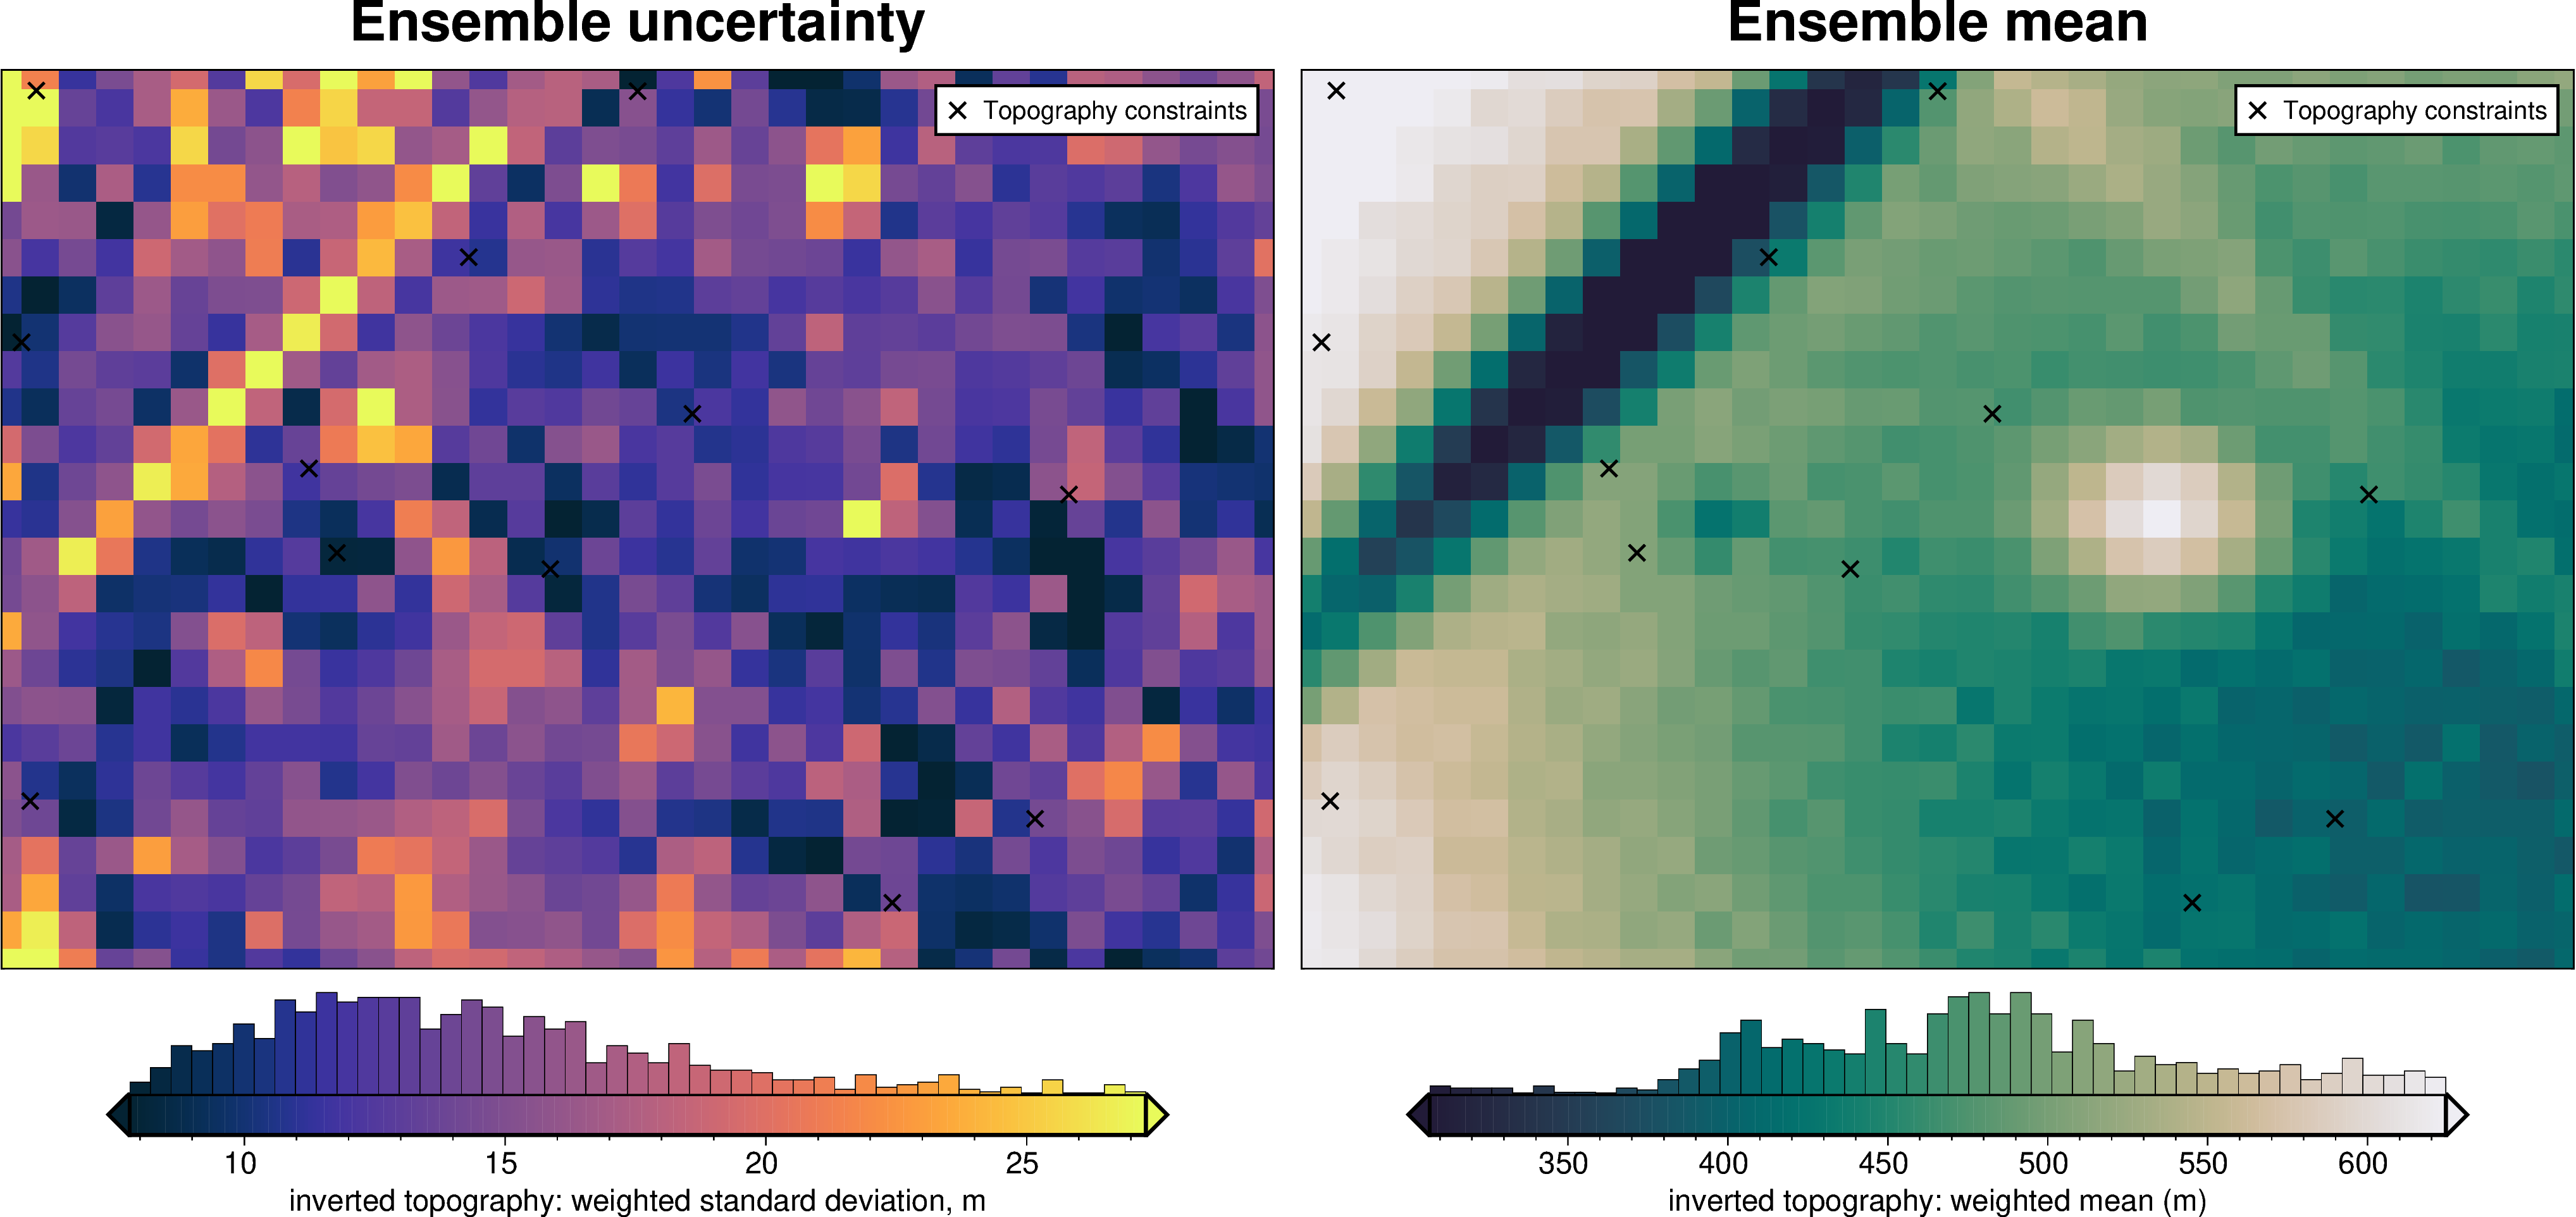

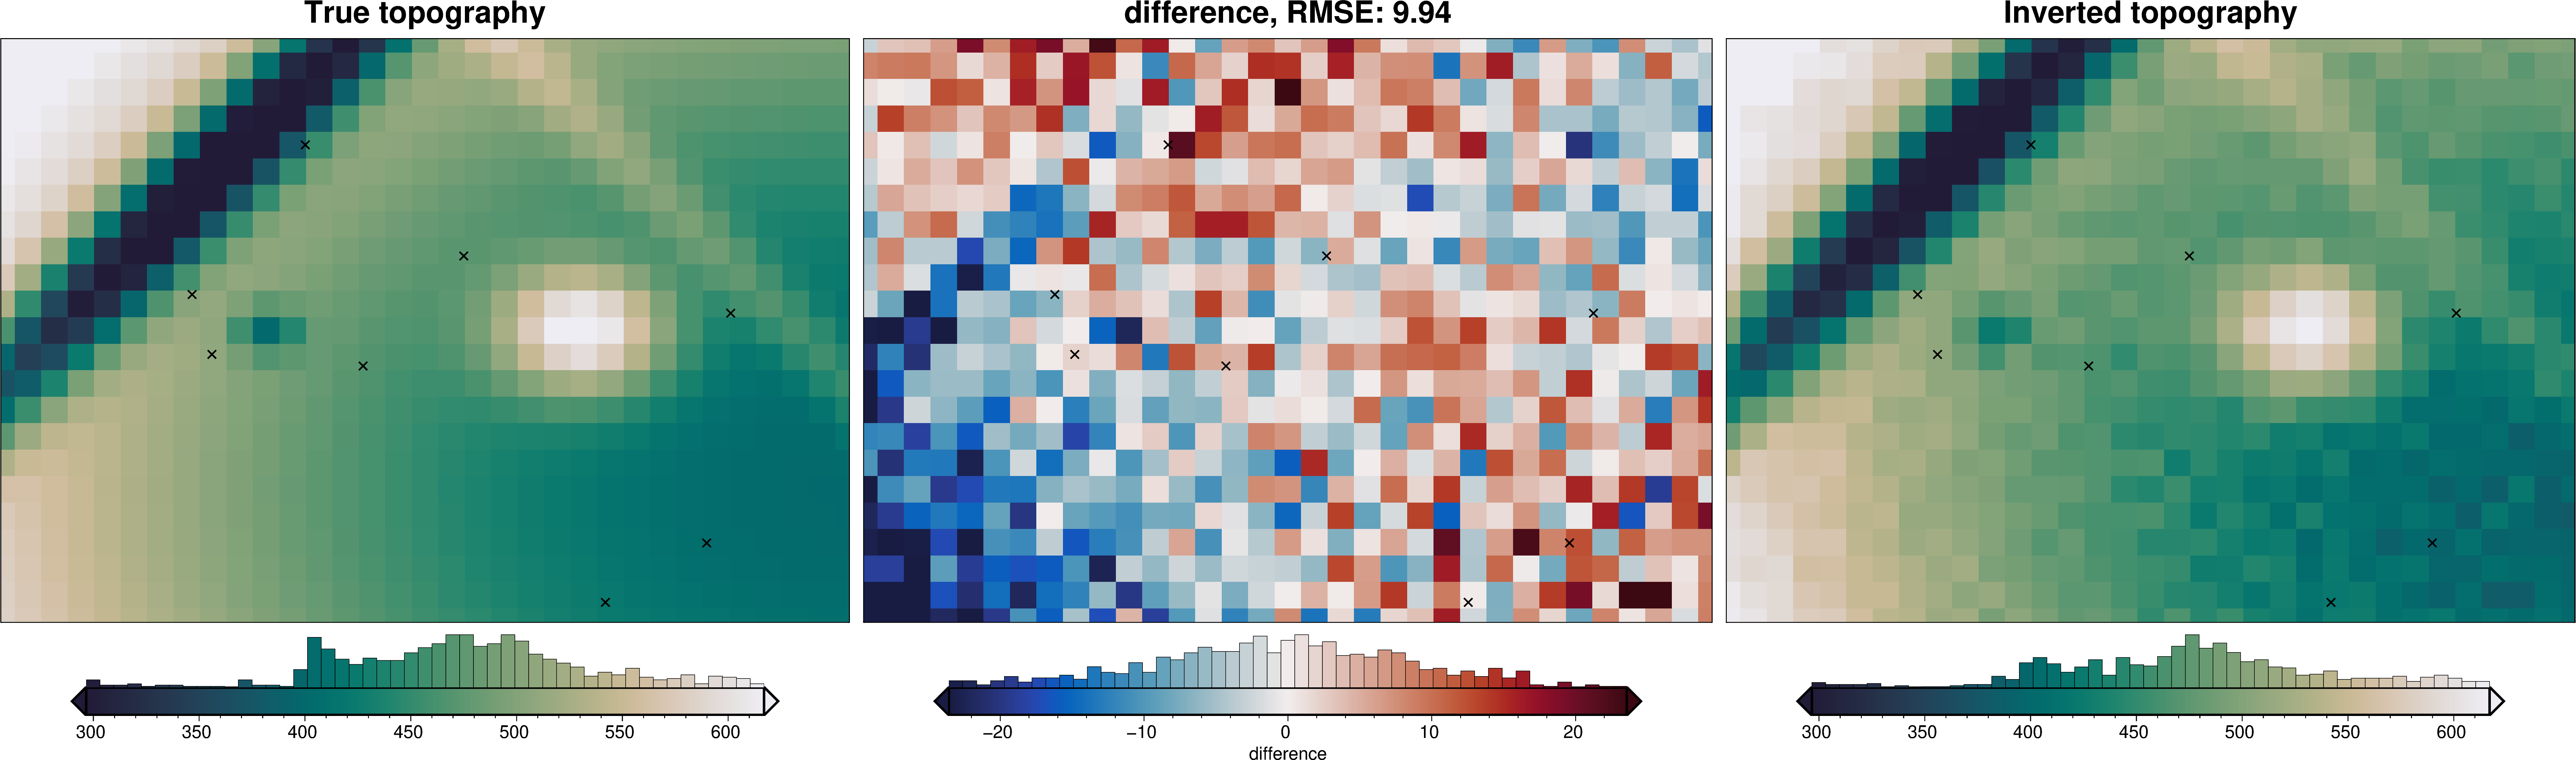

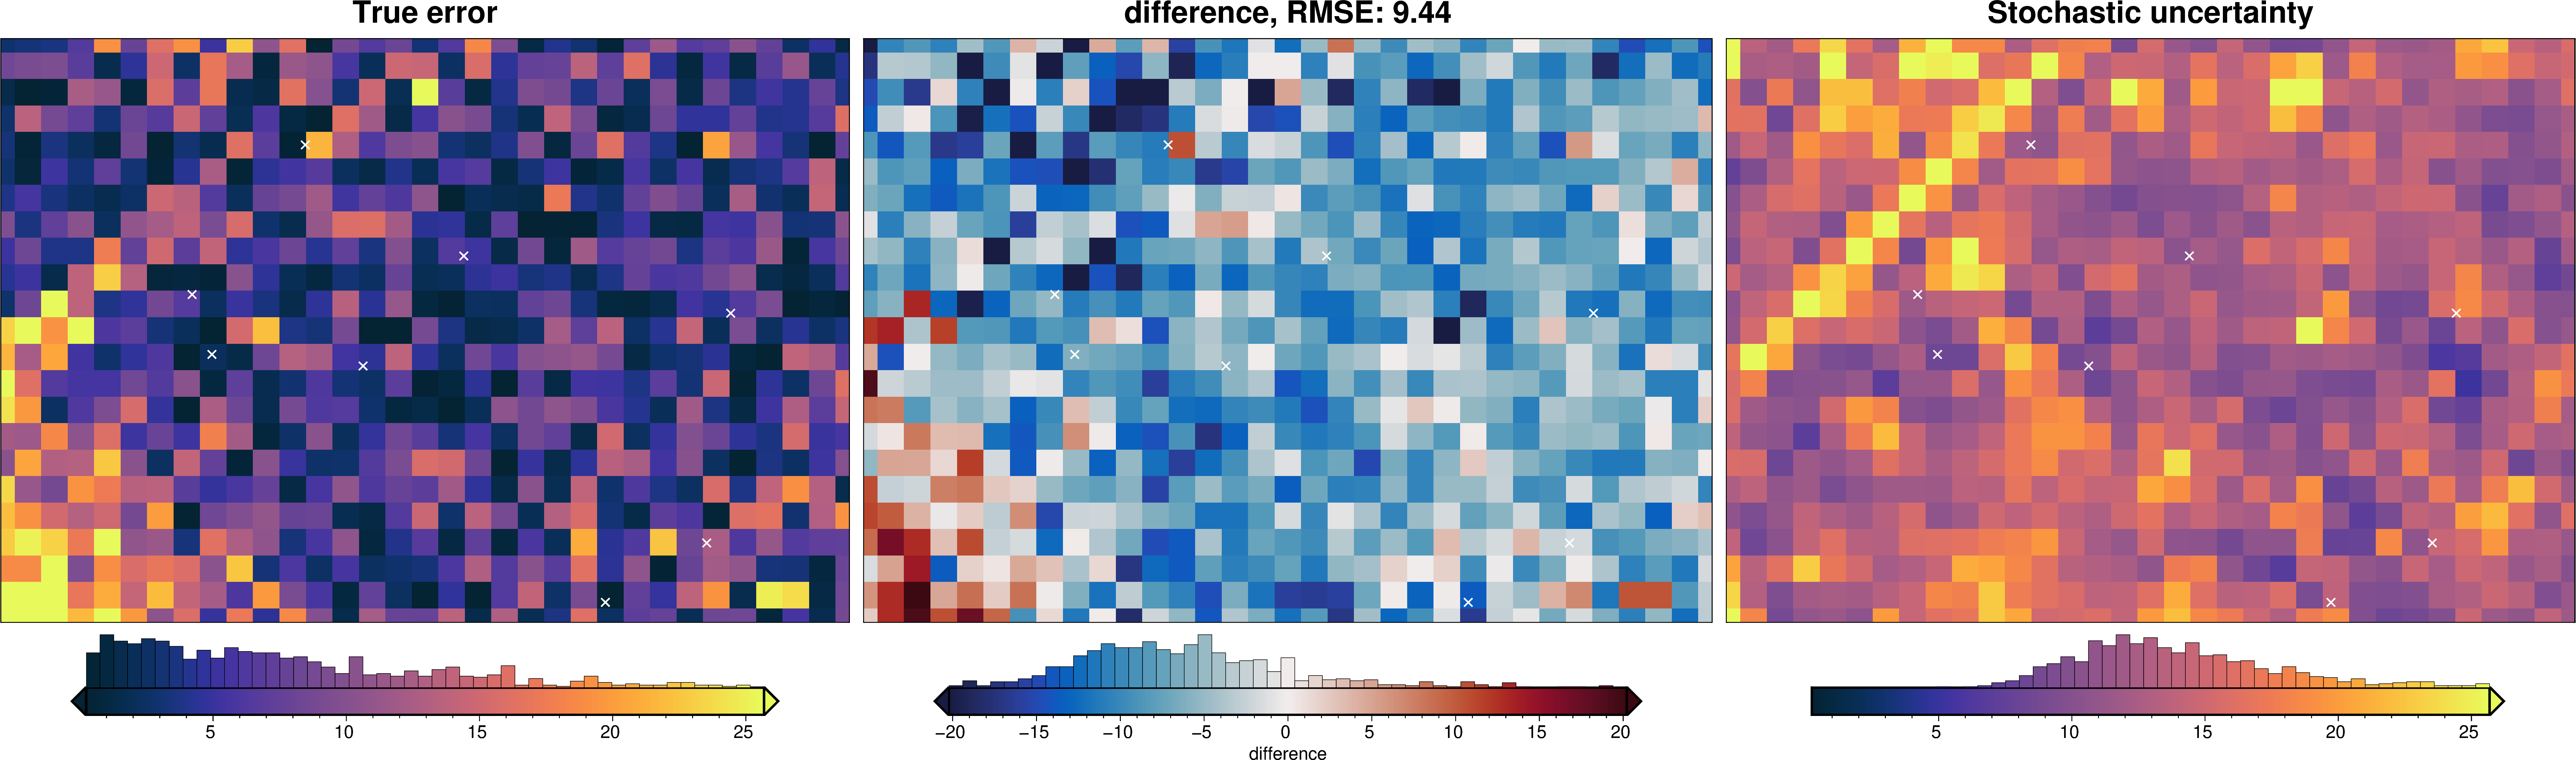

In [25]:
fname = "../tmp/10_uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = invert4geom.full_workflow_uncertainty_loop(
    inv,
    fname=fname,
    runs=20,
    sample_gravity=True,
    sample_constraints=True,
    constraints_df=constraints_df,
    parameter_dict=solver_dict | density_dict | zref_dict,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

stats_ds = uncert_plots(
    uncert_results,
    inv.data.inner_region,
    inv.data.spacing,
    true_topography,
    constraints_df=constraints_df,
    weight_by="constraints",
)

### Comparing results

In [26]:
results = [
    uncert_results,
    uncert_regional_results,
    uncert_grav_results,
    uncert_constraints_results,
    uncert_density_results,
    uncert_zref_results,
    uncert_damping_results,
]
names = [
    "full",
    "regional",
    "grav",
    "constraints",
    "density",
    "zref",
    "damping",
]
# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = invert4geom.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraints_df,
        weight_by="constraints",
        region=inv.data.inner_region,
    )
    stats.append(ds)

In [27]:
# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs, compat="override")
merged

<xarray.Dataset> Size: 63kB
Dimensions:            (northing: 25, easting: 35)
Coordinates:
  * northing           (northing) float64 200B 3e+03 4e+03 ... 2.6e+04 2.7e+04
  * easting            (easting) float64 280B 3e+03 4e+03 ... 3.6e+04 3.7e+04
    top                (northing, easting) float64 7kB 626.7 619.1 ... 508.1
    bottom             (northing, easting) float64 7kB 443.3 443.3 ... 443.3
Data variables:
    full_stdev         (northing, easting) float64 7kB 29.09 31.05 ... 18.44
    regional_stdev     (northing, easting) float64 7kB 7.322 6.899 ... 6.317
    grav_stdev         (northing, easting) float64 7kB 3.868 2.793 ... 7.812
    constraints_stdev  (northing, easting) float64 7kB 6.815 6.692 ... 14.69
    density_stdev      (northing, easting) float64 7kB 1.619 1.672 ... 1.806
    zref_stdev         (northing, easting) float64 7kB 1.361 1.449 ... 2.961
    damping_stdev      (northing, easting) float64 7kB 2.258 2.3 ... 10.93 6.511

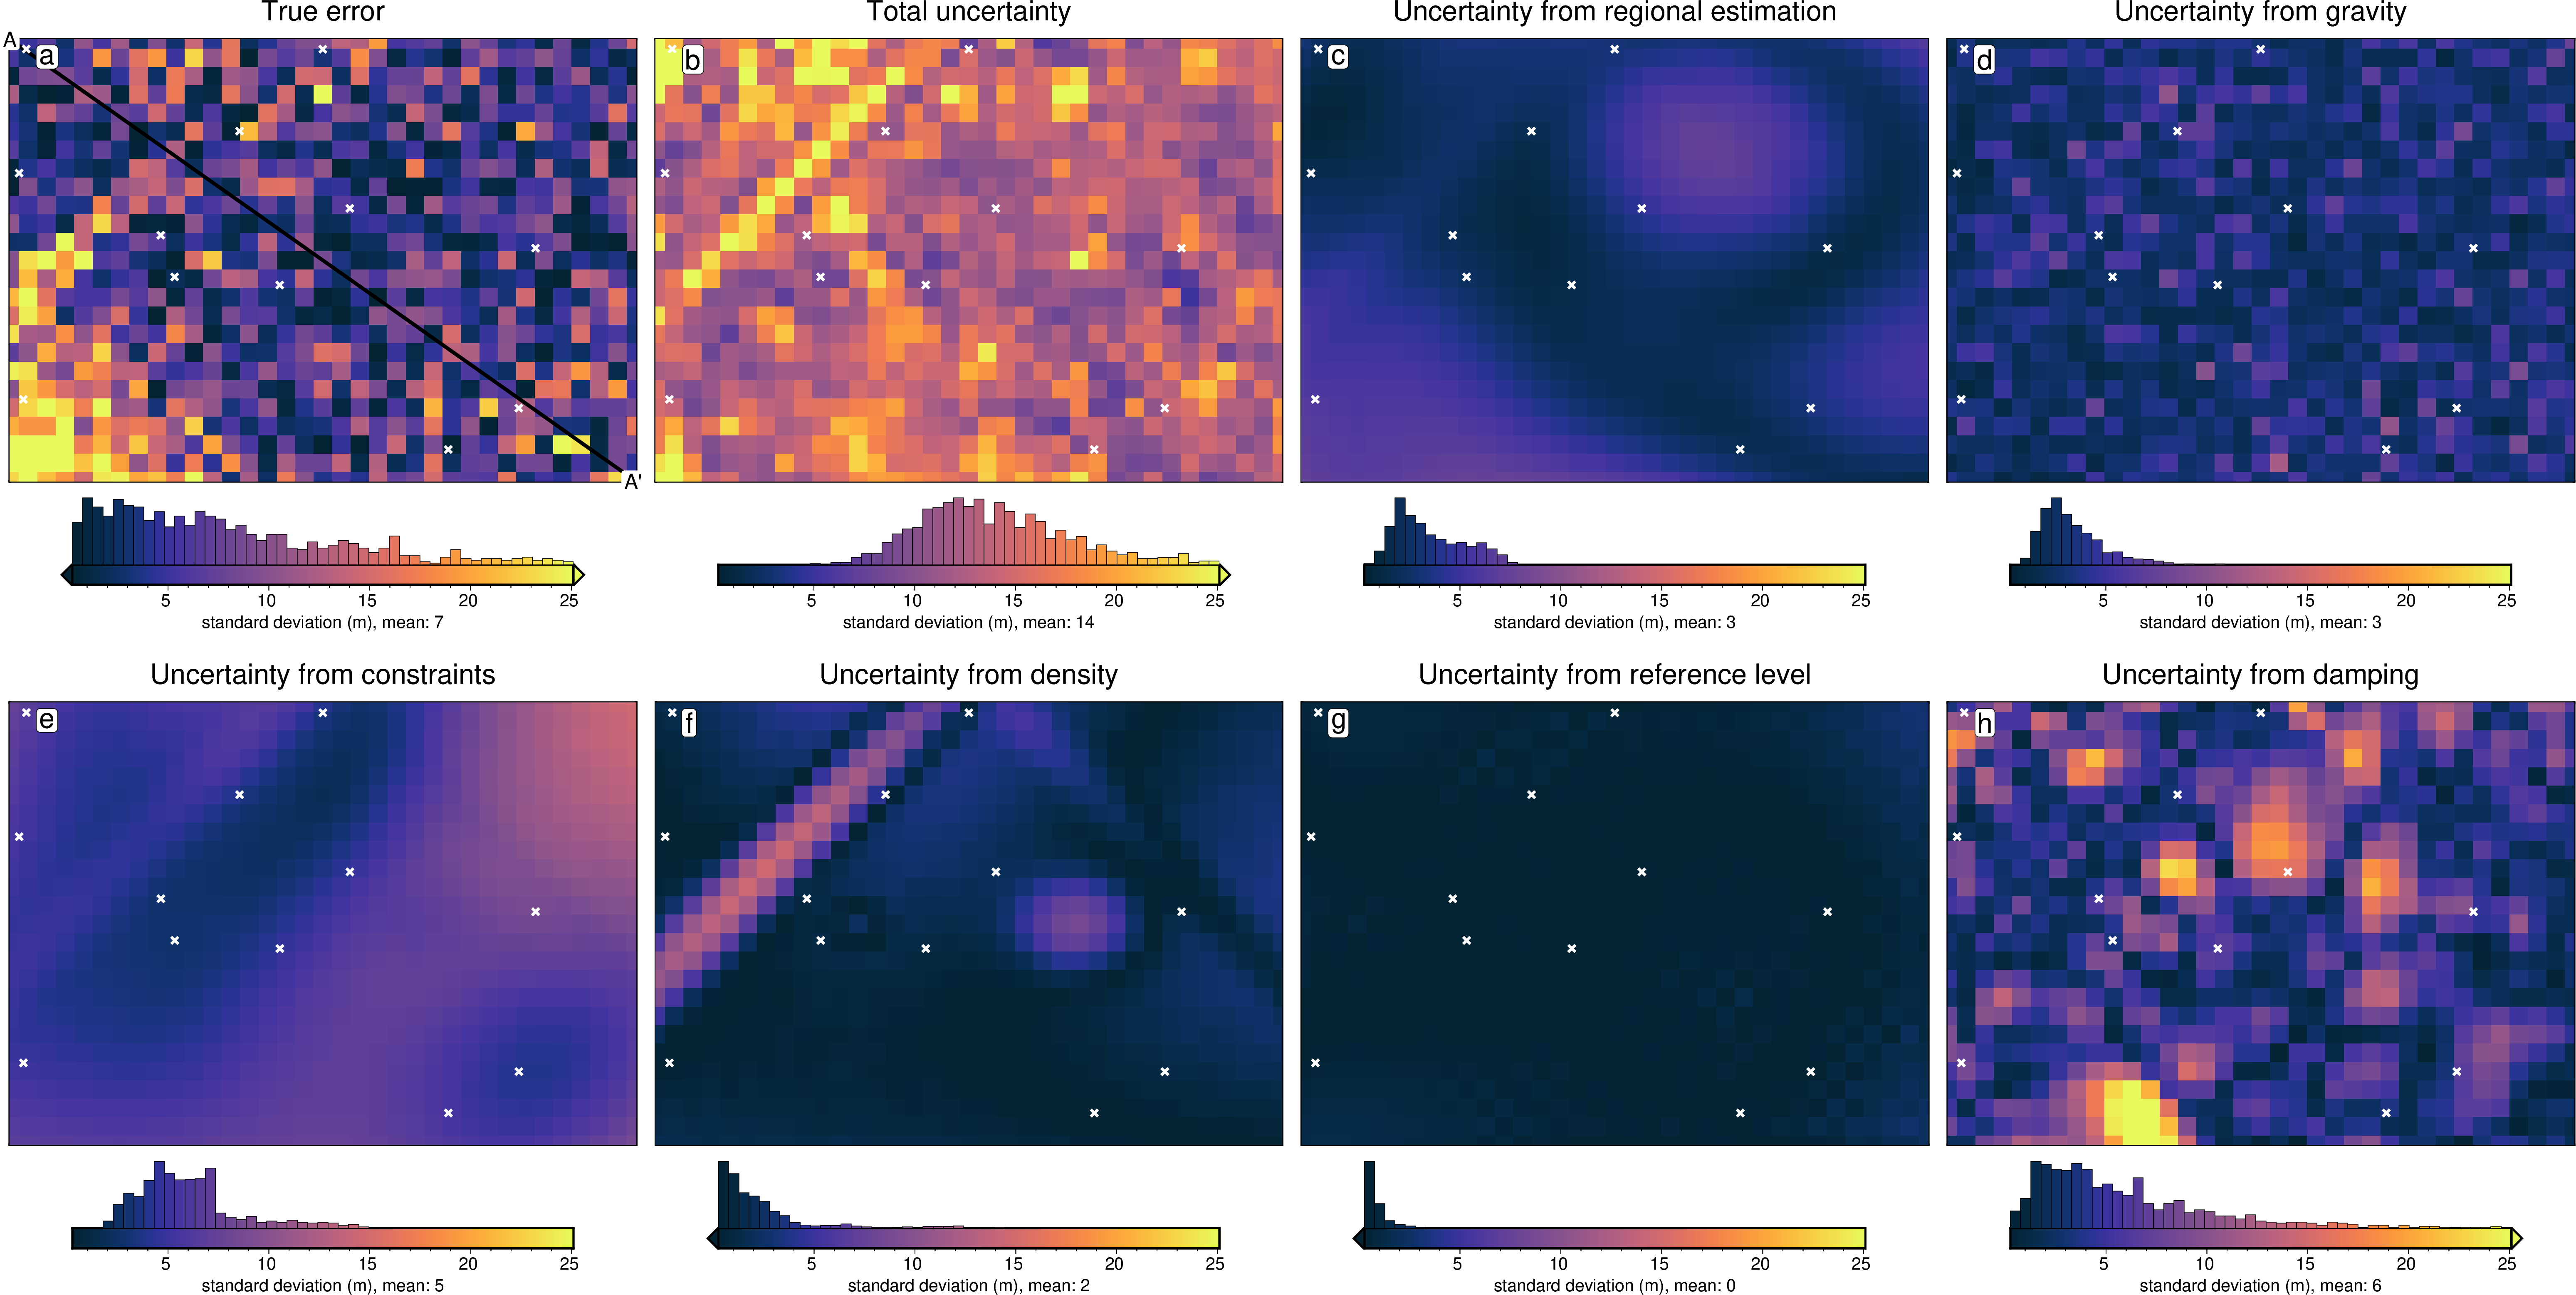

In [ ]:
titles = [
    "True error",
    "Total uncertainty",
    "Uncertainty from regional estimation",
    "Uncertainty from gravity",
    "Uncertainty from constraints",
    "Uncertainty from density",
    "Uncertainty from reference level",
    "Uncertainty from damping",
]
grids = list(merged.data_vars.values())

grids.insert(0, np.abs(stats[0].weighted_mean - true_topography))

cpt_lims = polar_utils.get_min_max(
    grids[0],
    robust=True,
)

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
    elif i == 4:
        origin_shift = "both"
        xshift_amount = -3
    else:
        origin_shift = "x"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap="thermal",
        cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
    )
    if i == 0:
        # plot profile location, and endpoints on map
        start = [inv.data.inner_region[0], inv.data.inner_region[3]]
        stop = [inv.data.inner_region[1], inv.data.inner_region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
    fig.plot(
        x=constraints_df.easting,
        y=constraints_df.northing,
        style="x.2c",
        pen="1.5p,white",
        fill="white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
fig.show()

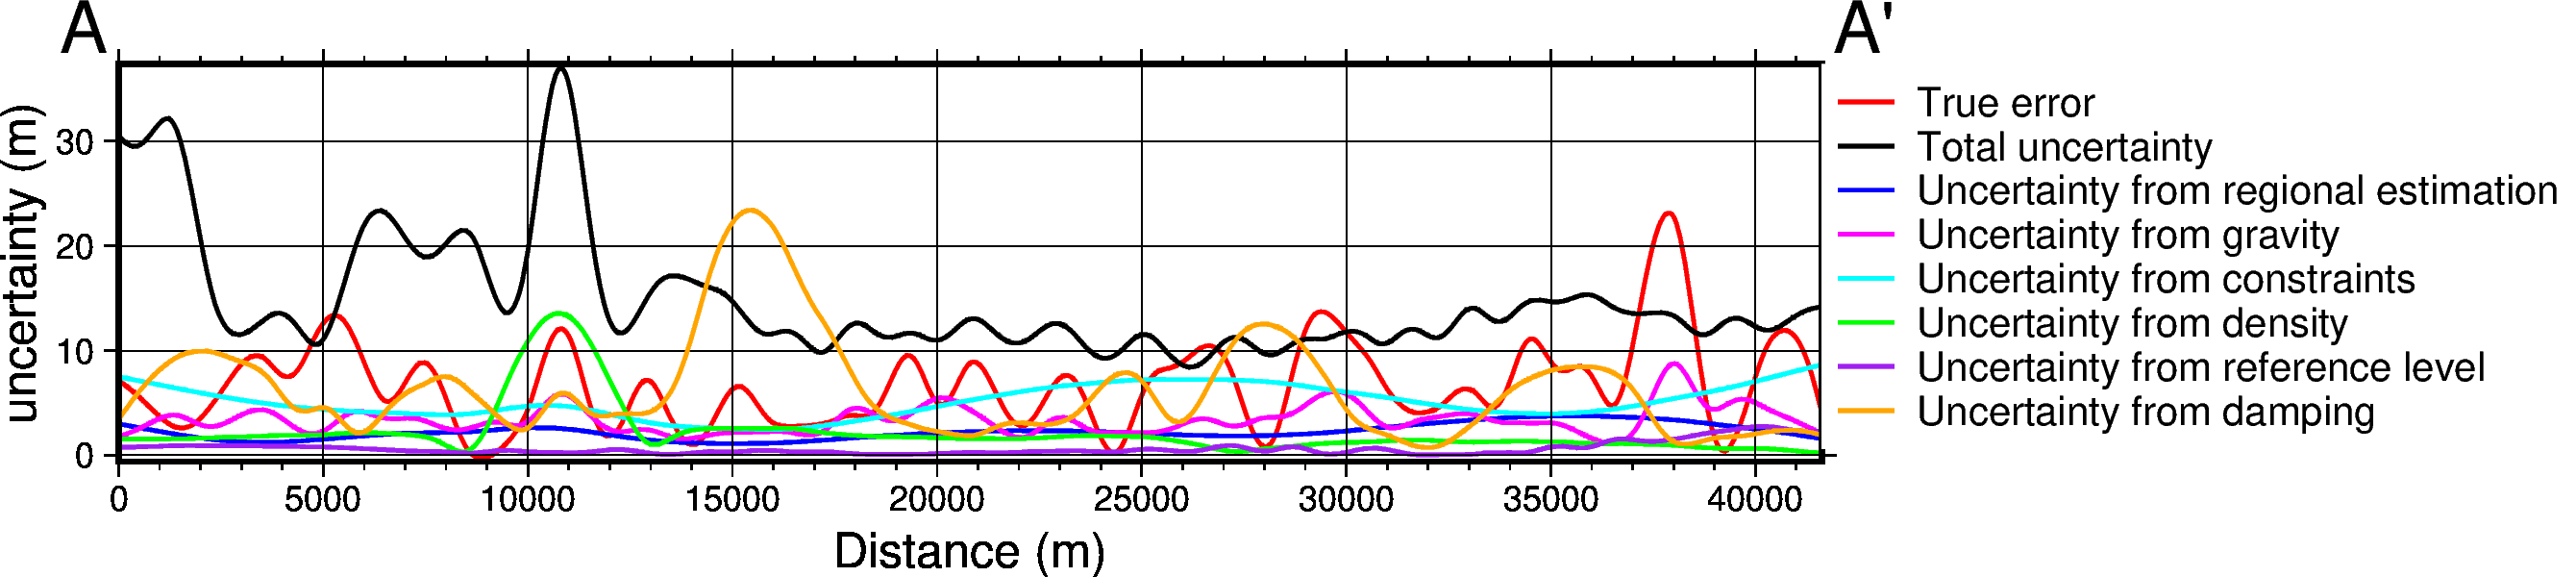

In [29]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
        "orange",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[inv.data.inner_region[0], inv.data.inner_region[3]],
    stop=[inv.data.inner_region[1], inv.data.inner_region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()